# **Youtube Video Views Prediction**

#### Current model situation (Before rewrite)

1. MAE (Mean Absolute Error): 670,593.83
- This number seems quite large, but its interpretation depends on your data's scale. If you're predicting something like house prices or company revenues where values are in millions, this might be acceptable.

2. RMSE (Root Mean Square Error): 3,197,034.17
- This is significantly higher than the MAE, which indicates you have some large prediction errors (outliers) since RMSE penalizes large errors more heavily.

3. MAPE (Mean Absolute Percentage Error): 59.31%
- This is concerning. A MAPE of ~59% means your predictions are off by about 59% on average. Generally, a MAPE above 20% is considered poor for most applications.

4. R² Scores:
- Test: 0.093 (9.3%)
- Cross-validation train: 0.925 (92.5%)
- Cross-validation test: 0.712 (71.2%)

The most concerning aspects are:

1. The huge gap between training (92.5%) and test (9.3%) R² scores indicates severe overfitting
2. The final test R² of 0.093 means your model only explains about 9.3% of the variance in the target variable, which is very poor
3. The MAPE of 59% suggests low prediction accuracy

> Will need to initialize rewrite for this project

## 📌 Problem Statement  

A digital media analytics company in India aims to forecast YouTube video performance to support content creators and marketers in optimizing their content strategies. However, the current approach lacks predictive capabilities, making it challenging to estimate the potential success of a video before publishing. This results in missed opportunities for maximizing audience engagement and leveraging trends effectively.  

## 📌 Goals  

- Predict YouTube video performance: Develop a machine learning model to forecast the number of views a video might generate before it is uploaded. (**MAIN**)  
- Assist content creators and marketers: Enable data-driven decisions in content planning and optimization. (**SECONDARY**)  

## 📌 Objectives  

The project seeks to achieve the following objectives:  

1. Build a predictive model capable of estimating the number of views a video will generate, leveraging historical data and video metadata.  
2. Identify key features influencing viewership trends to provide actionable insights for video optimization.  
3. Help creators and marketers align their strategies with emerging trends and maximize audience reach.  

## 📌 Business Metrics  

- **Mean Absolute Percentage Error (MAPE):** Measure the accuracy of the predicted view count compared to the actual view count. (**MAIN**)  
- **Engagement Rate (ER):** Percentage of interactions (likes, comments, shares) relative to the video views to gauge engagement potential. (**SECONDARY**)  

# **STAGE 1 : EXPLORATORY DATA ANALYSIS (EDA)**

### Import Libraries and Settings

In [1]:
# Resets all variables in the current namespace
%reset -f

In [2]:
# Import initial necessary libraries
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import tensorflow as tf
from tensorflow import keras

import os
import sklearn
import joblib
import math
import scipy.stats as stats
from scipy.stats import skew, kurtosis, chi2_contingency

# For translation of several text columns that are in Indian language
from openai import OpenAI
import time
from tqdm import tqdm  # for progress bar
from dotenv import load_dotenv
load_dotenv()

# Settings of dataframe display
pd.options.display.max_columns = 100
## Funtion to change the display width of the columns (needed for text analysis)
def change_colwidth(option="set"):
    if option == "set":
        pd.set_option('max_colwidth', None)

    elif option == "reset":
        pd.reset_option('max_colwidth')    

# Set random seed for all numpy random generation methods
np.random.seed(42)

# Version requirements
print('numpy version : ',np.__version__)
print('pandas version : ',pd.__version__)
print('seaborn version : ',sns.__version__)
print("scikit-learn version:", sklearn.__version__)
print("joblib version:", joblib.__version__)

numpy version :  1.26.4
pandas version :  2.2.1
seaborn version :  0.13.2
scikit-learn version: 1.4.0
joblib version: 1.3.2


#### Load Dataset (Jupyter Notebook)

In [9]:
# Read from local directory
## Get absolute path to the parent directory without changing current directory
parent_dir = os.path.abspath(os.getcwd())
data_path = os.path.join(parent_dir, 'data', 'youtube_statistics.xlsx')

# Debugging some paths problems
print(f"Current directory: {os.getcwd()}")
print(f"Current directory: {os.path.abspath(os.getcwd())}")
print(f"parent directory: {os.pardir}")
print(f"Parent directory: {parent_dir}")
print(f"Data path: {data_path}")

## Load the data from local
try:
    df = pd.read_excel(data_path)
except FileNotFoundError:
    print(f"Error: File not found at {data_path}")

Current directory: e:\Personal Projects\Youtube Video Views Prediction\Youtube-Video-Views-Prediction
Current directory: e:\Personal Projects\Youtube Video Views Prediction\Youtube-Video-Views-Prediction
parent directory: ..
Parent directory: e:\Personal Projects\Youtube Video Views Prediction\Youtube-Video-Views-Prediction
Data path: e:\Personal Projects\Youtube Video Views Prediction\Youtube-Video-Views-Prediction\data\youtube_statistics.xlsx


#### Load Dataset (Google Colab)

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
# df = pd.read_excel('/content/drive/MyDrive/Google Drive/youtube_statistics.xlsx')

## Data Understanding and Initial Transformation

In [10]:
# Retrieve 5 sample lines from the available data
display(df.sample(5))

trending_date                                              title  \
3792     2017-12-04  Mana Mugguri Love Story Episode 5 | Navdeep | ...   
13480    2018-01-27  ഒളിച്ചോടിയ പെൺകുട്ടിയും ആൺകുട്ടിയും രക്ഷയില്ലാ...   
21110    2018-03-13  ഹാദിയയും ഷെഫിന്‍ ജഹാനും കേരളത്തിലേക്ക് തിരിച്ച...   
35549    2018-06-07  8:00 AM - CURRENT AFFAIRS SHOW 7th June | RRB ...   
2952     2017-11-29  ఇవాంకా హైదరాబాద్ లో ఉండబోయే హోటల్ కు...ఒక్క రో...   

          channel_title  category_id publish_time  \
3792   YuppTV Originals           24     05:15:52   
13480     Malayali Live           24     20:25:38   
21110       Mathrubhumi           25     13:51:55   
35549         WiFiStudy           27     03:03:05   
2952              OmFut           24     09:49:53   

                                                    tags   views  likes  \
3792   yupptv originals|"yupptv"|"web series"|"short ...  395187   2401   
13480  malayalam film|"malayalam news"|"malayalam fil...  393450   3402   
21110  Mathrubhumi|"Online"|"news"|"latest"|"breaking...  299072   1928   
35549  daily current affairs|"latest current affairs"...   45873   3321   
2952   Ivanka Trump Hyderabad Visit|"Ivanka Hyderabad...  213497    499   

       dislikes  comment_count  comments_disabled  ratings_disabled  \
3792        313            351              False             False   
13480      1190           1151              False             False   
21110       380            189              False             False   
35549       127            596              False             False   
2952        198             48              False             False   

       video_error_or_removed  \
3792                    False   
13480                   False   
21110                   False   
35549                   False   
2952                    False   

                                             description  No_tags  desc_len  \
3792   #ManaMugguriLoveStory is a #TeluguWebSeries de...       22      1037   
13480  Please Subscribe Malayali Live Youtube Channel...        8       103   
21110  Click Here to free Subscribe : https://goo.gl/...        7       329   
35549  8:00 AM - CURRENT AFFAIRS SHOW 7th June | RRB ...       19      1685   
2952   Ivanka Trump Hyderabad Visit..! Ivana Marie Iv...       20      1061   

       len_title publish_date  
3792          95   2017-12-02  
13480         85   2018-01-25  
21110         71   2018-03-09  
35549         95   2018-06-07  
2952         100   2017-11-25

Reset the maximum column width to default after displaying the `title`, `tags`, and `description`.

In [11]:
# Checking shape of dataframe
print(f'Number of rows: {df.shape[0]}')
print(f'Number of columns {df.shape[1]}')

Number of rows: 36791
Number of columns 18


> The original dataframe has 36791 rows and 18 columns.

In [12]:
# Checking basic data information
def check_data_information(df, cols):
    """
    This function provides detailed information about each column in a dataframe, including:
    - Data type of the column
    - Number of missing (null) values
    - Percentage of missing values
    - Total number of duplicated rows in the dataframe (not column-specific)
    - Number of unique values in the column
    - A sample of up to 5 unique values from the column

    Parameters:
    df (pd.DataFrame): The dataframe you want to check.
    cols (list): List of column names to check the information from.

    Returns:
    pd.DataFrame: A dataframe with detailed information for each column.
    """
    list_item = []
    for col in cols:
        list_item.append([col,                             # The column name
                          df[col].dtype,                   # The data type of the column
                          df[col].isna().sum(),            # The count of null values in the column
                          round(100 * df[col].isna().sum() / len(df[col]), 2),  # The percentage of null values
                          df.duplicated().sum(),           # The count of duplicated rows in the entire dataframe
                          df[col].nunique(),               # The count of unique values in the column
                          df[col].unique()[:5]])           # A sample of the first 5 unique values in the column

    desc_df = pd.DataFrame(data=list_item, columns='Feature, Data Type, Null Values, Null Percentage, Duplicated Values, Unique Values, Unique Sample'.split(","))
    return desc_df

columns_to_check = df.columns
check_data_information(df, columns_to_check)

Feature       Data Type   Null Values   Null Percentage  \
0            trending_date          object             0              0.00   
1                    title          object             0              0.00   
2            channel_title          object             0              0.00   
3              category_id           int64             0              0.00   
4             publish_time          object             0              0.00   
5                     tags          object             0              0.00   
6                    views           int64             0              0.00   
7                    likes           int64             0              0.00   
8                 dislikes           int64             0              0.00   
9            comment_count           int64             0              0.00   
10       comments_disabled            bool             0              0.00   
11        ratings_disabled            bool             0              0.00   
12  video_error_or_removed            bool             0              0.00   
13             description          object            45              0.12   
14                 No_tags           int64             0              0.00   
15                desc_len           int64             0              0.00   
16               len_title           int64             0              0.00   
17            publish_date  datetime64[ns]             0              0.00   

     Duplicated Values   Unique Values  \
0                 4229             205   
1                 4229           16431   
2                 4229            1390   
3                 4229              17   
4                 4229           12375   
5                 4229           12463   
6                 4229           31638   
7                 4229           15473   
8                 4229            5072   
9                 4229            6024   
10                4229               2   
11                4229               2   
12                4229               2   
13                4229           13979   
14                4229              66   
15                4229            2850   
16                4229              91   
17                4229             219   

                                        Unique Sample  
0   [2017-11-14, 2017-11-15, 2017-11-16, 2017-11-1...  
1   [Sharry Mann: Cute Munda ( Song Teaser) | Parm...  
2   [Lokdhun Punjabi, HJ NEWS, TFPC, Eruma Saani, ...  
3                                 [1, 25, 24, 23, 10]  
4   [12:20:39, 05:43:56, 15:48:08, 07:08:48, 01:14...  
5   [sharry mann|"sharry mann new song"|"sharry ma...  
6          [1096327, 590101, 473988, 1242680, 464015]  
7                      [33966, 735, 2011, 70353, 492]  
8                          [798, 904, 243, 1624, 293]  
9                             [882, 0, 149, 2684, 66]  
10                                      [False, True]  
11                                      [False, True]  
12                                      [False, True]  
13  [Presenting Sharry Mann latest Punjabi Song  C...  
14                               [15, 19, 14, 20, 11]  
15                         [920, 2232, 482, 263, 753]  
16                               [81, 58, 30, 88, 91]  
17  [2017-11-12 00:00:00, 2017-11-13 00:00:00, 201...

**Quick Overview:**
- Dataset contains 36791 rows, 18 features.
- There are several columns that will be dropped for our analysis.
- Dataset consists of 4 data types; float64, int64, datetime, and object. With several columns that currently has object type need to be transformed into datetime columns (more on this below).
- Dataset contains null values only in `description` column with really small percentage. But in this case the null values in `description` column just means that the videos doesn't have a description so we don't have to drop them.

**Feature Information**

| **Feature Name** | **Description** | **Data Type** | **Specific Data Type** |
|-----------------|-----------------|---------------|----------------------|
| `trending_date` | Date when the video is trending | Date | Timestamp |
| `title` | Video title | Text | String |
| `channel_title` | Channel name | Text | String |
| `category_id` | Video category in label encoding | Numerical | Integer (Categorical) |
| `publish_time` | Video publishing time | Time | Timestamp |
| `tags` | Tags used in the video | Text | String (Array) |
| `views` | Number of video views **(Target Variable)** | Numerical | Integer (Discrete) |
| `likes` | Number of video likes | Numerical | Integer (Discrete) |
| `dislikes` | Number of video dislikes | Numerical | Integer (Discrete) |
| `comment_count` | Number of comments on the video | Numerical | Integer (Discrete) |
| `comments_disabled` | Indicates whether comments are disabled for the video | Boolean | Binary |
| `ratings_disabled` | Indicates whether ratings are disabled for the video | Boolean | Binary |
| `video_error_or_removed` | Indicates whether the video is currently in error or has been removed | Boolean | Binary |
| `description` | Video description | Text | String |
| `No_tags` | Number of tags used | Numerical | Integer (Discrete) |
| `desc_len` | Length of the video description in terms of words | Numerical | Integer (Discrete) |
| `len_title` | Length of the video title in terms of words | Numerical | Integer (Discrete) |
| `publish_date` | Date when the video was published | Date | Timestamp |

In [9]:
# Grouping columns based on their types
nums_cols = ['likes', 'dislikes', 'comment_count', 'No_tags', 'desc_len', 'len_title', 'views']
cats_cols = ['title', 'channel_title', 'tags','description', 'category_id', 'comments_disabled', 'ratings_disabled', 'video_error_or_removed']
dates_cols = ['trending_date', 'publish_time_fixed']

---
Just from these information, there are some useful insight to this data that understanding it could make it easier for further analysis and feature transformation, they are :

- The publish time information is currently separated here into 2 different columns, `publish_date` which already have the correct data type and `publish_time` that currently have object data type. We probably need to and then combine these 2 into 1 as a complete datetime format. Also, to get better insight we need to calculate the date difference between the new combined publish time and the `trending_date` (we can only do this in date since the `trending_date` granuality is limited to days).

- Video category (`category_id`) is displayed as a labelled number already, so we are quite unsure what the details of each video like which one is Gaming, Music Videos, News and Politics, etc.

- `title`, `tags`, and `description` are quite interesting to play around in text mining though it will be quite challenging in separating the english and indian texts (especially since I'm don't even know a single Indian word). So there's a high chance we will only be playing with the lenght of those text columns.

- As for boolean feature like `comments_disabled`, `ratings_disabled`, `video_error_or_removed` potentially could be encoded by one-hot encoding since they are nominal values.

- `channel_title` most likely if we want to use it, will be done through frequency/count encoding similar to other long text features.

- Feature `views` is the target variable, we would later move it to the last order in dataframe (personal preference).
---

Lastly, and probably the most important one is that in here we need to the context and flow of this problem. Since we get these features information after the videos are uploaded, so some features that is outside of our own initial control can't actually be used. For example `comments_count`, `video_error_or_removed`, etc. But this will be done later at feature selection section.

## Initial Transformation

In [10]:
# Re-arrange column (target 'views' at the end --> personal preference)
df = df[[col for col in df.columns if col != 'views'] + ['views']]

In [11]:
# Combine publish time and publish date columns
df["publish_time_fixed"] = pd.to_datetime(df["publish_date"].astype(str) + " " + df["publish_time"].astype(str))
df.drop(columns=["publish_date", "publish_time"], inplace=True)

# Convert trending_date to datetime format
df['trending_date'] = pd.to_datetime(df['trending_date'])

# Change category id to categorical data type
df['category_id'] = df['category_id'].astype('str')

In [12]:
# Check the values of category_id
df["category_id"].value_counts().sort_index()

category_id
1      1649
10     3857
15        3
17      712
19        8
2        69
20       66
22     2494
23     3407
24    16462
25     5173
26      837
27     1180
28      548
29      105
30       16
43      205
Name: count, dtype: int64

In [17]:
# Check the values of category_id with the most values
df.loc[df["category_id"] == "24"].sample(3)

trending_date                                              title  \
807      2017-11-18        TVF Bachelors | Season 2 | Official Trailer   
31532    2018-05-16  Manto - Teaser | Nawazuddin Siddiqui | Nandita...   
11566    2018-01-17  Marimayam | Ep 332 - Super Star Mandu I Mazhav...   

                  channel_title category_id  \
807         TheViralFeverVideos          24   
31532  Viacom18 Motion Pictures          24   
11566         Mazhavil Manorama          24   

                                                    tags  likes  dislikes  \
807    the viral fever|"tvf"|"humour"|"qtiyapa"|"perm...  16709       259   
31532  Viacom18 Viacom 18 Movies Viacom 18 Motion Pic...  23510       560   
11566            marimayam|"epi 332"|"Mazhavil Manorama"   1352       133   

       comment_count  comments_disabled  ratings_disabled  \
807             1759              False             False   
31532           1067              False             False   
11566            240              False             False   

       video_error_or_removed  \
807                     False   
31532                   False   
11566                   False   

                                             description  No_tags  desc_len  \
807    4 bachelors, 1 villain aur duniya bhar ke  pro...       21      1048   
31532  Presenting the official teaser of Manto starri...       24      2053   
11566  Subscribe to Mazhavil Manorama now for your da...        3      2609   

       len_title    views  publish_time_fixed  
807           43   415942 2017-11-16 13:42:01  
31532         77  3711783 2018-05-12 14:40:02  
11566         57   115758 2018-01-15 05:00:00

> From that we could make hypothesis that the `category_id` of 24 is probably related to **movies/TV series**. We can try figure out the `category_id` name later using the wordcloud of `title`, `tags`, and `description` for each of them later in the data processing section.

### Translation Section

Since we have mixed language of Indian and English in our text features, we need to be able to solve this before going further into modelling later. There are several options to choose from, one is probably utilize the multilingual model but since this is probably complex, for now we will go with translating the data that contains Indian language into English.

#### Approach 1: Using OpenAI API

In [17]:
# Funtion to translate text using OpenAI's API
def translate_text(text, model="gpt-4o-mini"):
    """
    Translate text using OpenAI's API
    """
    # Validate API key exists
    api_key = os.environ.get("OPENAI_API_KEY")
    if not api_key:
        raise ValueError("OPENAI_API_KEY not found in environment variables")
    
    client = OpenAI(api_key=api_key)
    
    try:
        response = client.chat.completions.create(
            model=model,
            messages=[
                {"role": "system", "content": "You are a translator. Translate the following text from Indian languages to English."},
                {"role": "user", "content": f"Translate this text to English: {text}"}
            ],
            temperature=0.3
        )
        return response.choices[0].message.content.strip()
    except Exception as e:
        print(f"Error in translation for text '{text[:50]}...': {str(e)}")
        return None

def translate_dataframe(df, columns, batch_size=10, delay=1, model="gpt-4o-mini"):
    """
    Translate multiple columns in a DataFrame
    
    Parameters:
        df (pandas.DataFrame): Input DataFrame
        columns (list or str): Column name(s) to translate. Can be a single column name or list of column names
        batch_size (int): Number of rows to process in each batch
        delay (int): Delay in seconds between API calls
        model (str): OpenAI model to use for translation
        
    Returns:
        pandas.DataFrame: DataFrame with translated columns added
    """
    # Convert single column to list for consistent processing
    if isinstance(columns, str):
        columns = [columns]
    
    # Validate all columns exist
    missing_cols = [col for col in columns if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Columns not found in DataFrame: {missing_cols}")
    
    # Create a copy of the DataFrame
    df_translated = df.copy()
    
    # Initialize translation tracking
    translation_stats = {col: {'success': 0, 'failed': 0} for col in columns}
    
    # Process in batches to avoid rate limits
    total_iterations = len(df) * len(columns)
    
    with tqdm(total=total_iterations, desc="Translating") as pbar:
        for i in range(0, len(df), batch_size):
            batch_df = df.iloc[i:i+batch_size]
            
            for column in columns:
                # Create new column name for translations
                translated_col = f'{column}_english'
                if translated_col not in df_translated.columns:
                    df_translated[translated_col] = None
                
                # Process each text in the batch for current column
                for idx, text in batch_df[column].items():
                    if pd.notna(text):  # Check if text is not NA
                        translation = translate_text(text, model=model)
                        if translation:
                            df_translated.at[idx, translated_col] = translation
                            translation_stats[column]['success'] += 1
                        else:
                            translation_stats[column]['failed'] += 1
                        
                        # Add delay to avoid hitting rate limits
                        time.sleep(delay)
                    pbar.update(1)
    
    # Print summary statistics
    print("\nTranslation complete:")
    for column in columns:
        stats = translation_stats[column]
        print(f"\nColumn: {column}")
        print(f"Successful translations: {stats['success']}")
        print(f"Failed translations: {stats['failed']}")
    
    return df_translated

In [18]:
# # Function Usage to translate the dataset
# translated_df = translate_dataframe(
#     df=df,
#     columns=['title', 'tags', 'description'],
#     batch_size=10,
#     delay=1,
#     model="gpt-4o-mini"
# )

# # Save the results
# translated_col_only = translated_df[['title_english', 'tags_english', 'description_english']]
# translated_col_only.to_csv('translated_text_columns.csv', index=False)

> The implementation works but it is not used for now since the compute is awfully slow, it only finished 160/110373 = 0.14 % in 10 minutes. So to finish to 100% it will take roughly 7142.85 minutes or around 119 hours. Probably will need to find better approach since right now the algorithm is quite slow or just use google colab later since right now I'm running locally in my laptop.

> Also right now I'm just using brute force approach since I'm using all the rows while not all rows contains the Indian language, most of them are in English. Probably will need to filter out only the Indian language to make it faster later.

#### Approach 2: Using Langdetect Library

##### Separate Indian and English Rows

In [23]:
# Example usage of langdetect
from langdetect import detect, DetectorFactory, LangDetectException

# Ensuring consistent results
DetectorFactory.seed = 0

# Example DataFrame
data = {
    'title': ["ഒളിച്ചോടിയ പെൺകുട്ടിയും", "Live video of runaway girl", "Breaking News Today", "Trending Video"],
    'tags': ["മലയാളം, ഫിലിം ന്യൂസ്", "english, live", "news, breaking", "कैसे हुआ श्रीदेवी का निधन|पुरी सच्चाई जान आप रो पड़ेंगे"],
    'description': ["മലയാളം സിനിമാ വാർത്തകൾ", "English video description", "General description", "बाथरुम में कैसे हुआ श्रीदेवी का निधन,पूरी सच्चाई जान आप रो पड़ेंगे/बॉलीवुड एक्ट्रेस श्रीदेवी का निधन"],
    'views': [1000, 2000, 3000, 4500]
}
data = pd.DataFrame(data)

# Function to detect Indian language
def contains_indian_language(text):
    try:
        # Detect the language
        detected_language = detect(text)
        # Example for Malayalam or Hindi: Add relevant codes as needed
        return detected_language in ['ml', 'hi', 'ta', 'te', 'kn', 'bn', 'gu', 'pa', 'or', 'as']
    except LangDetectException:
        # Return False if detection fails
        return False

# Apply the function to filter rows
def filter_indian_language_rows(df, columns):

    # Initialize empty list for result
    indian_language_mask = []

    # Use tqdm to add a progress bar
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Processing rows"):
        # Check if any column contains Indian language text
        contains_indian = any(contains_indian_language(row[col]) for col in columns if pd.notnull(row[col]))
        indian_language_mask.append(contains_indian)

    # Check each specified column for Indian language content
    mask = pd.Series(indian_language_mask)

    # Separate rows with Indian language text
    indian_language_df = df[mask]
    # Separate rows without Indian language text
    non_indian_language_df = df[~mask]
    return indian_language_df, non_indian_language_df

# Specify columns to check
columns_to_check = ['title', 'tags', 'description']

# Filter DataFrame
indian_language_df, non_indian_language_df = filter_indian_language_rows(data, columns_to_check)

# Results
print("Rows with Indian language text:")
display(indian_language_df)

print("\nRows without Indian language text:")
display(non_indian_language_df)

Processing rows: 100%|██████████| 4/4 [00:00<00:00, 58.24it/s]

Rows with Indian language text:


title                                               tags  \
0  ഒളിച്ചോടിയ പെൺകുട്ടിയും                               മലയാളം, ഫിലിം ന്യൂസ്   
3           Trending Video  कैसे हुआ श्रीदेवी का निधन|पुरी सच्चाई जान आप र...   

                                         description  views  
0                             മലയാളം സിനിമാ വാർത്തകൾ   1000  
3  बाथरुम में कैसे हुआ श्रीदेवी का निधन,पूरी सच्च...   4500


Rows without Indian language text:


title            tags                description  \
1  Live video of runaway girl   english, live  English video description   
2         Breaking News Today  news, breaking        General description   

   views  
1   2000  
2   3000

> The function works just fine, now we will apply it into our own data.

In [24]:
# Implementation on current data
columns_to_check = ['title', 'tags', 'description']

# Filter DataFrame
indian_language_df, non_indian_language_df = filter_indian_language_rows(df, columns_to_check)

# Results
print("Rows with Indian language text:")
display(indian_language_df)

print("\nRows without Indian language text:")
display(non_indian_language_df)

Processing rows: 100%|██████████| 36791/36791 [06:51<00:00, 89.46it/s] 

Rows with Indian language text:


trending_date                                              title  \
1        2017-11-14  पीरियड्स के समय, पेट पर पति करता ऐसा, देखकर दं...   
15       2017-11-14  ஜெயலலிதாவின் உயில் சிக்கியது  அப்பல்லோ சி.டி.ய...   
25       2017-11-14  दिन भर की 5 बड़ी ख़बरें @HindiKhabar 12 NOVEMB...   
32       2017-11-14  Breaking News IT Raid - நடந்தது என்ன? சிக்கியத...   
41       2017-11-14  സൗബിനെ വെറും  30 സെക്കൻഡ് സമയം കൊണ്ട് വളച്ചെടു...   
...             ...                                                ...   
36737    2018-06-14  పోరన్ని లగ్గం జేసుకుంట అంటున్న మల్లి || Jabard...   
36748    2018-06-14  Dhee 10 | 13th June 2018 | Full Episode | ETV ...   
36765    2018-06-14  માલ માટે  મેનત તો કરવી જ પડે હો || dhaval doma...   
36776    2018-06-14  வாணி ராணி - VAANI RANI -  Episode 1593 - 13/6/...   
36786    2018-06-14  फेकू आशिक़ - राजस्थान की सबसे शानदार कॉमेडी | ...   

         channel_title category_id  \
1              HJ NEWS          25   
15            Next Gen          22   
25        Hindi Khabar          25   
32       Sathiyam News          25   
41             Asianet          24   
...                ...         ...   
36737       TV1 Telugu          25   
36748         ETV Dhee          24   
36765  Dhaval Domadiya          24   
36776      RadaanMedia          24   
36786   RDC Rajasthani          23   

                                                    tags  likes  dislikes  \
1      पीरियड्स के समय|"पेट पर पति करता ऐसा"|"देखकर द...    735       904   
15     nextgen|"sasikala"|"sasikala natarajan"|"aiadm...    238        59   
25     Hindi Khabar|"UttarPradesh"|"Uttrakhand"|"Bund...    114        91   
32     sathiyam news today|"sathiyam news live today"...      0         0   
41     സൗബിനെ വെറും 30 സെക്കൻഡ് സമയം കൊണ്ട് വളച്ചെടുത...    247        20   
...                                                  ...    ...       ...   
36737  TV1|"TV1 Live"|"TV1 Telugu"|"Latest News"|"AP ...    627       100   
36748  etv shows|"eenadu television"|"padutha theeyag...   9176      1116   
36765  dhaval domadiya|"dhaval domadiya new video"|"d...   9110       489   
36776  Vaani rani|"rani"|"Radhika in funny character"...   2197       329   
36786  twinkle vaishnav comedy|"twinkle vaishnav"|"tw...   3291       404   

       comment_count  comments_disabled  ratings_disabled  \
1                  0               True             False   
15                18              False             False   
25                13              False             False   
32                10              False              True   
41                10              False             False   
...              ...                ...               ...   
36737             34              False             False   
36748           1646              False             False   
36765            469              False             False   
36776            267              False             False   
36786            196              False             False   

       video_error_or_removed  \
1                       False   
15                      False   
25                      False   
32                      False   
41                      False   
...                       ...   
36737                   False   
36748                   False   
36765                   False   
36776                   False   
36786                   False   

                                             description  No_tags  desc_len  \
1      पीरियड्स के समय, पेट पर पति करता ऐसा, देखकर दं...       19      2232   
15     ஜெயலலிதாவின் உயில் சிக்கியது \nஅப்பல்லோ சி.டி....       28       171   
25     हिंदी ख़बर के विशेष समाचार बुलेटिन '5 बड़ी ख़ब...       28       534   
32     Connect with Sathiyam TV online: http://sathiy...       14       219   
41     സൗബിനെ വെറും  30 സെക്കൻഡ് സമയം കൊണ്ട് വളച്ചെടു...       28       110   
...                                                  ...      ...       ...   
36737  పోరన్ని లగ్గం జేసుకుంట అంటున్న మల్లి || Jabar


Rows without Indian language text:


trending_date                                              title  \
0        2017-11-14  Sharry Mann: Cute Munda ( Song Teaser) | Parmi...   
2        2017-11-14  Stylish Star Allu Arjun @ ChaySam Wedding Rece...   
3        2017-11-14                     Eruma Saani | Tamil vs English   
4        2017-11-14  why Samantha became EMOTIONAL @ Samantha naga ...   
5        2017-11-14  MCA (Middle Class Abbayi) TEASER - Nani,Sai Pa...   
...             ...                                                ...   
36785    2018-06-14  Indore Preview- Chacha Vidhayak Hai Humare - Z...   
36787    2018-06-14                         Seetha | Flowers | Ep# 364   
36788    2018-06-14  Bhramanam I Episode 87 - 12 June 2018 I Mazhav...   
36789    2018-06-14  Nua Bohu | Full Ep 285 | 13th June 2018 | Odia...   
36790    2018-06-14  Ee Nagaraniki Emaindi Trailer | Tharun Bhascke...   

            channel_title category_id  \
0         Lokdhun Punjabi           1   
2                    TFPC          24   
3             Eruma Saani          23   
4              Filmylooks          24   
5                Dil Raju          24   
...                   ...         ...   
36785          Zakir Khan          22   
36787          Flowers TV          24   
36788   Mazhavil Manorama          24   
36789           Tarang TV          24   
36790  Suresh Productions          24   

                                                    tags  likes  dislikes  \
0      sharry mann|"sharry mann new song"|"sharry man...  33966       798   
2      Stylish Star Allu Arjun @ ChaySam Wedding Rece...   2011       243   
3      Eruma Saani|"Tamil Comedy Videos"|"Films"|"Mov...  70353      1624   
4      Filmylooks|"latest news"|"telugu movies"|"telu...    492       293   
5      Nenu Local|"Nenu Local Telugu Movie"|"Nani"|"S...  98612      4185   
...                                                  ...    ...       ...   
36785                                             [none]  16448       183   
36787  flowers serials|"actress"|"malayalam serials"|...   1726       478   
36788  mazhavil manorama|"bhramanam full episode"|"gt...   1216       453   
36789  tarang|"tarang tv"|"tarang tv online"|"tarang ...    698       115   
36790  Ee Nagaraniki Emaindi|"Ee Nagaraniki Emaindi T...  22466      1609   

       comment_count  comments_disabled  ratings_disabled  \
0                882              False             False   
2                149              False             False   
3               2684              False             False   
4                 66              False             False   
5               4763              False             False   
...              ...                ...               ...   
36785            834              False             False   
36787           1428              False             False   
36788            697              False             False   
36789             65              False             False   
36790           1205              False             False   

       video_error_or_removed  \
0                       False   
2                       False   
3                       False   
4                       False   
5                       False   
...                       ...   
36785                   False   
36787                   False   
36788                   False   
36789                   False   
36790                   False   

                                             description  No_tags  desc_len  \
0      Presenting Sharry Mann latest Punjabi Song  Cu...       15       920   
2      Watch Stylish Star Allu Arjun @ ChaySam Weddin...       14       482   
3      This video showcases the difference between pe...       20       263   
4      why Samantha became EMOTIONAL @ Samantha naga ...       11       753   
5      Watch MCA- Middle Class Abbayi First Look Teas...       22       449   
...                                                  ...      ...       ...   
36785  Suno, Sab

##### Translate Indian Rows into English and Combine into 1 Dataset

In [30]:
# Translate the Indian language DataFrame
from googletrans import Translator
import asyncio
import nest_asyncio

# Enable nested event loops (required for Jupyter/IPython)
nest_asyncio.apply()

# Initialize the translator
translator = Translator()

# Function to translate text to English
async def translate_to_english(text):
    try:
        translation = await translator.translate(text, src='auto', dest='en')
        return translation.text
    except Exception as e:
        print(f"Error translating text: {text}, error: {e}")
        return text  # Return the original text if translation fails

# Function to translate DataFrame
async def translate_dataframe(df, columns):
    translated_df = df.copy()
    for col in columns:
        # Process translations in smaller batches to avoid overwhelming the API
        batch_size = 50
        for i in range(0, len(df), batch_size):
            batch = df[col].iloc[i:i+batch_size]
            tasks = [translate_to_english(text) for text in batch if pd.notnull(text)]
            if tasks:  # Only process if there are non-null values
                translations = await asyncio.gather(*tasks)
                
                # Update the DataFrame with translations
                translation_index = 0
                for idx in batch.index:
                    if pd.notnull(batch[idx]):
                        translated_df.at[idx, col] = translations[translation_index]
                        translation_index += 1
            
            # Add a small delay between batches to avoid rate limiting
            await asyncio.sleep(1)
    
    return translated_df

# Main function to run the async code
async def main():
    columns_to_translate = ['title', 'tags', 'description']
    
    # Translate the Indian language DataFrame
    indian_language_english_df = await translate_dataframe(indian_language_df, columns_to_translate)
    
    # Combine the translated Indian language rows with the original DataFrame
    final_df = pd.concat([indian_language_english_df, non_indian_language_df])
    
    return final_df

# Get the current event loop or create a new one
loop = asyncio.get_event_loop()
# Run the async code
final_df = loop.run_until_complete(main())

In [48]:
# Save the translated DataFrame
parent_dir = os.path.abspath(os.getcwd())
saved_path = os.path.join(parent_dir, 'data', 'translated_text_dataset.csv')
final_df.to_csv(saved_path, index=False)

> This will be our initial preprocessing for the text columns. We will visit this text features again later on stage 2 of preprocessing. 

# Starting Point 2 (EDA Continuation): After Initial Transformation on Text Columns

In [2]:
# Import the saved dataframe
parent_dir = os.path.abspath(os.getcwd())
translated_df_path = os.path.join(parent_dir, 'data', 'translated_text_dataset.csv')

# Define data type mappings
dtype_mapping = {
    'category_id': str,
    'comments_disabled': str,
    'ratings_disabled': str,
    'video_error_or_removed': str
}

# Read the translated dataset with specified data types (This is done because CSV files don't preserve data type information)
translated_df = pd.read_csv(translated_df_path, dtype=dtype_mapping, parse_dates=['trending_date', 'publish_time_fixed'])

In [4]:
translated_df.head(3)

trending_date                                              title  \
0    2017-11-14  During periods, husband does this on stomach, ...   
1    2017-11-14  Jayalalithaa's Will Trapped By Officials Searc...   
2    2017-11-14  5 big news of the day @HindiKhabar 12 NOVEMBER...   

  channel_title category_id  \
0       HJ NEWS          25   
1      Next Gen          22   
2  Hindi Khabar          25   

                                                tags  likes  dislikes  \
0  During periods|"Husband does this on stomach"|...    735       904   
1  nextgen|"sasikala"|"sasikala natarajan"|"aiadm...    238        59   
2  Hindi Khabar Uttrakhand, BundelKhand, Atul Agr...    114        91   

   comment_count comments_disabled ratings_disabled video_error_or_removed  \
0              0              True            False                  False   
1             18             False            False                  False   
2             13             False            False                  False   

                                         description  No_tags  desc_len  \
0  पीरियड्स के समय, पेट पर पति करता ऐसा, देखकर दं...       19      2232   
1  Jayalalithaa's Will Trapped \nOfficers Who Sea...       28       171   
2  Hindi Khabar's special news bulletin '5 Big Ne...       28       534   

   len_title   views  publish_time_fixed  
0         58  590101 2017-11-13 05:43:56  
1         85   89531 2017-11-13 06:52:47  
2         54   85432 2017-11-12 15:26:04

## Statistical Summary

In [13]:
# Describe numerical columns
def describe_numerical_combined(data, col_series):
    """
    Generate descriptive statistics for numerical columns in a dataframe,
    both overall and optionally grouped by target variable.
    
    Parameters:
    data (pd.DataFrame): The dataframe containing the numerical columns
    col_series (list): The list of numerical columns to describe
    target_col (str, optional): The name of the target column for classification
    
    Returns:
    pd.DataFrame: A dataframe containing descriptive statistics, with target classes if specified
    """
    # Overall statistics (original approach)
    overall_summary = data[col_series].describe().transpose().reset_index()
    overall_summary = overall_summary.rename(columns={'index': 'Feature'})
    
    # Add additional statistics for overall data
    overall_summary['range'] = overall_summary['max'] - overall_summary['min']
    overall_summary['IQR'] = overall_summary['75%'] - overall_summary['25%']
    overall_summary['CV'] = (overall_summary['std'] / overall_summary['mean']) * 100
    
    # Calculate skewness and kurtosis for numerical columns
    numerical_data = data[col_series].select_dtypes(include=['int64', 'float64']).dropna()
    overall_summary['skewness'] = [skew(numerical_data[col]) for col in numerical_data.columns]
    overall_summary['kurtosis'] = [kurtosis(numerical_data[col]) for col in numerical_data.columns]
    
    # Rename columns to indicate these are overall statistics
    overall_summary.columns = ['Feature'] + [f'{col}' if col != 'Feature' else col 
                                           for col in overall_summary.columns[1:]]
    
    final_summary = overall_summary
    
    return final_summary

In [6]:
# Display the overall statistics for numerical columns
describe_numerical_combined(translated_df, nums_cols)

Feature    count          mean           std     min       25%  \
0          likes  36791.0  2.745069e+04  9.783129e+04     0.0     879.0   
1       dislikes  36791.0  1.685363e+03  1.619732e+04     0.0     109.0   
2  comment_count  36791.0  2.714022e+03  1.497811e+04     0.0      83.0   
3        No_tags  36791.0  1.893846e+01  9.843531e+00     1.0      12.0   
4       desc_len  36791.0  9.230791e+02  8.150389e+02     3.0     368.0   
5      len_title  36791.0  7.060936e+01  2.240917e+01     5.0      53.0   
6          views  36791.0  1.071490e+06  3.207149e+06  4024.0  125604.0   

        50%       75%          max        range       IQR          CV  \
0    3126.0   14095.0    2912710.0    2912710.0   13216.0  356.389153   
1     331.0    1032.0    1545017.0    1545017.0     923.0  961.057823   
2     336.0    1314.5     827755.0     827755.0    1231.5  551.878875   
3      19.0      25.0         72.0         71.0      13.0   51.976397   
4     677.0    1237.0       5136.0       5133.0     869.0   88.295667   
5      74.0      91.0        100.0         95.0      38.0   31.736831   
6  307836.0  806631.5  125432237.0  125428213.0  681027.5  299.316678   

    skewness     kurtosis  
0  10.896777   193.828647  
1  74.255669  6293.863677  
2  27.076014  1110.489579  
3   0.636910     1.224235  
4   1.869279     4.429037  
5  -0.453767    -0.901094  
6  11.999356   254.897248

Gentle reminder :

- `skewness`: Measures the asymmetry of the probability distribution
- `kurtosis`: Measures the "tailedness" of the probability distribution

The skewness and kurtosis values can help you understand:
- If skewness > 0: Right-skewed distribution
- If skewness < 0: Left-skewed distribution
- If kurtosis > 3: Heavy-tailed distribution (more outliers)
- If kurtosis < 3: Light-tailed distribution (fewer outliers)


In [14]:
# Describe categorical columns
def describe_categorical_combined(data, col_series):
    """
    Generate descriptive statistics for categorical columns in a dataframe,
    both overall and optionally grouped by target variable.
    
    Parameters:
    data (pd.DataFrame): The dataframe containing the categorical columns
    col_series (list): The list of categorical columns to describe
    target_col (str, optional): The name of the target column for classification
    
    Returns:
    pd.DataFrame: A dataframe containing descriptive statistics, with target classes if specified
    """
    # Overall statistics
    cats_summary = data[col_series].describe().transpose().reset_index().rename(columns={'index': 'Feature'})
    
    # Add additional statistics for overall data
    cats_summary['bottom'] = [data[col].value_counts().idxmin() for col in col_series]
    cats_summary['freq_bottom'] = [data[col].value_counts().min() for col in col_series]
    cats_summary['top_percentage'] = [round(data[col].value_counts().max() / len(data) * 100, 2) 
                                    for col in col_series]
    cats_summary['bottom_percentage'] = [round(data[col].value_counts().min() / len(data) * 100, 2) 
                                       for col in col_series]
    
    # Rename columns to indicate these are overall statistics
    cats_summary.columns = ['Feature'] + [f'{col}' if col != 'Feature' else col 
                                        for col in cats_summary.columns[1:]]
    
    # Rename the freq column into top_freq
    cats_summary.rename(columns={'freq': 'freq_top'}, inplace=True)
    
    final_summary = cats_summary
    
    return final_summary

In [8]:
# change_colwidth("set")
change_colwidth("reset")

In [9]:
# Display the overall statistics for categorical columns
describe_categorical_combined(translated_df, cats_cols)

Feature  count unique  \
0                   title  36791  16576   
1           channel_title  36791   1390   
2                    tags  36791  12575   
3             description  36746  14235   
4             category_id  36791     17   
5       comments_disabled  36791      2   
6        ratings_disabled  36791      2   
7  video_error_or_removed  36791      2   

                                                 top   freq  \
0  Mission: Impossible - Fallout (2018) - Officia...     19   
1                                          VikatanTV    284   
2                                             [none]   1120   
3  Subscribers Link: http://bit.ly/2qb69dZ\n\nCon...    166   
4                                                 24  16462   
5                                              False  35611   
6                                              False  36034   
7                                              False  36780   

                                              bottom  freq_bottom  \
0  TDP MLC Babu Rajendra Prasad VS TOLLYWOOD Siva...            1   
1                                     Jayaraj G Nath            1   
2  samsung galaxy s9+ unboxing|"samsung galaxy s9...            1   
3  To watch the full episode of 'Ishq Mein Marjaw...            1   
4                                                 15            3   
5                                               True         1180   
6                                               True          757   
7                                               True           11   

   top_percentage  bottom_percentage  
0            0.05               0.00  
1            0.77               0.00  
2            3.04               0.00  
3            0.45               0.00  
4           44.74               0.01  
5           96.79               3.21  
6           97.94               2.06  
7           99.97               0.03

In [15]:
# Function to analyze date columns
from datetime import datetime

def analyze_date_columns(df, date_columns):
    """
    Comprehensive analysis of date columns including various temporal features
    
    Parameters:
    df (pandas.DataFrame): DataFrame containing date columns
    date_columns (list): List of column names containing dates
    
    Returns:
    pandas.DataFrame: dates_summary statistics and temporal features for each date column
    """
    dates_summary = df[date_columns].describe().transpose()
    
    # Basic range calculations
    dates_summary['date_range_days'] = dates_summary['max'] - dates_summary['min']
    dates_summary['date_range_months'] = dates_summary['date_range_days'].apply(lambda x: x.days / 30)
    dates_summary['date_range_years'] = dates_summary['date_range_days'].apply(lambda x: x.days / 365)
    
    # Additional temporal features
    for col in date_columns:
        # Distribution across time periods
        dates = df[col].dropna()
        dates_summary.loc[col, 'unique_years'] = dates.dt.year.nunique()
        dates_summary.loc[col, 'unique_months'] = dates.dt.to_period('M').nunique()
        dates_summary.loc[col, 'unique_days'] = dates.dt.date.nunique()
        
        # Temporal patterns
        dates_summary.loc[col, 'weekend_percentage'] = (dates.dt.dayofweek.isin([5, 6]).mean()) * 100
        dates_summary.loc[col, 'business_hours_percentage'] = (
            dates[dates.dt.hour.between(9, 17)].count() / dates.count()
        ) * 100 if hasattr(dates.dt, 'hour') else np.nan
        
        # Seasonality indicators
        dates_summary.loc[col, 'most_common_month'] = dates.dt.month.mode().iloc[0]
        dates_summary.loc[col, 'most_common_weekday'] = dates.dt.day_name().mode().iloc[0]
        
        # Gaps analysis
        sorted_dates = dates.sort_values()
        gaps = sorted_dates.diff().dropna()
        dates_summary.loc[col, 'max_gap_days'] = gaps.dt.days.max()
        dates_summary.loc[col, 'median_gap_days'] = gaps.dt.days.median()
        
        # Future/Past analysis
        now = datetime.now()
        dates_summary.loc[col, 'future_dates_percentage'] = (dates > now).mean() * 100
        
        # Regularity check
        dates_summary.loc[col, 'is_regular_interval'] = gaps.dt.days.std() < 1
    
    return dates_summary[[col for col in dates_summary.columns if col != 'mean']]

In [11]:
# Date function analysis
analyze_date_columns(translated_df, dates_cols)

count                  min                  25%  \
trending_date       36791  2017-11-14 00:00:00  2018-01-02 00:00:00   
publish_time_fixed  36791  2017-05-27 20:27:30  2017-12-31 08:51:52   

                                    50%                  75%  \
trending_date       2018-02-25 00:00:00  2018-04-24 00:00:00   
publish_time_fixed  2018-02-23 17:20:09  2018-04-23 04:37:22   

                                    max    date_range_days  date_range_months  \
trending_date       2018-06-14 00:00:00  212 days 00:00:00           7.066667   
publish_time_fixed  2018-06-13 18:05:15  381 days 21:37:45          12.700000   

                    date_range_years  unique_years  unique_months  \
trending_date               0.580822           2.0            8.0   
publish_time_fixed          1.043836           2.0            9.0   

                    unique_days  weekend_percentage  \
trending_date             205.0           29.406648   
publish_time_fixed        219.0           26.261858   

                    business_hours_percentage  most_common_month  \
trending_date                        0.000000               12.0   
publish_time_fixed                  54.497024               12.0   

                   most_common_weekday  max_gap_days  median_gap_days  \
trending_date                 Saturday           7.0              0.0   
publish_time_fixed              Friday         163.0              0.0   

                    future_dates_percentage is_regular_interval  
trending_date                           0.0                True  
publish_time_fixed                      0.0                True

## Univariate Analysis

### Numerical Columns

In [12]:
# Check number of subplots that will be make
len(translated_df[nums_cols].columns)

7

In [16]:
# Hisplot and kdeplot analysis
def plot_dynamic_hisplots_kdeplots(df, col_series, plot_type='histplot', ncols=6, figsize=(26, 18), hue=None, multiple='layer'):
    """
    Creates a dynamic grid of histogram plots (with KDE) or KDE plots for multiple numerical columns.

    Parameters:
    ----------
    df : pandas.DataFrame
        The DataFrame containing the data to plot.
    col_series : list of str
        List of column names to include in the plots.
    plot_type : str, optional, default='histplot'
        Type of plot to generate. Options are:
        - 'histplot': Histogram with KDE overlay
        - 'kdeplot': Kernel Density Estimation plot
    ncols : int, optional, default=6
        Number of columns in the subplot grid. Adjust this value to change grid width.
    figsize : tuple, optional, default=(26, 18)
        Size of the figure to control plot dimensions.
    hue : str, optional, default=None
        Column name to use for color encoding. Creates separate distributions for each category.
    multiple : str, optional, default='layer'
        How to display multiple distributions. Options are:
        - 'layer': Distributions are overlaid
        - 'dodge': Distributions are placed side by side

    Returns:
    -------
    None
        Displays a grid of distribution plots.

    Examples:
    --------
    >>> # Create histogram plots with KDE
    >>> plot_dynamic_hisplots_kdeplots(df, ['col1', 'col2'], plot_type='histplot')

    >>> # Create KDE plots with categorical splitting
    >>> plot_dynamic_hisplots_kdeplots(
    ...     df,
    ...     ['col1', 'col2'],
    ...     plot_type='kdeplot',
    ...     hue='category',
    ...     multiple='layer'
    ... )

    Notes:
    -----
    - For histplots, KDE (Kernel Density Estimation) is automatically enabled
    - The y-axis label adjusts automatically based on the plot type
    """

    # Validate plot_type parameter
    if plot_type not in ['histplot', 'kdeplot']:
        raise ValueError("plot_type must be either 'histplot' or 'kdeplot'")

    # Calculate required number of rows based on number of plots and specified columns
    num_plots = len(col_series)
    nrows = math.ceil(num_plots / ncols)

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

    # Convert ax to array if it's a single subplot
    if num_plots == 1:
        ax = np.array([ax])
    else: 
        ax = ax.flatten()  # Flatten the axes array for easy indexing

    # Generate plots for each column
    for i, col in enumerate(col_series):
        if plot_type == 'histplot':
            sns.histplot(data=df, ax=ax[i], x=col, kde=True, hue=hue, multiple=multiple)
        else:  # kdeplot
            sns.kdeplot(data=df, ax=ax[i], x=col, hue=hue, multiple=multiple)

        ax[i].set_title(f'Distribution of {col}')
        ax[i].set_ylabel(f'{"Count and Density" if plot_type == "histplot" else "Density"} of {col}')
        ax[i].set_xlabel(f'{col}')

    # Remove any unused subplots if total subplots exceed columns in cols
    for j in range(num_plots, len(ax)):
        fig.delaxes(ax[j])

    plt.tight_layout()  # Adjust layout to avoid overlap
    plt.show()

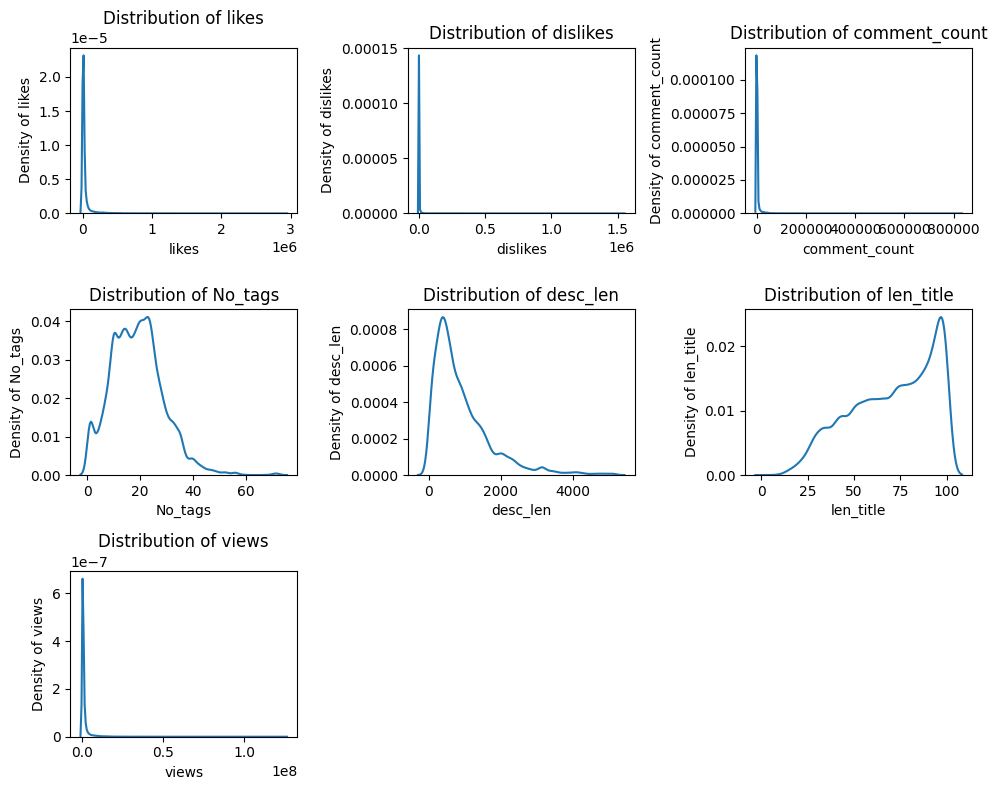

In [14]:
# Hisplot function implementation
plot_dynamic_hisplots_kdeplots(df=translated_df, col_series=nums_cols, plot_type="kdeplot", ncols=3, figsize=(10, 8))

In [17]:
# Boxplot analysis
def plot_dynamic_boxplots_violinplots(df, col_series, plot_type='boxplot', ncols=6, figsize=(26, 18), orientation='v', hue=None):
    """
    Creates a dynamic grid of either boxplots or violin plots for multiple numerical columns.

    Parameters:
    ----------
    df : pandas.DataFrame
        The DataFrame containing the data to plot.
    col_series : list of str
        List of column names to include in the plots.
    plot_type : str, optional, default='boxplot'
        Type of plot to generate. Options are 'boxplot' or 'violinplot'.
    ncols : int, optional, default=6
        Number of columns in the subplot grid. Adjust this value to change grid width.
    figsize : tuple, optional, default=(26, 18)
        Size of the figure to control plot dimensions.
    orientation : str, optional, default='v'
        Orientation of the plots. Use 'v' for vertical and 'h' for horizontal.
    hue : str, optional, default=None
        Column name to use for color encoding. Creates separate plots for each category.

    Returns:
    -------
    None
        Displays a grid of plots.

    Examples:
    --------
    >>> # Create vertical boxplots
    >>> plot_dynamic_boxplots_violinplots(df, ['col1', 'col2'], plot_type='boxplot', orientation='v')

    >>> # Create horizontal violin plots with categorical splitting
    >>> plot_dynamic_boxplots_violinplots(df, ['col1', 'col2'], plot_type='violinplot',
                                        orientation='h', hue='category')
    """
    # Validate plot_type parameter
    if plot_type not in ['boxplot', 'violinplot']:
        raise ValueError("plot_type must be either 'boxplot' or 'violinplot'")

    # Calculate required number of rows based on number of plots and specified columns
    num_plots = len(col_series)
    nrows = math.ceil(num_plots / ncols)

    # Adjust figsize based on orientation
    if orientation == 'h':
        figsize = (figsize[1], figsize[0])  # Swap width and height for horizontal plots

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    
    # Convert ax to array if it's a single subplot
    if num_plots == 1:
        ax = np.array([ax])
    else: 
        ax = ax.flatten()  # Flatten the axes array for easy indexing

    # Generate plots for each column
    for i, col in enumerate(col_series):
        if plot_type == 'boxplot':
            if orientation == 'v':
                sns.boxplot(data=df, ax=ax[i], y=col, orient='v', hue=hue)
                ax[i].set_title(f'Boxplot of {col}')
            else:  # orientation == 'h'
                sns.boxplot(data=df, ax=ax[i], x=col, orient='h', hue=hue)
                ax[i].set_title(f'Boxplot of {col}')
        else: # violinplot
            if orientation == 'v':
                sns.violinplot(data=df, ax=ax[i], y=col, orient='v', hue=hue, inner_kws=dict(box_width=15, whis_width=2))
                ax[i].set_title(f'Violinplot of {col}')
            else:  # orientation == 'h'
                sns.violinplot(data=df, ax=ax[i], x=col, orient='h', hue=hue, inner_kws=dict(box_width=15, whis_width=2))
                ax[i].set_title(f'Violinplot of {col}')

    # Remove any unused subplots if total subplots exceed columns in cols
    for j in range(num_plots, len(ax)):
        fig.delaxes(ax[j])

    plt.tight_layout()  # Adjust layout to avoid overlap
    plt.show()

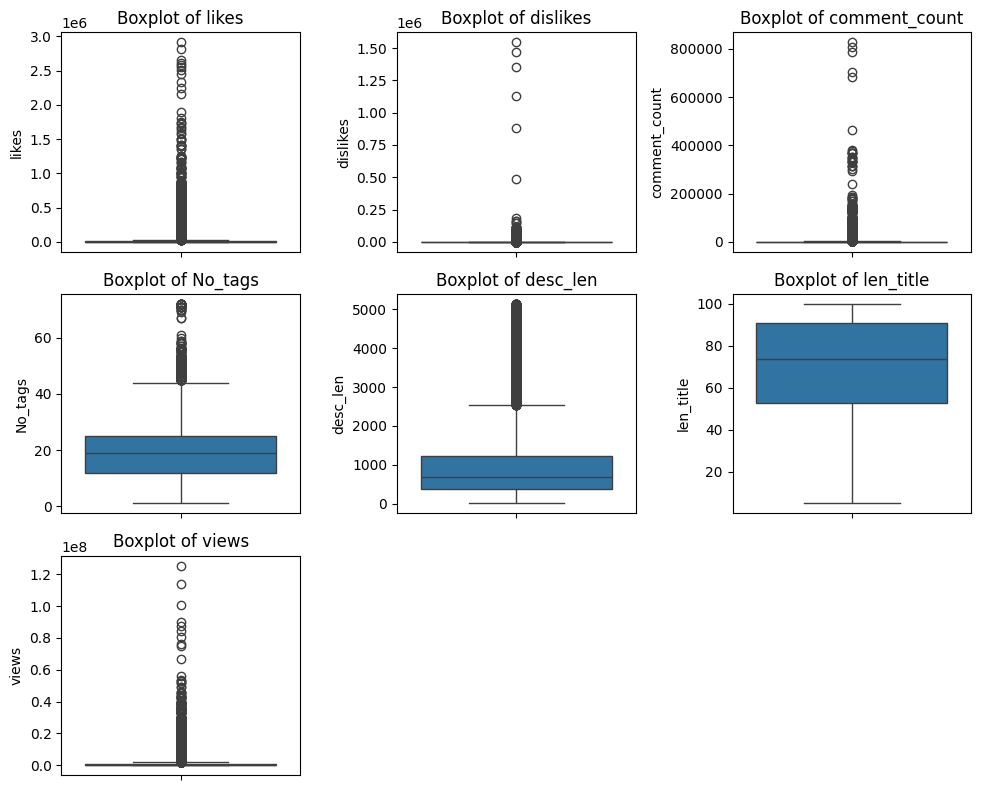

In [16]:
# Boxplot function implementation
plot_dynamic_boxplots_violinplots(translated_df, col_series=nums_cols, ncols=3, figsize=(10, 8), orientation='v')

In [18]:
# Detect outliers in dataframe using IQR or Z-Score method
def outlier_detection(df, col_series, method='iqr', threshold=3):
    """
    Function to detect outliers in a dataframe using either the IQR or Z-Score method.
    
    Parameters:
    -----------
    df : pd.DataFrame 
        The dataframe containing the data.
    col_series : list of str
        List of column names to include in the analysis.
    method : str, optional (default='iqr')
        The method to use for outlier detection.
        Valid options are:
        - 'iqr': Interquartile Range method (default)
        - 'zscore': Z-Score method
    threshold : float, optional (default=3)
        For IQR method: multiplier for IQR to determine outlier bounds (default is 1.5)
        For Z-Score method: number of standard deviations to use as the outlier cutoff
    
    Returns:
    --------
    pd.DataFrame
        A summary dataframe containing:
        - Column Name: Name of the analyzed column
        - Outlier Exist: Boolean indicating if outliers were found
        - Lower Limit: Lower bound for outlier detection
        - Upper Limit: Upper bound for outlier detection
        - Outlier Data: Number of outliers detected
        - Non-Outlier Data: Number of non-outliers
        - Outlier Percentage (%): Percentage of data points identified as outliers
    
    Examples:
    --------
    # Using IQR method
    result_iqr = outlier_detection(df, ['column1', 'column2'], method='iqr')
    
    # Using Z-Score method
    result_zscore = outlier_detection(df, ['column1', 'column2'], method='zscore', threshold=3)
    """
    # Input validation
    if method.lower() not in ['iqr', 'zscore']:
        raise ValueError("Method must be either 'iqr' or 'zscore'")
    
    print(f'Amount of Rows: {len(df)}')
    
    # Initialize lists to store results
    outlier = []  # Store the number of outlier rows per column
    no_outlier = []  # Store the number of non-outlier rows per column
    is_outlier = []  # Boolean indicating whether any outliers exist in the column
    low_bound = []  # Lower bound for outliers
    high_bound = []  # Upper bound for outliers
    outlier_percentage = []  # Percentage of outliers for each column

    # Start with all rows marked as True (non-outliers) in the cumulative filter
    filtered_entries = np.array([True] * len(df))

    # Loop through each column
    for col in col_series:
        if method.lower() == 'iqr':
            # IQR method
            Q1 = df[col].quantile(0.25)  # First quartile (25th percentile)
            Q3 = df[col].quantile(0.75)  # Third quartile (75th percentile)
            IQR = Q3 - Q1  # Interquartile range
            lower_bound = Q1 - (IQR * 1.5)  # Lower bound for outliers
            upper_bound = Q3 + (IQR * 1.5)  # Upper bound for outliers

            # Create a filter that identifies non-outliers for the current column
            filter_outlier = ((df[col] >= lower_bound) & (df[col] <= upper_bound))
            
        elif method.lower() == 'zscore':
            # Z-Score method
            
            # Calculate Z-Scores
            z_scores = np.abs(stats.zscore(df[col]))

            # Create a filter that identifies non-outliers
            filter_outlier = (z_scores < threshold)
            
            mean = df[col].mean() # mean of the column
            std = df[col].std() # standard deviation of the column
            lower_bound = mean - (threshold * std) # Lower bound for outliers
            upper_bound = mean + (threshold * std) # Upper bound for outliers

        # Calculate statistics
        outlier_count = len(df[~filter_outlier]) # Count of outliers
        non_outlier_count = len(df[filter_outlier]) # Count of non-outliers
        outlier_pct = round((outlier_count / len(df)) * 100, 2) # Percentage of outliers

        # Store results
        outlier.append(outlier_count)
        no_outlier.append(non_outlier_count)
        is_outlier.append(df[col][~filter_outlier].any()) # Whether any outliers exist
        low_bound.append(lower_bound)
        high_bound.append(upper_bound)
        outlier_percentage.append(outlier_pct)

        # Update cumulative filter
        filtered_entries = filtered_entries & filter_outlier

    # Print summary statistics
    print(f'Amount of Outlier Rows (Across All Columns): {len(df[~filtered_entries])}')
    print(f'Amount of Non-Outlier Rows (Across All Columns): {len(df[filtered_entries])}')
    print(f'Percentage of Outliers: {round(len(df[~filtered_entries]) / len(df) * 100, 2)}%')
    print()

    # Create and return summary dataframe
    check_outliers = pd.DataFrame({
        'Column Name': col_series,
        'Outlier Exist': is_outlier,
        'Lower Limit': low_bound,
        'Upper Limit': high_bound,
        'Outlier Data': outlier,
        'Non-Outlier Data': no_outlier,
        'Outlier Percentage (%)': outlier_percentage
    })

    return check_outliers

In [18]:
# Outliers cheking with IQR method function implementation
outlier_summary = outlier_detection(translated_df, col_series=nums_cols, method='iqr')
outlier_summary

Amount of Rows: 36791
Amount of Outlier Rows (Across All Columns): 9092
Amount of Non-Outlier Rows (Across All Columns): 27699
Percentage of Outliers: 24.71%



Column Name  Outlier Exist  Lower Limit  Upper Limit  Outlier Data  \
0          likes           True    -18945.00     33919.00          5441   
1       dislikes           True     -1275.50      2416.50          4417   
2  comment_count           True     -1764.25      3161.75          4689   
3        No_tags           True        -7.50        44.50           455   
4       desc_len           True      -935.50      2540.50          1829   
5      len_title          False        -4.00       148.00             0   
6          views           True   -895937.25   1828172.75          4165   

   Non-Outlier Data  Outlier Percentage (%)  
0             31350                   14.79  
1             32374                   12.01  
2             32102                   12.74  
3             36336                    1.24  
4             34962                    4.97  
5             36791                    0.00  
6             32626                   11.32

### Categorical Columns

In [19]:
# Categorical Feature Counts
for col in cats_cols:
    print(f'''Value count column : {col}:''')
    print(translated_df[col].value_counts())
    print()

Value count column : title:
title
Mission: Impossible - Fallout (2018) - Official Trailer - Paramount Pictures                           19
Sanju | Official Teaser | Ranbir Kapoor | Rajkumar Hirani                                              16
Nandhini | Today @ 9 pm | Sun TV                                                                       15
Sanju | Official Trailer | Ranbir Kapoor | Rajkumar Hirani | Releasing on 29th June                    14
Kasthooriman || General Promo || Mon to Sat at 8:30 PM || Asianet                                      14
                                                                                                       ..
Types of Singers | MostlySane                                                                           1
Patas | Yadamma Raju & Bavana Performance | 21st February 2018  | ETV Plus                              1
SSC CHSL 2017 Exam Preparation Strategy                                                                 1
Posani Krish

From that information we know that there is something wrong with the dataset since the `title`, `tags`, and `description`. Since they have values more than one, meaning that potentially they have duplicated values or some other cases that require further checking.

In [20]:
# Check for duplicated rows in the translated dataset
translated_df.duplicated().sum()

4106

Let's try to further inspect several text column, starting with `title` column.

In [21]:
# Inspecting for potential duplicate values in title column
title_duplicated_amount_example = translated_df[translated_df["title"] == "Mission: Impossible - Fallout (2018) - Official Trailer - Paramount Pictures"].duplicated().sum()
print(f"Amount of duplicated values for highest count of title: {title_duplicated_amount_example}")

translated_df[translated_df["title"] == "Mission: Impossible - Fallout (2018) - Official Trailer - Paramount Pictures"]

Amount of duplicated values for highest count of title: 5


trending_date                                              title  \
19229    2018-02-06  Mission: Impossible - Fallout (2018) - Officia...   
19347    2018-02-07  Mission: Impossible - Fallout (2018) - Officia...   
19439    2018-02-07  Mission: Impossible - Fallout (2018) - Officia...   
19482    2018-02-08  Mission: Impossible - Fallout (2018) - Officia...   
19595    2018-02-08  Mission: Impossible - Fallout (2018) - Officia...   
19642    2018-02-09  Mission: Impossible - Fallout (2018) - Officia...   
19830    2018-02-10  Mission: Impossible - Fallout (2018) - Officia...   
20025    2018-02-11  Mission: Impossible - Fallout (2018) - Officia...   
32430    2018-05-17  Mission: Impossible - Fallout (2018) - Officia...   
32535    2018-05-17  Mission: Impossible - Fallout (2018) - Officia...   
32575    2018-05-18  Mission: Impossible - Fallout (2018) - Officia...   
32690    2018-05-18  Mission: Impossible - Fallout (2018) - Officia...   
32734    2018-05-19  Mission: Impossible - Fallout (2018) - Officia...   
32836    2018-05-19  Mission: Impossible - Fallout (2018) - Officia...   
32878    2018-05-20  Mission: Impossible - Fallout (2018) - Officia...   
32983    2018-05-20  Mission: Impossible - Fallout (2018) - Officia...   
33043    2018-05-21  Mission: Impossible - Fallout (2018) - Officia...   
33151    2018-05-21  Mission: Impossible - Fallout (2018) - Officia...   
33259    2018-05-22  Mission: Impossible - Fallout (2018) - Officia...   

            channel_title category_id  \
19229  Paramount Pictures           1   
19347  Paramount Pictures           1   
19439  Paramount Pictures           1   
19482  Paramount Pictures           1   
19595  Paramount Pictures           1   
19642  Paramount Pictures           1   
19830  Paramount Pictures           1   
20025  Paramount Pictures           1   
32430  Paramount Pictures           1   
32535  Paramount Pictures           1   
32575  Paramount Pictures           1   
32690  Paramount Pictures           1   
32734  Paramount Pictures           1   
32836  Paramount Pictures           1   
32878  Paramount Pictures           1   
32983  Paramount Pictures           1   
33043  Paramount Pictures           1   
33151  Paramount Pictures           1   
33259  Paramount Pictures           1   

                                                    tags   likes  dislikes  \
19229  Official Trailer|"Movie"|"New Movie"|"Film"|"O...  165512      2819   
19347  Official Trailer|"Movie"|"New Movie"|"Film"|"O...  190133      3433   
19439  Official Trailer|"Movie"|"New Movie"|"Film"|"O...  190133      3433   
19482  Official Trailer|"Movie"|"New Movie"|"Film"|"O...  203998      3741   
19595  Official Trailer|"Movie"|"New Movie"|"Film"|"O...  203998      3741   
19642  Official Trailer|"Movie"|"New Movie"|"Film"|"O...  212387      3925   
19830  Official Trailer|"Movie"|"New Movie"|"Film"|"O...  216754      4049   
20025  Official Trailer|"Movie"|"New Movie"|"Film"|"O...  219445      4127   
32430  Official Trailer|"Movie"|"New Movie"|"Film"|"O...   90354      1903   
32535  Official Trailer|"Movie"|"New Movie"|"Film"|"O...   90354      1903   
32575  Official Trailer|"Movie"|"New Movie"|"Film"|"O...  129863      3645   
32690  Official Trailer|"Movie"|"New Movie"|"Film"|"O...  129866      3645   
32734  Official Trailer|"Movie"|"New Movie"|"Film"|"O...  146456      4273   
32836  Official Trailer|"Movie"|"New Movie"|"Film"|"O...  146456      4273   
32878  Official Trailer|"Movie"|"New Movie"|"Film"|"O...  155469      4650   
32983  Official Trailer|"Movie"|"New Movie"|"Film"|"O...  155469      4650   
33043  Official Trailer|"Movie"|"New Movie"|"Film"|"O...  159845      4852   
33151  Official Trailer|"Movie"|"New Movie"|"Film"|"O...  159845      4852   
33259  Official Trailer|"Movie"|"New Movie"|"Film"|"O...  162079      4964   

       comment_count comments_disabled ratings_disabled  \
19229          13060             False            False   
19347          14747     

- Upon further examination of the potential duplication of title values, we gain new insights into how the data was collected in this case. First, we can see that the videos are exactly the same but are recorded at different timestamps of the `trending_date` (this is confirmed by the same `publish_time`). 

- Unfortunately we don't really have the proper definition of the trending condition here, whether the trending information (ex: **#1 on Trending** --> usually beside the title) in youtube should be on top 10 or something, but for now we will just stick with the condition that it have that trending label information no matter what the trending rank is.

- Second important insight is that we get to see that there is a **reupload** case here, the publish_time have two different values which is first in 2018-02-05 00:16:37 and second in 2018-05-16 06:59:59.

> - **Solution**: The solution that we will implement here is that we will drop the duplicates based on the `title` and `trending_time` column and keep the last record (most recent). Since keeping them will affect our analysis, we will handle it directly in this EDA stage.

In [22]:
# Inspecting for potential duplicate values in tags column
check_condition_tags = 'flowers tv|"uppum mulakum"|"uppum"|"biju sopanam"|"Balanchandran"|"Neelima"|"juhi rustagi"|"flower tv comedy"|"flower tv malayalam"|"balanchandran"|"entertainment"|"best comedy serial malayalam"|"s p sreekumar"|"college campus comedy"|"marimayam"|"sneha sreekumar"|"programme"|"moosa"|"m80 moosa"|"funny"|"flower tv comedy night"|"malayalam comedy"|"+uppum mulakum"'
tags_duplicated_amount_example = translated_df[translated_df["tags"] == check_condition_tags].duplicated().sum()
print(f"Amount of duplicated values for highest count of tags: {tags_duplicated_amount_example}")

translated_df[translated_df["tags"] == check_condition_tags]

Amount of duplicated values for highest count of tags: 66


trending_date                          title   channel_title  \
8290     2017-11-14  Uppum Mulakum│Flowers│EP# 473  Flowers Comedy   
8385     2017-11-15  Uppum Mulakum│Flowers│EP# 474  Flowers Comedy   
8532     2017-11-16  Uppum Mulakum│Flowers│EP# 474  Flowers Comedy   
8652     2017-11-17  Uppum Mulakum│Flowers│EP# 476  Flowers Comedy   
8806     2017-11-18  Uppum Mulakum│Flowers│EP# 477  Flowers Comedy   
...             ...                            ...             ...   
36491    2018-06-12  Uppum Mulakum│Flowers│EP# 622  Flowers Comedy   
36510    2018-06-13  Uppum Mulakum│Flowers│EP# 623  Flowers Comedy   
36611    2018-06-13  Uppum Mulakum│Flowers│EP# 623  Flowers Comedy   
36656    2018-06-14  Uppum Mulakum│Flowers│EP# 624  Flowers Comedy   
36763    2018-06-14  Uppum Mulakum│Flowers│EP# 624  Flowers Comedy   

      category_id                                               tags  likes  \
8290           24  flowers tv|"uppum mulakum"|"uppum"|"biju sopan...   3978   
8385           24  flowers tv|"uppum mulakum"|"uppum"|"biju sopan...   2327   
8532           24  flowers tv|"uppum mulakum"|"uppum"|"biju sopan...   2791   
8652           24  flowers tv|"uppum mulakum"|"uppum"|"biju sopan...   2506   
8806           24  flowers tv|"uppum mulakum"|"uppum"|"biju sopan...   2337   
...           ...                                                ...    ...   
36491          24  flowers tv|"uppum mulakum"|"uppum"|"biju sopan...   9297   
36510          24  flowers tv|"uppum mulakum"|"uppum"|"biju sopan...   5227   
36611          24  flowers tv|"uppum mulakum"|"uppum"|"biju sopan...   5227   
36656          24  flowers tv|"uppum mulakum"|"uppum"|"biju sopan...   6686   
36763          24  flowers tv|"uppum mulakum"|"uppum"|"biju sopan...   6686   

       dislikes  comment_count comments_disabled ratings_disabled  \
8290        248            848             False            False   
8385        201            342             False            False   
8532        286            410             False            False   
8652        230            514             False            False   
8806        229            346             False            False   
...         ...            ...               ...              ...   
36491      1038           1932             False            False   
36510       497            798             False            False   
36611       497            798             False            False   
36656       649           1221             False            False   
36763       649           1221             False            False   

      video_error_or_removed  \
8290                   False   
8385                   False   
8532                   False   
8652                   False   
8806                   False   
...                      ...   
36491                  False   
36510                  False   
36611                  False   
36656                  False   
36763                  False   

                                             description  No_tags  desc_len  \
8290   Watch Full Episode Here :- \n\nWatch Flowers T...       23       295   
8385   Watch Full Episode Here :- \n\nWatch Flowers T...       23       295   
8532   Watch Full Episode Here :- \n\nWatch Flowers T...       23       295   
8652   Watch Full Episode Here :- \n\nWatch Flowers T...       23       295   
8806   Watch Full Episode Here :- \n\nWatch Flowers T...       23       295   
...                                                  ...      ...       ...   
36491  Flowers - A R Rahman Show,Book your Tickets He...       23       352   
36510  Flowers - A R Rahman Show,Book your Tickets He...       23       352   
36611  Flowers - A R Rahman Show,Book your Tickets He...       23       352   
36656  Flowers - A R Rahman Show,Book your Tickets He...       23       352   
36763  Flowers - A R Rahman Show,Book your Tickets He...       23       352   

       len_title    views  publish_time_fixed  
8290 

The duplicated problem of the `tags` column is the same as the `title` column so we can just implement the solution for the `title` column to the `tags` column as well later. Meaning that we wont need to further checking on the `description` since the case will probably the same as those 2. We will now implement the solution of dropping the duplicated rows and keep the most recent record.

In [23]:
# Check amount of rows before dropping duplicates
print(f"Shape before removing duplicates: {translated_df.shape}")

# Identify columns to check for duplicates (title and publish_time_fixed)
duplicate_check_columns = ['title', 'publish_time_fixed']

# Drop duplicates keeping last record (most recent)
translated_df = translated_df.drop_duplicates(subset=duplicate_check_columns, keep='last')

# Reset index after dropping duplicates
translated_df.reset_index(drop=True, inplace=True)

# Print shape to confirm changes
print(f"Shape after removing duplicates: {translated_df.shape}")

Shape before removing duplicates: (36791, 17)
Shape after removing duplicates: (16636, 17)


Let's try recheck for the title column that have the highest value count before

In [24]:
# Inspecting for potential duplicate values in title column
title_duplicated_amount_example = translated_df[translated_df["title"] == "Mission: Impossible - Fallout (2018) - Official Trailer - Paramount Pictures"].duplicated().sum()
print(f"Amount of duplicated values for highest count of title: {title_duplicated_amount_example}")

translated_df[translated_df["title"] == "Mission: Impossible - Fallout (2018) - Official Trailer - Paramount Pictures"]

Amount of duplicated values for highest count of title: 0


trending_date                                              title  \
9755     2018-02-11  Mission: Impossible - Fallout (2018) - Officia...   
15292    2018-05-22  Mission: Impossible - Fallout (2018) - Officia...   

            channel_title category_id  \
9755   Paramount Pictures           1   
15292  Paramount Pictures           1   

                                                    tags   likes  dislikes  \
9755   Official Trailer|"Movie"|"New Movie"|"Film"|"O...  219445      4127   
15292  Official Trailer|"Movie"|"New Movie"|"Film"|"O...  162079      4964   

       comment_count comments_disabled ratings_disabled  \
9755           16602             False            False   
15292          12016             False            False   

      video_error_or_removed  \
9755                   False   
15292                  False   

                                             description  No_tags  desc_len  \
9755   Watch the official trailer for Mission: Imposs...       28      1495   
15292  Some missions are not a choice. Watch the offi...       31      1798   

       len_title     views  publish_time_fixed  
9755          76  15187622 2018-02-05 00:16:37  
15292         76  14800528 2018-05-16 06:59:59

> The duplicated values are gone now even though we need to sacrifice around 50% of our analysis, but now we will have more accurate representation of the data.

In [19]:
# Countplot analysis
def plot_dynamic_countplot(df, col_series, ncols=6, figsize=(26, 18), stat='count', hue=None, order=None):
    """
    Plots a dynamic grid of countplot for a list of categorical columns from a DataFrame.

    Parameters:
    ----------
    df : pandas.DataFrame
        The DataFrame containing the data to plot.
    col_series : list of str
        List of column names to include in the countplots.
    ncols : int, optional, default=6
        Number of columns in the subplot grid. Adjust this value to change grid width.
    figsize : tuple, optional, default=(26, 18)
        Size of the figure to control plot dimensions.
    stat : str, optional, default='count'
        The statistic to compute for the bars
    hue : str, optional, default=None
        Column name to use for color encoding
    order : list, optional, default=None
        Specific ordering for the categorical variables

    Returns:
    -------
    None
        Displays a grid of countplots.
    """

    # Calculate required number of rows based on number of plots and specified columns
    num_plots = len(col_series)
    nrows = math.ceil(num_plots / ncols)

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    
    # Convert ax to array if it's a single subplot
    if num_plots == 1:
        ax = np.array([ax])
    else: 
        ax = ax.flatten()  # Flatten the axes array for easy indexing

    # Generate countplot for each column
    for i, col in enumerate(col_series):
        # Get the specific order for this column if provided
        if isinstance(order, list):
            current_order = order[i].tolist() if hasattr(order[i], 'tolist') else order[i]
        else:
            current_order = None

        sns.countplot(data=df,
                     ax=ax[i],
                     x=col,
                     stat=stat,
                     hue=hue,
                     order=current_order)
        ax[i].set_title(f'Countplot of {col}')
        ax[i].set_ylabel(f'Count of {col}')
        ax[i].set_xlabel(f'{col}')

        # Add value labels on top of bars
        for p in ax[i].patches:
            ax[i].annotate(
                f'{int(p.get_height())}',  # The text to display
                (p.get_x() + p.get_width() / 2., p.get_height()),  # The position
                ha='center',  # Horizontal alignment
                va='bottom'   # Vertical alignment
            )

    # Remove any unused subplots if total subplots exceed columns in cols
    for j in range(num_plots, len(ax)):
        fig.delaxes(ax[j])

    plt.tight_layout()  # Adjust layout to avoid overlap
    plt.show()

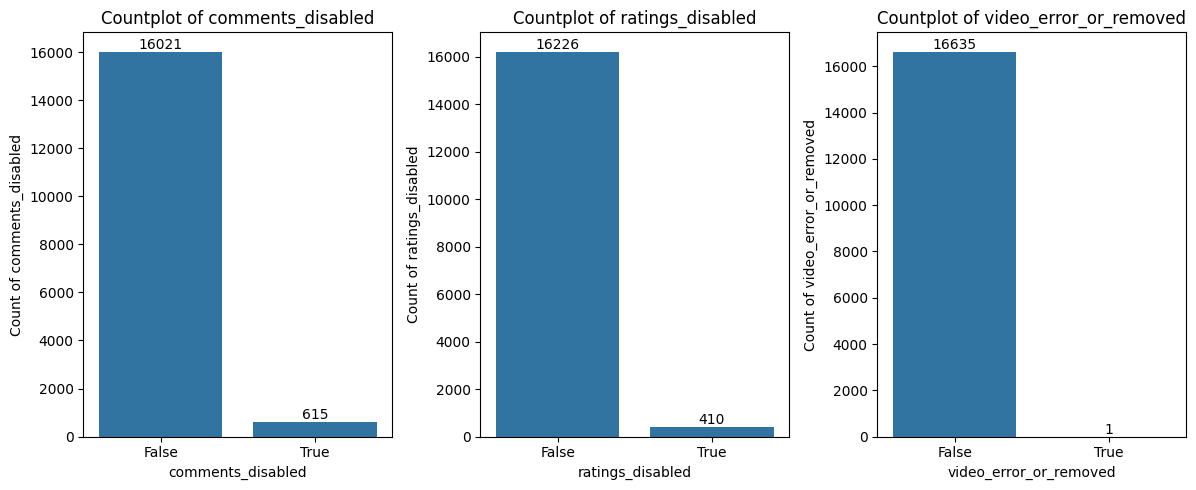

In [26]:
# Countplot function implementation (for few unique values columns)
cats_cols_few = ['comments_disabled', 'ratings_disabled', 'video_error_or_removed']
plot_dynamic_countplot(df=translated_df, col_series=cats_cols_few, ncols=5, figsize=(20, 5))

There is a significant imbalance in these boolean categorical values, so it will be addressed further, possibly through feature scaling later on if we want to keep them or just drop them altogether especially the `video_error_or_removed` column because of the extreme imbalance here.

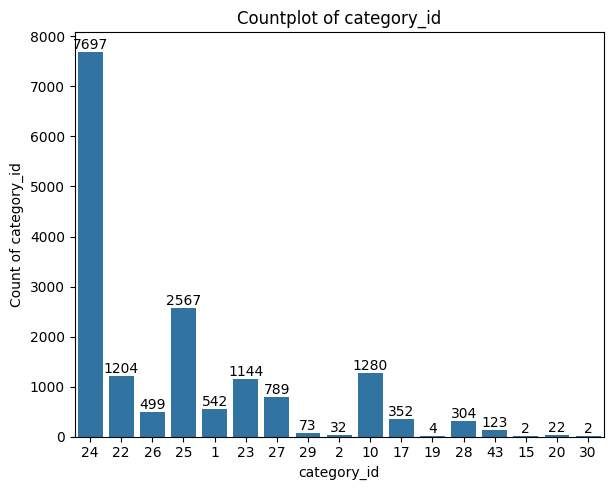

In [27]:
# Countplot function implementation (for many unique values columns)
cats_cols_many = ['category_id']
plot_dynamic_countplot(df=translated_df, col_series=cats_cols_many, ncols=5, figsize=(28, 5))

### Quick Re-Check on Numerical Columns After Dropping Duplicates 

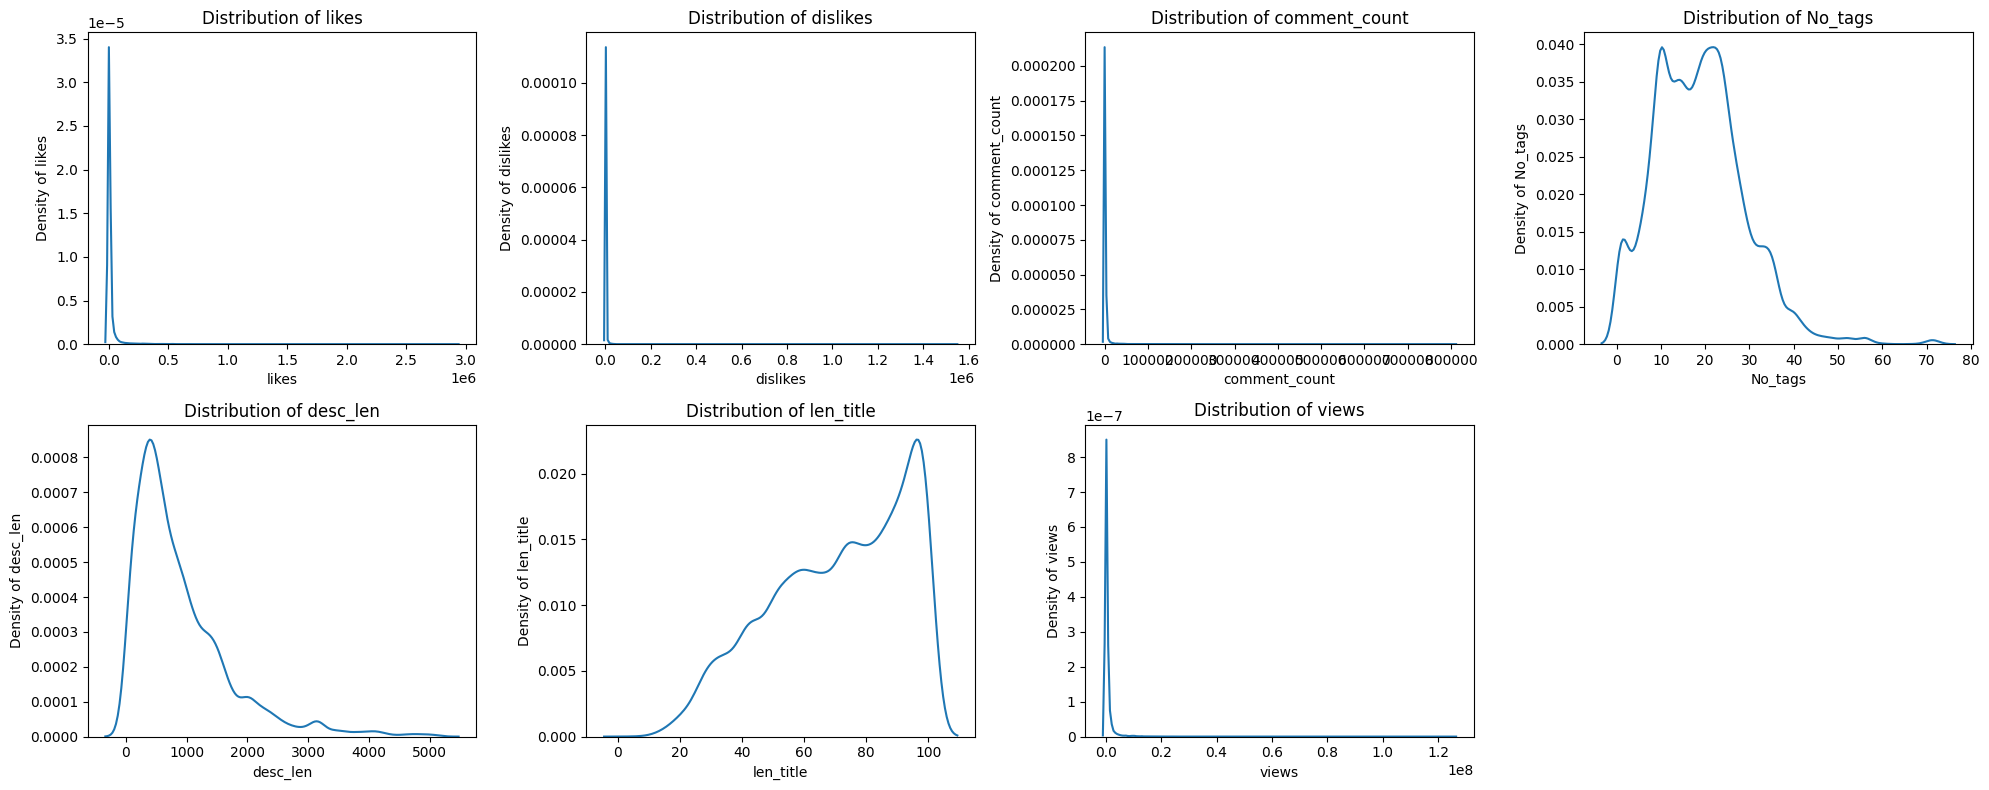

In [28]:
# Kdeplot analysis
plot_dynamic_hisplots_kdeplots(df=translated_df, col_series=nums_cols, plot_type="kdeplot", ncols=4, figsize=(20, 8))

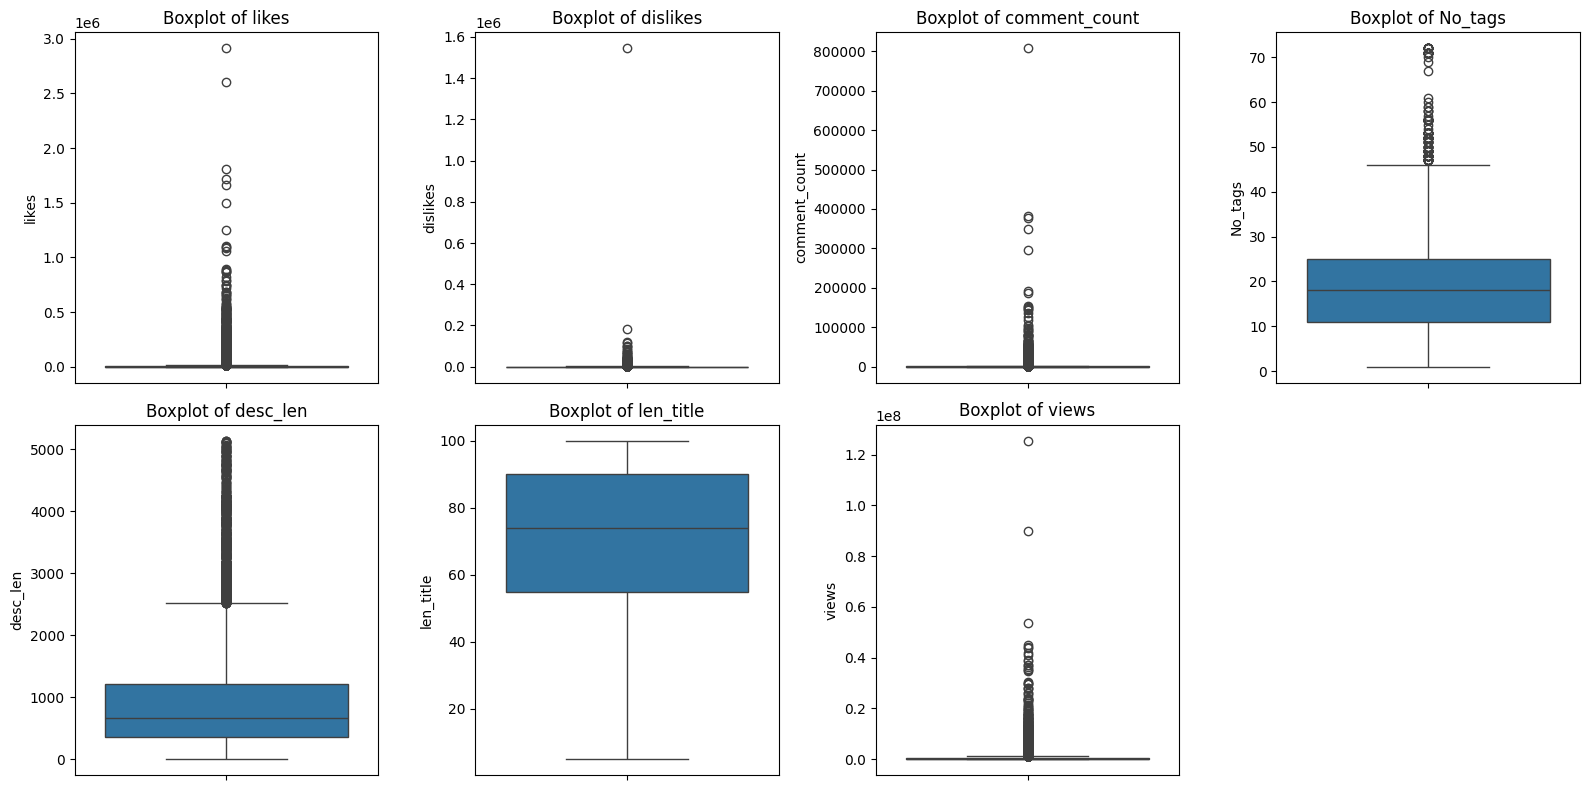

In [29]:
# Boxplot analysis
plot_dynamic_boxplots_violinplots(translated_df, col_series=nums_cols, plot_type='boxplot', ncols=4, figsize=(16, 8), orientation='v')

In [30]:
# Outliers cheking with IQR method function implementation
outlier_summary = outlier_detection(translated_df, col_series=nums_cols, method='iqr')
outlier_summary

Amount of Rows: 16636
Amount of Outlier Rows (Across All Columns): 4081
Amount of Non-Outlier Rows (Across All Columns): 12555
Percentage of Outliers: 24.53%



Column Name  Outlier Exist  Lower Limit  Upper Limit  Outlier Data  \
0          likes           True    -8442.250    15587.750          2409   
1       dislikes           True     -721.375     1391.625          1964   
2  comment_count           True     -951.000     1713.000          2117   
3        No_tags           True      -10.000       46.000           191   
4       desc_len           True     -929.500     2514.500           797   
5      len_title          False        2.500      142.500             0   
6          views           True  -577031.250  1202010.750          1867   

   Non-Outlier Data  Outlier Percentage (%)  
0             14227                   14.48  
1             14672                   11.81  
2             14519                   12.73  
3             16445                    1.15  
4             15839                    4.79  
5             16636                    0.00  
6             14769                   11.22

The underlying distribution shape are still the same.

## Bivariate & Multivariate Analysis

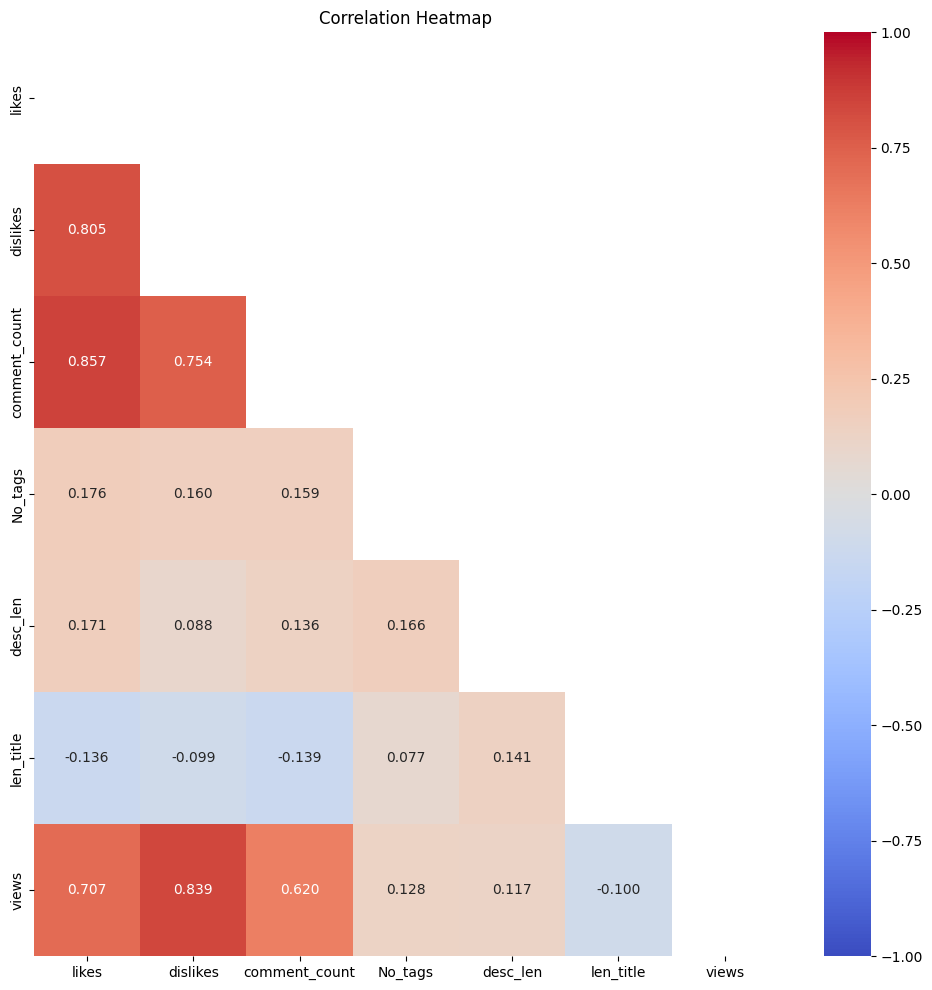

In [31]:
# Create a mask for the upper triangle
plt.figure(figsize=(12,12))
numeric_df = translated_df.select_dtypes(include=['int64', 'float64'])
mask = np.triu(np.ones_like(numeric_df.corr(), dtype=bool))

# Plot the heatmap
sns.heatmap(data = translated_df.corr(numeric_only=True, method='spearman'), mask=mask, cmap='coolwarm', annot=True, fmt='.3f', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

In [20]:
# Correlation analysis in tabluar form
def calculate_regression_correlation(df, target_col, method='spearman', corr_type='both'):
    """
    Calculate and display correlation analysis and regression-specific metrics in tabular form.
    Enhanced version specifically for regression analysis tasks.

    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame containing the features and target variable
    target_col : str
        Name of the target column in the DataFrame
    method : str, optional (default='spearman')
        Correlation method to use. Options include:
        - 'pearson': standard correlation coefficient
        - 'spearman': Spearman rank correlation
        - 'kendall': Kendall Tau correlation coefficient
    corr_type : str, optional (default='both')
        Type of correlation analysis to perform:
        - 'feature_feature': correlations between all features
        - 'feature_target': correlations between features and target
        - 'both': display both feature-feature and feature-target correlations

    Returns:
    --------
    tuple or pandas.DataFrame
        If corr_type is 'both':
            Returns a tuple (feature_feature_df, feature_target_df)
        Otherwise:
            Returns a single DataFrame containing the correlation analysis results
    """
    
    # Input validation for correlation type
    if corr_type not in ['feature_feature', 'feature_target', 'both']:
        raise ValueError("corr_type must be either 'feature_feature', 'feature_target', or 'both'")
    
    def get_feature_feature_corr():
        """
        Helper function to calculate feature-to-feature correlations
        """
        # Calculate correlation matrix for all numeric columns
        corr_feature = df.corr(method=method, numeric_only=True)

        # Convert correlation matrix to long format
        flat_cm = corr_feature.stack().reset_index()
        flat_cm.columns = ['A', 'B', 'Corr Value']

        # Apply filters
        flat_cm = flat_cm.loc[
            (flat_cm['A'] != flat_cm['B']) &
            (flat_cm['A'] != target_col) &
            (flat_cm['B'] != target_col)
        ]

        # Add correlation type and convert to absolute values
        flat_cm['Corr Type'] = flat_cm['Corr Value'].apply(lambda x: 'Positive' if x >= 0 else 'Negative')
        flat_cm['Corr Value'] = flat_cm['Corr Value'].abs()
        
        # Sort and remove duplicates
        flat_cm = flat_cm.sort_values(by='Corr Value', ascending=False, ignore_index=True)
        redundant_cm = flat_cm.drop_duplicates(subset=['Corr Value', 'Corr Type']).reset_index(drop=True)
        
        print("Correlation Between Features:")
        display(redundant_cm.iloc[:15].reset_index(drop=True))
        return redundant_cm
    
    def get_feature_target_corr():
        """
        Helper function to calculate feature-to-target correlations with additional regression metrics
        """
        # Initialize lists to store metrics
        features = []
        corr_values = []
        corr_types = []
        r_squared_values = []
        mae_values = []
        rmse_values = []
        mape_values = []
        p_values = []

        # Calculate metrics for each feature
        for feature in df.select_dtypes(include=np.number).columns:
            if feature != target_col:
                # Basic correlation
                corr_value = df[feature].corr(df[target_col], method=method)
                
                # R-squared (coefficient of determination)
                slope, intercept, r_value, p_value, std_err = stats.linregress(df[feature], df[target_col])
                r_squared = r_value ** 2

                # MAE
                y_pred = slope * df[feature] + intercept
                mae = np.mean(np.abs(df[target_col] - y_pred))
                
                # RMSE
                y_pred = slope * df[feature] + intercept
                rmse = np.sqrt(np.mean((df[target_col] - y_pred) ** 2))

                # MAPE
                y_pred = slope * df[feature] + intercept
                mape = np.mean(np.abs((df[target_col] - y_pred) / df[target_col])) * 100
                
                # Store results
                features.append(feature)
                corr_values.append(abs(corr_value))
                corr_types.append('Positive' if corr_value >= 0 else 'Negative')
                r_squared_values.append(r_squared)
                mae_values.append(mae)
                rmse_values.append(rmse)
                mape_values.append(mape)
                p_values.append(p_value)

        # Create DataFrame with all metrics
        corr_final = pd.DataFrame({
            'Feature': features,
            'Corr Value': corr_values,
            'Corr Type': corr_types,
            'R-squared': r_squared_values,
            'MAE': mae_values,
            'RMSE': rmse_values,
            'MAPE (%)': mape_values,
            'P-value': p_values
        })
        
        # Sort by correlation strength
        corr_final = corr_final.sort_values('Corr Value', ascending=False, ignore_index=True)

        print("\nRegression Metrics for Features vs Target:")
        display(corr_final.iloc[:15].reset_index(drop=True))
        return corr_final
    
    # Handle different correlation type requests
    if corr_type == 'feature_feature':
        return get_feature_feature_corr()
    elif corr_type == 'feature_target':
        return get_feature_target_corr()
    else:  # corr_type == 'both'
        feature_feature_df = get_feature_feature_corr()
        feature_target_df = get_feature_target_corr()
        return feature_feature_df, feature_target_df

In [33]:
# Correlation function implementation
results = calculate_regression_correlation(translated_df, target_col='views', method='spearman')

Correlation Between Features:


A              B  Corr Value Corr Type
0           likes  comment_count    0.857312  Positive
1           likes       dislikes    0.804889  Positive
2        dislikes  comment_count    0.754191  Positive
3         No_tags          likes    0.176114  Positive
4        desc_len          likes    0.170939  Positive
5         No_tags       desc_len    0.166191  Positive
6         No_tags       dislikes    0.160403  Positive
7   comment_count        No_tags    0.158657  Positive
8        desc_len      len_title    0.140839  Positive
9   comment_count      len_title    0.138974  Negative
10          likes      len_title    0.136380  Negative
11  comment_count       desc_len    0.135650  Positive
12       dislikes      len_title    0.099342  Negative
13       dislikes       desc_len    0.087667  Positive
14        No_tags      len_title    0.076582  Positive


Regression Metrics for Features vs Target:


Feature  Corr Value Corr Type  R-squared            MAE  \
0       dislikes    0.839436  Positive   0.337720  670228.172409   
1          likes    0.707326  Positive   0.710409  445694.218530   
2  comment_count    0.620178  Positive   0.438328  596391.616286   
3        No_tags    0.128435  Positive   0.002798  774482.618491   
4       desc_len    0.117191  Positive   0.011004  773062.162651   
5      len_title    0.099735  Negative   0.002417  778448.248488   

           RMSE    MAPE (%)       P-value  
0  1.927860e+06  470.123386  0.000000e+00  
1  1.274815e+06  210.053436  0.000000e+00  
2  1.775399e+06  381.807215  0.000000e+00  
3  2.365627e+06  541.603128  8.703046e-12  
4  2.355873e+06  538.659116  6.306090e-42  
5  2.366079e+06  544.210483  2.233734e-10

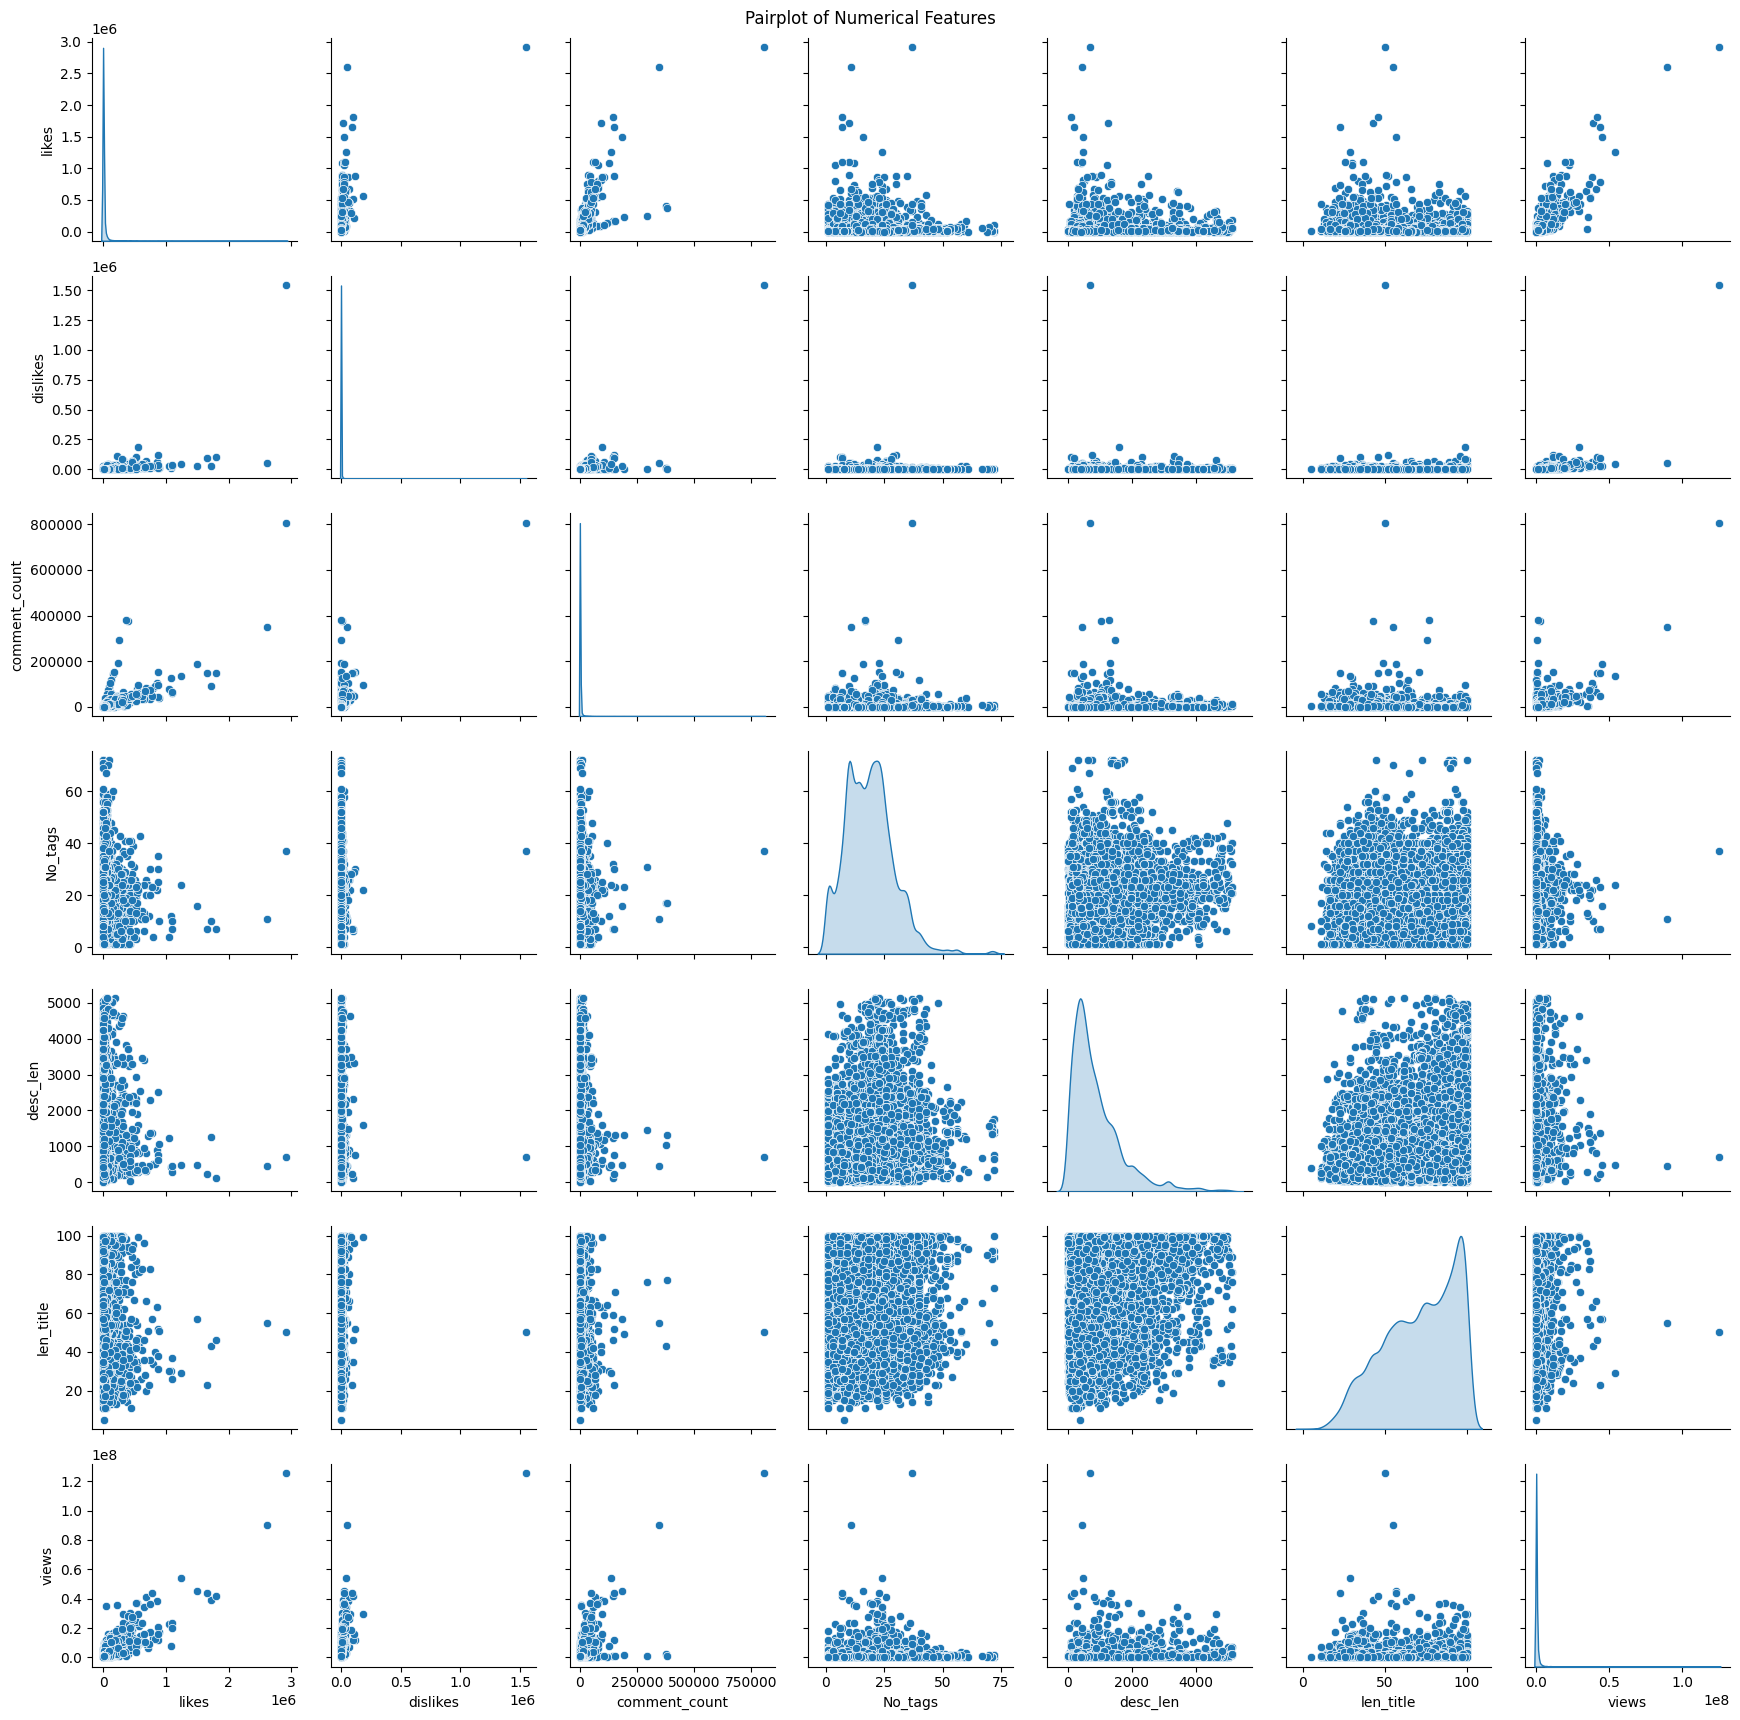

In [34]:
# Pairplot
sns.pairplot(translated_df, diag_kind='kde')
plt.suptitle('Pairplot of Numerical Features')
plt.tight_layout()
plt.show()

# **STAGE 2 : DATA PREPROCESSING**

In [35]:
change_colwidth("reset")

In [36]:
# Make a copy of original dataframe for preprocessing and encoding process
preprocessed_df = translated_df.copy()
preprocessed_df.sample(3)

trending_date                                              title  \
2554     2018-02-26             VAANI RANI - Episode 1501 - 24/02/2018   
9976     2018-02-15  Resham Singh Anmol: Nazare (Full Song) | Gupz ...   
15261    2018-05-21  Social Media Star Ep 2 | Bhuvan Bam, Rajkummar...   

              channel_title category_id  \
2554            RadaanMedia          24   
9976   T-Series Apna Punjab          10   
15261             Firstpost          25   

                                                    tags  likes  dislikes  \
2554   Vaani rani|"rani"|"Radhika in funny character"...   2059       704   
9976   resham singh anmol|"nazare"|"resham singh anmo...  50797      1732   
15261  bb ki vines|"bb ki vines latest video"|"bb ki ...  16727       401   

       comment_count comments_disabled ratings_disabled  \
2554             304             False            False   
9976             858             False            False   
15261            714             False            False   

      video_error_or_removed  \
2554                   False   
9976                   False   
15261                  False   

                                             description  No_tags  desc_len  \
2554   Subscribers Link: http://bit.ly/2qb69dZ\n\nCon...       14      3172   
9976   Presenting latest punjabi song of 2018: Nazare...       23      1079   
15261  What do India’s biggest YouTube star and India...       11       274   

       len_title    views  publish_time_fixed  
2554          51   516354 2018-02-24 16:30:01  
9976          90  1576101 2018-02-12 04:30:00  
15261         50   454438 2018-05-19 05:34:10

## Further Preprocessing on Text Features

In here we will process the text columns of `title`, `tags`, `description` to clean them and visualize the amount of each words using wordcloud.

### Text Preprocessing

In [37]:
# Import text processing class from text_preprocessing.py
from text_preprocessing import TextPreprocessor

# Initialize the text TextPreprocessor class
preprocessor = TextPreprocessor()

# Process DataFrame
columns_to_preprocess = ['title', 'tags', 'description']
preprocessed_df = preprocessor.preprocess_dataframe(preprocessed_df, columns_to_preprocess, options=None)

### Text Visualizer

Word Frequency Analysis

Top 20 words in title:
------------------------------
episode: 2492
th: 1551
song: 1234
news: 1100
full: 1097
video: 1024
tv: 1021
movie: 821
telugu: 817
serial: 619
new: 617
latest: 616
may: 611
tamil: 578
v: 578
preview: 541
march: 539
day: 508
etv: 503
january: 467

Top 20 words in tags:
------------------------------
tv: 4941
latest: 4424
movie: 4295
new: 3750
news: 3663
song: 3292
comedy: 2736
tamil: 2377
full: 1933
punjabi: 1923
video: 1910
v: 1910
serial: 1864
telugu: 1835
episode: 1755
bos: 1294
funny: 1199
live: 1145
film: 1119
hindi: 1057

Top 20 words in description:
------------------------------
u: 14129
video: 12105
news: 10969
channel: 9897
like: 8106
movie: 7830
latest: 6984
show: 6378
tv: 6144
music: 6124
song: 5305
episode: 5287
telugu: 4719
app: 4297
subscriber: 4260
update: 3969
film: 3952
entertainment: 3785
visit: 3702
india: 3514

Top 20 words in combined text:
------------------------------
news: 15732
video: 15039
u: 14208
movie: 12946


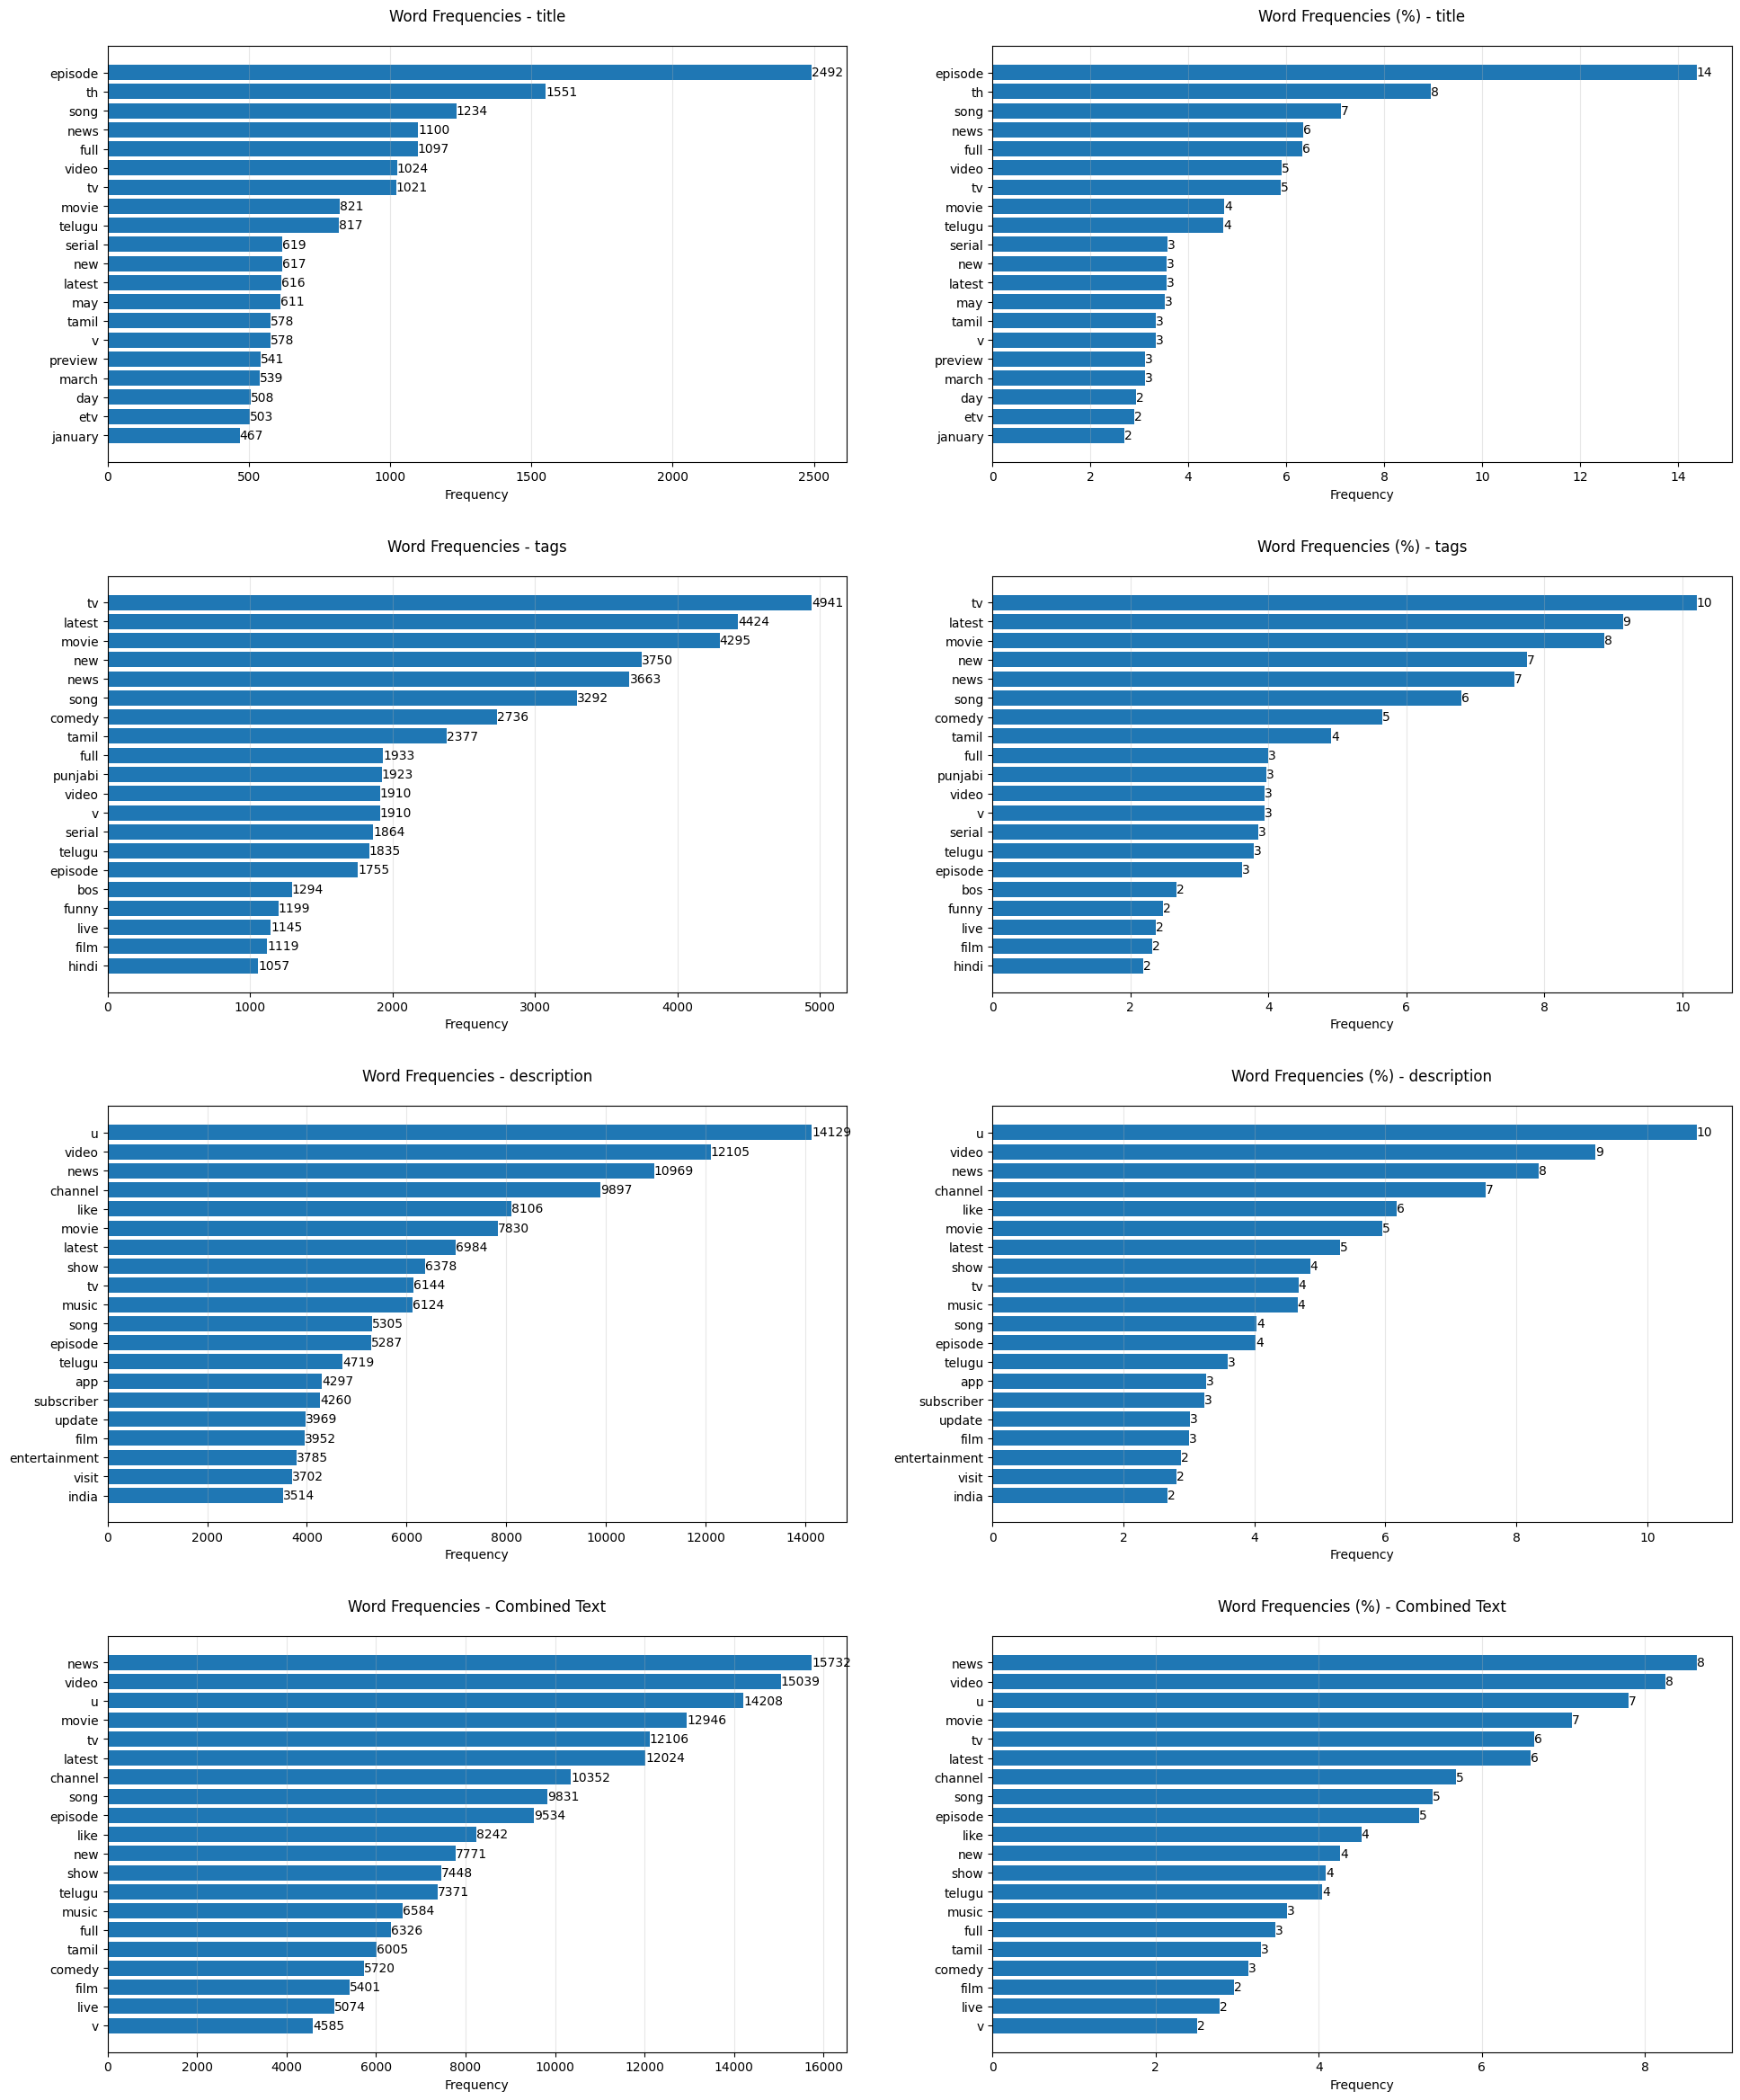

In [ ]:
# Import text visualizer class from text_wordcloud.py
from text_wordcloud import TextVisualizer

# Initialize the visualizer
visualizer = TextVisualizer()

# Select columns to analyze
columns_to_analyze = ['title', 'tags', 'description']

# Create combined columns word clouds
fig_clouds = visualizer.create_wordclouds(
    preprocessed_df,
    columns_to_analyze,
    background_color='white',
    max_words=150
)

# Save the combined columns word clouds
fig_clouds.savefig('wordclouds.png', dpi=300, bbox_inches='tight')
plt.close()

# Analyze word frequencies
fig_freq = visualizer.analyze_word_frequencies(
    preprocessed_df, 
    columns_to_analyze, 
    top_n=20
)

# Save the word frequencies figure
fig_freq.savefig('word_frequencies.png', dpi=300, bbox_inches='tight')

# Create individual word clouds
for column in columns_to_analyze:
    text = ' '.join(preprocessed_df[column].dropna().astype(str))
    fig = visualizer.create_single_wordcloud(
        text,
        # title=f'Word Cloud - {column}',
        colormap='viridis'
    )
    fig.savefig(f'wordcloud_{column}.png', dpi=300, bbox_inches='tight')
    plt.close()

Now we compare the text values before and after preprocessing.

In [39]:
# Check the values before preprocessing
translated_df[["title", "description"]].iloc[np.r_[0:3, -3:0]] # np.r_ is used to see the first and last 3 rows

title  \
0                                                                                          Pearly who bent Soub in just 30 seconds !!   
1         Lottery will be held for 8 zodiac signs, after 16th November it will rain a lot of money and love, major change in Sun sign   
2      From November 13, the lock of luck of these 9 zodiac signs will open, know if it is your zodiac sign or if it is one of these.   
16633                                                                       Bhramanam I Episode 87 - 12 June 2018 I Mazhavil Manorama   
16634                                                                Nua Bohu | Full Ep 285 | 13th June 2018 | Odia Serial - TarangTV   
16635                                                    Ee Nagaraniki Emaindi Trailer | Tharun Bhascker | Suresh Babu || #ENETrailer   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       description  
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [40]:
# Check the values after preprocessing
preprocessed_df[["title", "description"]].iloc[np.r_[0:3, -3:0]] # np.r_ is used to see the first and last 3 rows

title  \
0                                                             pearly bent soub second   
1      lottery held zodiac sign th november rain lot money love major change sun sign   
2                            november lock luck zodiac sign open know zodiac sign one   
16633                                        bhramanam episode june mazhavil manorama   
16634                                   nua bohu full ep th june odia serial tarangtv   
16635                       ee nagaraniki emaindi trailer tharun bhascker suresh babu   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         description  
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       pearly beat soub second show  
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

The text preprocessing is quite good for now, and we will move on to preprocessing for other columns.

### Text Vectorization

We will skip these for now.

#### One Column Approach

In [41]:
# # Approach for using one column
# from sklearn.feature_extraction.text import TfidfVectorizer
# from transformers import AutoTokenizer, AutoModel
# import torch

# def text_to_numerical_representation(df, column, method="tfidf", model_name=None):
#     """
#     Convert text data to numerical representation using the specified method.

#     Args:
#         df (pd.DataFrame): The input DataFrame.
#         column (str): The text column to be converted.
#         method (str): The method for conversion ("tfidf", "embedding", "transformer").
#         model_name (str, optional): Model name for pre-trained embeddings or transformer (required for these methods).

#     Returns:
#         np.ndarray: Numerical representation of the text column.
#     """
#     if method == "tfidf":
#         # TF-IDF Vectorization
#         vectorizer = TfidfVectorizer(max_features=5000)  # Adjust max_features as needed
#         return vectorizer.fit_transform(df[column].fillna("")).toarray()

#     elif method == "embedding":
#         if model_name is None:
#             raise ValueError("Please provide a model name for pre-trained embeddings.")
#         # Use a pre-trained embedding model
#         from sentence_transformers import SentenceTransformer
#         embedding_model = SentenceTransformer(model_name)
#         return np.array(embedding_model.encode(df[column].fillna("").tolist(), show_progress_bar=True))

#     elif method == "transformer":
#         if model_name is None:
#             raise ValueError("Please provide a model name for the transformer.")
#         # Use a transformer model for embeddings
#         tokenizer = AutoTokenizer.from_pretrained(model_name)
#         model = AutoModel.from_pretrained(model_name)
        
#         def encode_text(text):
#             inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
#             with torch.no_grad():
#                 outputs = model(**inputs)
#             # Use CLS token representation as the embedding
#             return outputs.last_hidden_state[:, 0, :].squeeze().numpy()

#         return np.array([encode_text(text) for text in df[column].fillna("")])

#     else:
#         raise ValueError("Invalid method. Choose from 'tfidf', 'embedding', or 'transformer'.")



In [42]:
# # Function implementation
# method = "tfidf"  # Choose "tfidf", "embedding", or "transformer"
# model_name = None  # Provide model name if using "embedding" or "transformer"

# # Convert title column to numerical representation
# numerical_representation = text_to_numerical_representation(preprocessed_df, 'title', method=method, model_name=model_name)
# print(numerical_representation.shape)

#### Multiple Columns Approach

In [43]:
# # Approach for using multiple columns at once
# from sklearn.feature_extraction.text import TfidfVectorizer
# from gensim.models import Word2Vec
# from sentence_transformers import SentenceTransformer
# from transformers import AutoTokenizer, AutoModel
# import torch

# def combine_and_encode_text(
#     df,
#     text_columns,
#     method="tfidf",
#     tfidf_max_features=1000,
#     word2vec_model=None,
#     sentence_model=None,
#     hf_model_name=None
# ):
#     """
#     Combine and encode text columns into numerical representations.

#     Args:
#         df (pd.DataFrame): DataFrame containing text columns.
#         text_columns (list): List of text column names to combine and encode.
#         method (str): Encoding method - 'tfidf', 'word2vec', 'sentence', or 'huggingface'.
#         tfidf_max_features (int): Maximum features for TF-IDF. Defaults to 1000.
#         word2vec_model: Pre-trained Word2Vec model (if using Word2Vec). Defaults to None.
#         sentence_model: Pre-trained SentenceTransformer model (if using SentenceTransformer). Defaults to None.
#         hf_model_name (str): Hugging Face model name (if using AutoTokenizer). Defaults to None.

#     Returns:
#         np.ndarray: Numerical representation of the combined text.
#     """
#     # Step 1: Combine the text columns into a single column
#     df["combined_text"] = df[text_columns].fillna("").apply(lambda row: " ".join(row), axis=1)

#     # Step 2: Apply the chosen method for numerical representation
#     # Method: TF-IDF
#     if method == "tfidf":
#         vectorizer = TfidfVectorizer(max_features=tfidf_max_features)
#         text_features = vectorizer.fit_transform(df["combined_text"]).toarray()

#     # Method: Word2Vec
#     elif method == "word2vec":
#         if not word2vec_model:
#             raise ValueError("Word2Vec model must be provided for 'word2vec' method.")
#         tokenized_text = df["combined_text"].apply(lambda x: x.split())
#         text_features = np.array([
#             np.mean(
#                 [word2vec_model.wv[word] for word in words if word in word2vec_model.wv] or [np.zeros(word2vec_model.vector_size)],
#                 axis=0
#             )
#             for words in tokenized_text
#         ])

#     # Method: SentenceTransformer
#     elif method == "sentence":
#         if not sentence_model:
#             raise ValueError("SentenceTransformer model must be provided for 'sentence' method.")
#         text_features = sentence_model.encode(df["combined_text"].tolist())

#     # Method: Hugging Face AutoTokenizer
#     elif method == "huggingface":
#         if not hf_model_name:
#             raise ValueError("Hugging Face model name must be provided for 'huggingface' method.")
        
#         # Load AutoTokenizer and AutoModel
#         tokenizer = AutoTokenizer.from_pretrained(hf_model_name)
#         model = AutoModel.from_pretrained(hf_model_name)

#         # Tokenize and encode the text data
#         encoded_input = tokenizer(
#             df["combined_text"].tolist(),
#             padding=True,
#             truncation=True,
#             max_length=512,
#             return_tensors="pt"
#         )
#         with torch.no_grad():
#             model_output = model(**encoded_input)
        
#         # Use the mean pooling of token embeddings for sentence-level representation
#         text_features = model_output.last_hidden_state.mean(dim=1).cpu().numpy()

#     else:
#         raise ValueError("Invalid method. Choose 'tfidf', 'word2vec', 'sentence', or 'huggingface'.")

#     return text_features

In [44]:
# Function implementation
# text_columns = ["title", "tags", "description"]

# TF-IDF Example
# tfidf_features = combine_and_encode_text(preprocessed_df , text_columns, method="tfidf", tfidf_max_features=1000)

# Word2Vec Example (assuming a pre-trained model is loaded as `w2v_model`)
# w2v_features = combine_and_encode_text(preprocessed_df, text_columns, method="word2vec", word2vec_model=w2v_model)

# SentenceTransformer Example (assuming a pre-trained model is loaded as `st_model`)
# st_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
# sentence_features = combine_and_encode_text(preprocessed_df, text_columns, method="sentence", sentence_model=st_model)

# Hugging Face AutoTokenizer Example
# hf_model_name = "bert-base-uncased"
# hf_features = combine_and_encode_text(preprocessed_df, text_columns, method="huggingface", hf_model_name=hf_model_name)

When to Use Each Method
- TF-IDF: Best for simple, interpretable models. Works well with traditional ML algorithms.
- Word2Vec: Suitable if you have pre-trained embeddings relevant to your domain.
- SentenceTransformer: Great for semantic understanding of text, using sentence embeddings.
- Hugging Face Models: Powerful for deep context-aware embeddings, especially for advanced use cases.

In [50]:
# # Save preprocessed data to a new CSV file
# parent_dir = os.path.abspath(os.getcwd())
# saved_path = os.path.join(parent_dir, 'data', 'preprocessed_text_dataset.csv')
# preprocessed_df.to_csv(saved_path, index=False)

## Feature Engineering

In [3]:
# Import the saved preprocessed text dataset
parent_dir = os.path.abspath(os.getcwd())
preprocessed_text_df_path = os.path.join(parent_dir, 'data', 'preprocessed_text_dataset.csv')

# Define data type mappings
dtype_mapping = {
    'category_id': str,
    'comments_disabled': str,
    'ratings_disabled': str,
    'video_error_or_removed': str
}

# Read the translated dataset with specified data types (This is done because CSV files don't preserve data type information)
feature_engineered_df = pd.read_csv(preprocessed_text_df_path, dtype=dtype_mapping, parse_dates=['trending_date', 'publish_time_fixed'])

### Date and Time Features

In [4]:
# Check data types for dates columns
feature_engineered_df[dates_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16636 entries, 0 to 16635
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   trending_date       16636 non-null  datetime64[ns]
 1   publish_time_fixed  16636 non-null  datetime64[ns]
dtypes: datetime64[ns](2)
memory usage: 260.1 KB


In [5]:
# Check the values of the dates columns
feature_engineered_df[['trending_date', 'publish_time_fixed']].head()

trending_date  publish_time_fixed
0    2017-11-14 2017-11-13 11:45:39
1    2017-11-14 2017-11-12 10:46:55
2    2017-11-14 2017-11-12 09:36:50
3    2017-11-14 2017-11-13 16:30:01
4    2017-11-14 2017-11-13 05:23:30

We could find how many days does it took for each video to stay in the trending section, and also find out at what is the publish time information so that a video will become trending.

In [6]:
# (Experimenting) Display the dataframe table as markdown
from dataframe_to_markdown_convert import df_to_markdown

markdown_table = df_to_markdown(feature_engineered_df[['trending_date', 'publish_time_fixed']].head())
print(markdown_table)

|    | trending_date       | publish_time_fixed   |
|---:|:--------------------|:---------------------|
|  0 | 2017-11-14 00:00:00 | 2017-11-13 11:45:39  |
|  1 | 2017-11-14 00:00:00 | 2017-11-12 10:46:55  |
|  2 | 2017-11-14 00:00:00 | 2017-11-12 09:36:50  |
|  3 | 2017-11-14 00:00:00 | 2017-11-13 16:30:01  |
|  4 | 2017-11-14 00:00:00 | 2017-11-13 05:23:30  |


#### Trending Duration

In [7]:
# Extract the trending duration (in hours)
feature_engineered_df['trending_duration'] = (feature_engineered_df['trending_date'] - feature_engineered_df['publish_time_fixed']).dt.seconds / 3600

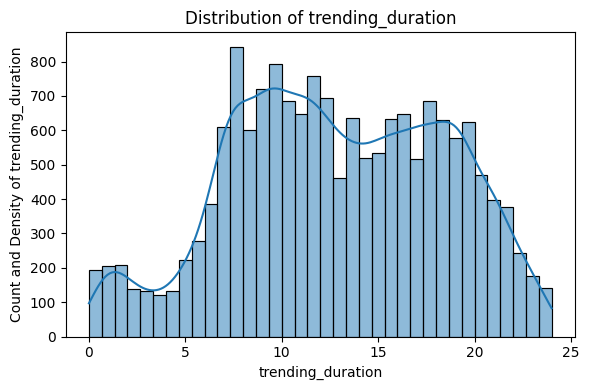

Feature    count       mean       std  min    25%        50%  \
0  trending_duration  16636.0  12.870328  5.534583  0.0  8.795  12.571944   

         75%        max      range       IQR         CV  skewness  kurtosis  
0  17.492083  23.999722  23.999722  8.697083  43.002656 -0.129658 -0.733565

In [15]:
# Check the distribution of the trending duration
plot_dynamic_hisplots_kdeplots(df=feature_engineered_df, col_series=['trending_duration'], plot_type="histplot", ncols=1, figsize=(6, 4))
describe_numerical_combined(feature_engineered_df, ['trending_duration'])


In here we can see that at maximum a video only have 1 day at maximum in the trending section.

#### Publish Time Extractions

In [16]:
## Extract features from publish_time_fixed column

# Publish day of the week
feature_engineered_df['publish_day'] = feature_engineered_df['publish_time_fixed'].dt.day_name()
# feature_engineered_df['publish_day'] = feature_engineered_df['publish_time_fixed'].dt.dayofweek

# Publish day weekend indicator
feature_engineered_df['is_weekend_publish_day'] = feature_engineered_df['publish_time_fixed'].dt.dayofweek // 5
# feature_engineered_df['is_weekend_publish_day'] = feature_engineered_df['publish_time_fixed'].dt.dayofweek.isin([5, 6]).astype(int)

# Publish hour of the day
feature_engineered_df['publish_hour'] = feature_engineered_df['publish_time_fixed'].dt.hour

# Publish hour time category 
feature_engineered_df['publish_hour_category'] = pd.cut(feature_engineered_df['publish_hour'], bins=[-1, 6, 12, 18, 23], labels=['Night', 'Morning', 'Afternoon', 'Evening'])

# Publish month of the year
feature_engineered_df['publish_month'] = feature_engineered_df['publish_time_fixed'].dt.month_name()

# Publish season of the year
seasons = {
    1: 'Winter', 2: 'Winter', 3: 'Spring',
    4: 'Spring', 5: 'Spring', 6: 'Summer',
    7: 'Summer', 8: 'Summer', 9: 'Fall',
    10: 'Fall', 11: 'Fall', 12: 'Winter'
}
feature_engineered_df['publish_season'] = feature_engineered_df['publish_time_fixed'].dt.month.map(seasons)

## Change the data types of engineered columns
new_columns = ['publish_day', 'is_weekend_publish_day', 'publish_month', 'publish_season', 'publish_hour_category']
feature_engineered_df[new_columns] = feature_engineered_df[new_columns].astype('str')

In [17]:
# Check feature engineered column values from publish_time_fixed column
feature_engineered_df[['publish_day', 'is_weekend_publish_day', 'publish_hour', 'publish_hour_category', 'publish_month', 'publish_season']].head()

publish_day is_weekend_publish_day  publish_hour publish_hour_category  \
0      Monday                      0            11               Morning   
1      Sunday                      1            10               Morning   
2      Sunday                      1             9               Morning   
3      Monday                      0            16             Afternoon   
4      Monday                      0             5                 Night   

  publish_month publish_season  
0      November           Fall  
1      November           Fall  
2      November           Fall  
3      November           Fall  
4      November           Fall

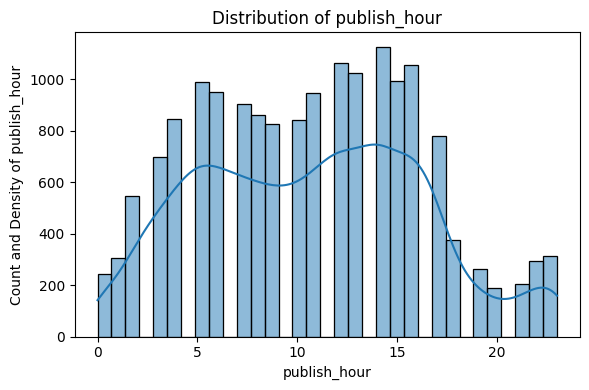

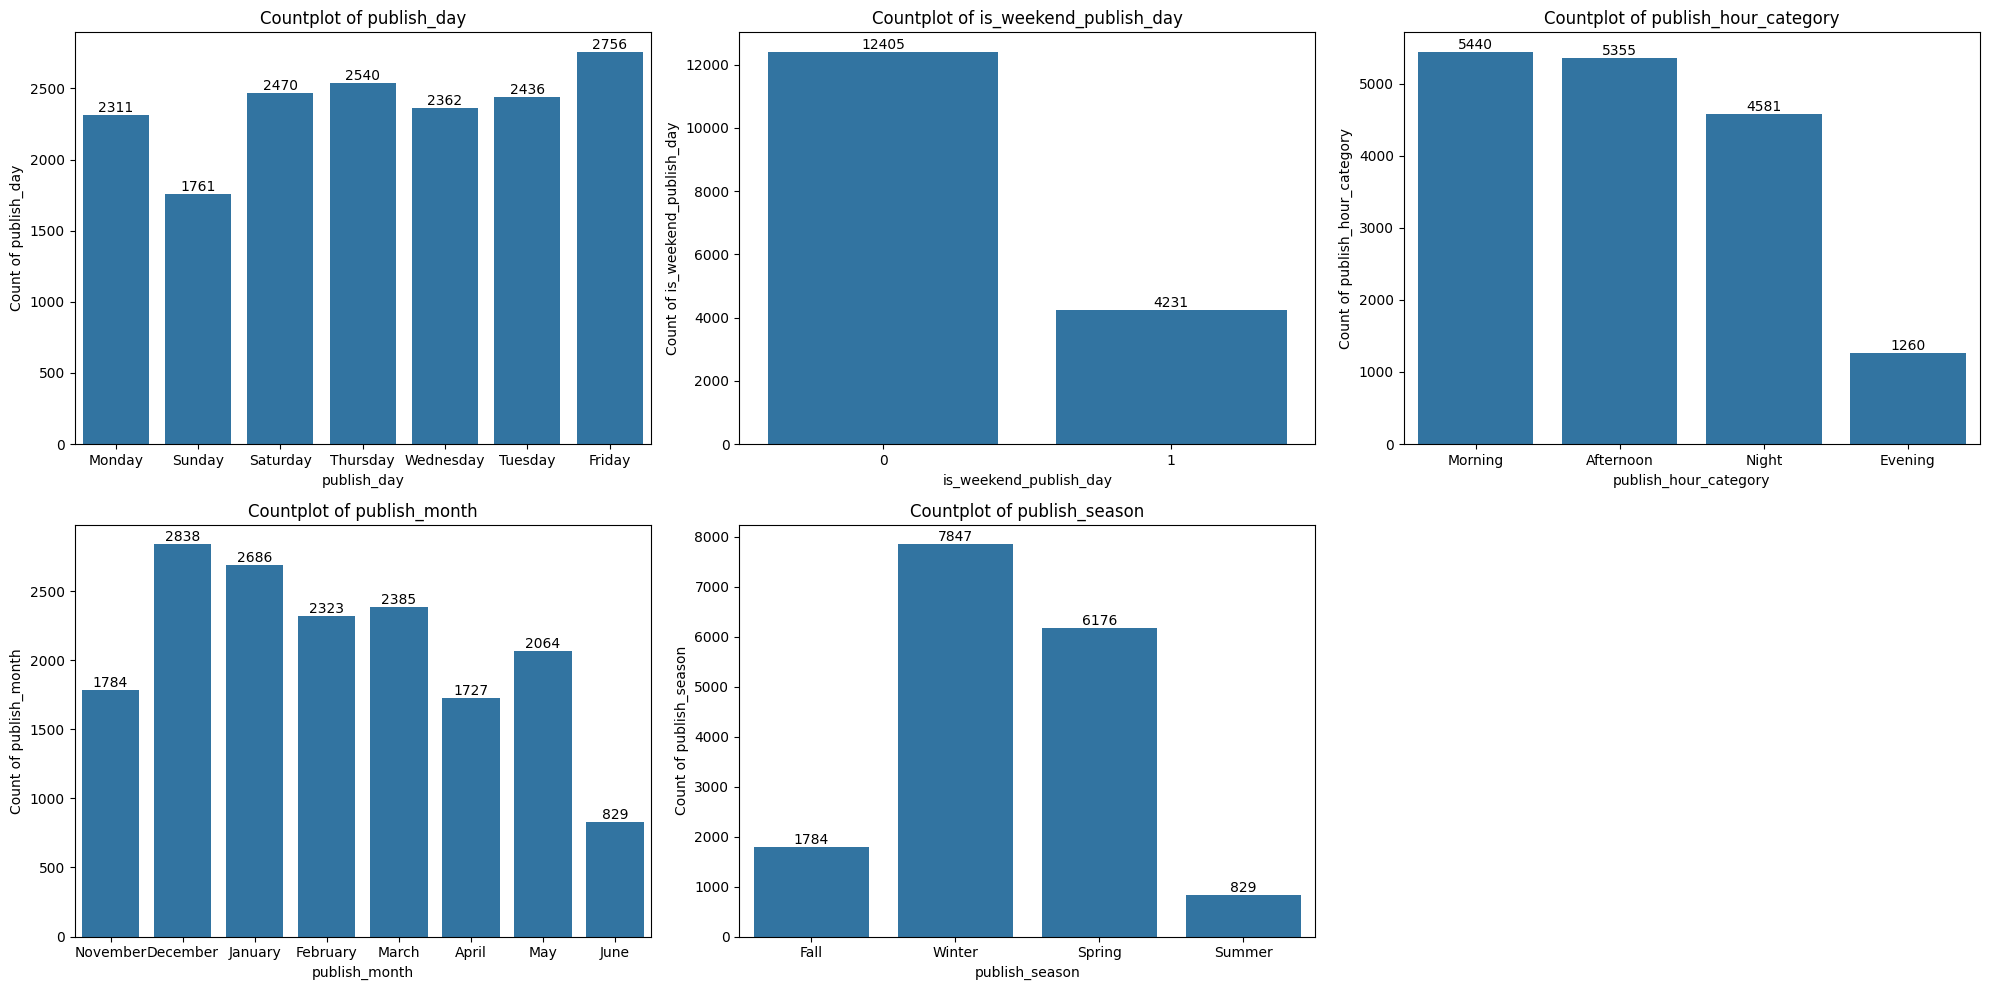

Feature  count unique       top freq_top   bottom  \
0             publish_day  16636      7    Friday     2756   Sunday   
1  is_weekend_publish_day  16636      2         0    12405        1   
2   publish_hour_category  16636      4   Morning     5440  Evening   
3           publish_month  16636      8  December     2838     June   
4          publish_season  16636      4    Winter     7847   Summer   

   freq_bottom  top_percentage  bottom_percentage  
0         1761           16.57              10.59  
1         4231           74.57              25.43  
2         1260           32.70               7.57  
3          829           17.06               4.98  
4          829           47.17               4.98

In [18]:
# Quick check on the distribution of the new columns
plot_dynamic_hisplots_kdeplots(df=feature_engineered_df, col_series=['publish_hour'], plot_type="histplot", ncols=1, figsize=(6, 4))
plot_dynamic_countplot(df=feature_engineered_df, col_series=['publish_day', 'is_weekend_publish_day', 'publish_hour_category', 'publish_month', 'publish_season'], ncols=3, figsize=(20, 10))
describe_categorical_combined(feature_engineered_df, ['publish_day', 'is_weekend_publish_day', 'publish_hour_category', 'publish_month', 'publish_season'])

#### Trending Time Extractions

Note to remember that in `trending_time` column we only have information of date and not time. Also the duration of trending of a video is only 24 hours (which is literally only the next day) at maximum is another thing can should be put under our consideration here. So we probably won't need many new features from this column.

In [19]:
## Extract features from publish_time_fixed column

# Publish day of the week
feature_engineered_df['trending_day'] = feature_engineered_df['trending_date'].dt.day_name()

# Trending day is the same as publish day indicator
feature_engineered_df['is_same_day_trending_publish'] = (feature_engineered_df['trending_date'].dt.date == feature_engineered_df['publish_time_fixed'].dt.date).apply(lambda x: 1 if x else 0)

## Change the data types of engineered columns
new_columns = ['trending_day', 'is_same_day_trending_publish']
feature_engineered_df[new_columns] = feature_engineered_df[new_columns].astype('str')

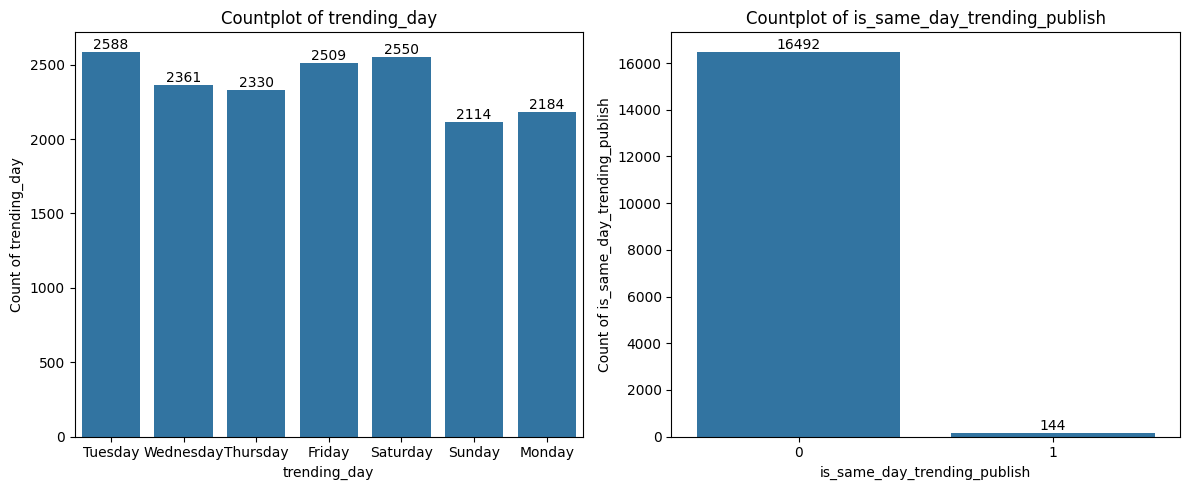

Feature  count unique      top freq_top  bottom  \
0                  trending_day  16636      7  Tuesday     2588  Sunday   
1  is_same_day_trending_publish  16636      2        0    16492       1   

   freq_bottom  top_percentage  bottom_percentage  
0         2114           15.56              12.71  
1          144           99.13               0.87

In [20]:
# Quick check on the distribution of the new columns
plot_dynamic_countplot(df=feature_engineered_df, col_series=['trending_day', 'is_same_day_trending_publish'], ncols=2, figsize=(12, 5))
describe_categorical_combined(feature_engineered_df, ['trending_day', 'is_same_day_trending_publish'])

#### Engagement Ratios

User engagement metrics by creating ratio features between different interaction types (likes, dislikes, comments) and views. These ratios can help understand user behavior patterns and video performance:

- Like-to-View Ratio: Shows what percentage of viewers liked the video
- Dislike-to-View Ratio: Shows what percentage of viewers disliked the video 
- Comment-to-View Ratio: Shows viewer engagement through comments
- Like-to-Dislike Ratio: Sentiment indicator of viewer reactions

In [21]:
# like_to_view_ratio
feature_engineered_df['like_to_view_ratio'] = feature_engineered_df['likes'] / feature_engineered_df['views']

# dislike_to_view_ratio
feature_engineered_df['dislike_to_view_ratio'] = feature_engineered_df['dislikes'] / feature_engineered_df['views']

# comment_to_view_ratio
feature_engineered_df['comment_to_view_ratio'] = feature_engineered_df['comment_count'] / feature_engineered_df['views']

# like_dislike_ratio
feature_engineered_df['like_dislike_ratio'] = feature_engineered_df['likes'] / feature_engineered_df['dislikes']

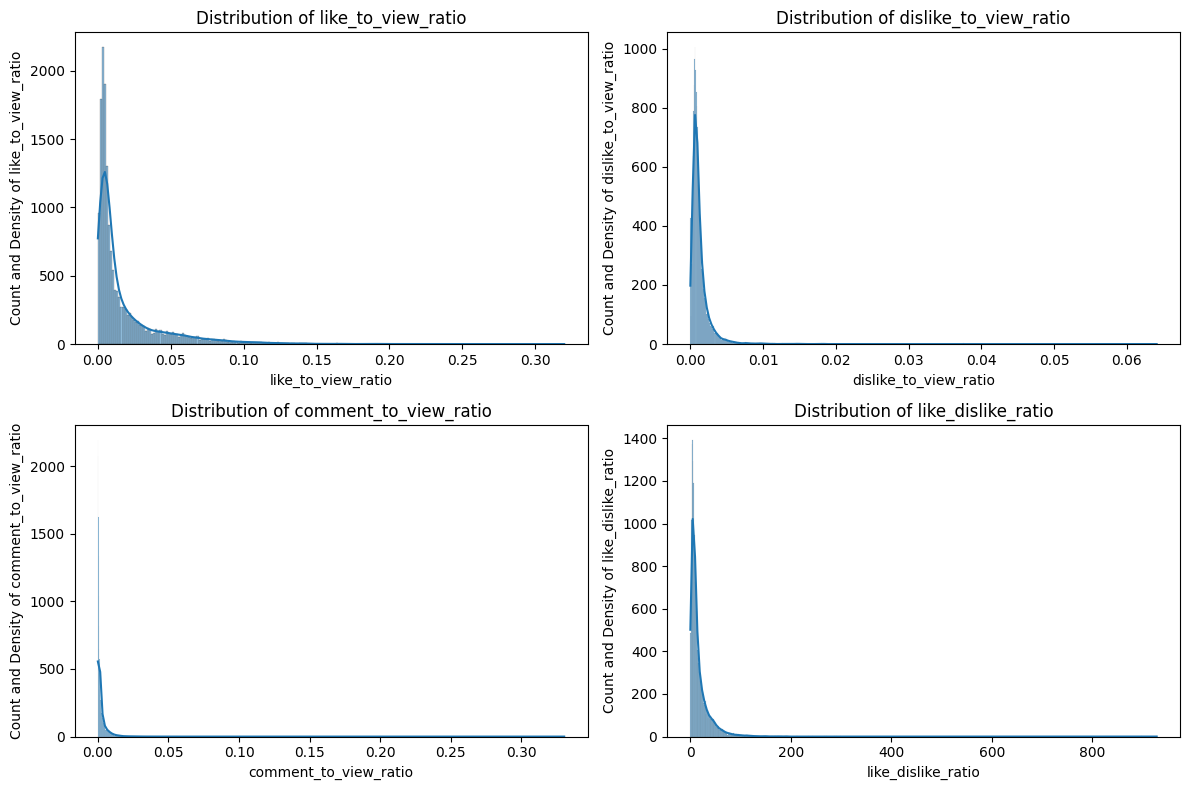

Feature    count      mean       std       min       25%  \
0     like_to_view_ratio  16636.0  0.018341  0.025670  0.000000  0.003713   
1  dislike_to_view_ratio  16636.0  0.001311  0.001791  0.000000  0.000577   
2  comment_to_view_ratio  16636.0  0.002366  0.007684  0.000000  0.000300   
3     like_dislike_ratio  16226.0       inf       NaN  0.085766  4.835188   

        50%        75%       max     range        IQR          CV   skewness  \
0  0.007308   0.021766  0.319896  0.319896   0.018053  139.961853   2.789985   
1  0.000894   0.001479  0.064109  0.064109   0.000902  136.618884  10.987688   
2  0.000782   0.002273  0.330388  0.330388   0.001973  324.843951  23.930986   
3  9.299817  20.448431       inf       inf  15.613243         NaN        NaN   

     kurtosis  
0   11.193934  
1  226.027666  
2  791.087810  
3         NaN

In [22]:
# Quick check on the distribution of the new columns
engagement_features =  ['like_to_view_ratio', 'dislike_to_view_ratio', 'comment_to_view_ratio', 'like_dislike_ratio']
plot_dynamic_hisplots_kdeplots(feature_engineered_df, col_series=engagement_features, ncols=2, figsize=(12, 8))
describe_numerical_combined(feature_engineered_df, engagement_features)

#### Video Sentiment Characteristics

##### Sentiment Features:
1. `title_sentiment`: Perform sentiment analysis on video titles to determine:
   - Emotional tone (positive, negative, neutral)
   - Sentiment score (-1 to 1)
   - Sentiment intensity

2. `desc_sentiment`: Analyze description sentiment to extract:
   - Overall emotional tone
   - Sentiment polarity
   - Subjectivity score

##### Title Characteristics (*can't be implemented since we already process the text*):
1. `is_clickbait`: Identify clickbait titles using:
   - Common clickbait patterns
   - Exaggerated language
   - Emotional triggers
   - Question marks or exclamation points

2. `title_style`: Analyze title writing style:
   - All caps words
   - Punctuation patterns
   - Use of numbers
   - Presence of emojis

In [23]:
# Import TextBlob
from textblob import TextBlob

# title_sentiment
feature_engineered_df['title_sentiment'] = feature_engineered_df['title'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

# description_sentiment
feature_engineered_df['description_sentiment'] = feature_engineered_df['description'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

# tags_sentiment
feature_engineered_df['tags_sentiment'] = feature_engineered_df['tags'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

# Create label based on the polarity scores
def label_sentiment(score):
    if score > 0:
        return 'Positive'
    elif score < 0:
        return 'Negative'
    else:
        return 'Neutral'
    
# title_sentiment_label
feature_engineered_df['title_sentiment_label'] = feature_engineered_df['title_sentiment'].apply(label_sentiment)

# description_sentiment_label
feature_engineered_df['description_sentiment_label'] = feature_engineered_df['description_sentiment'].apply(label_sentiment)

# tags_sentiment_label
feature_engineered_df['tags_sentiment_label'] = feature_engineered_df['tags_sentiment'].apply(label_sentiment)

title_sentiment  description_sentiment  tags_sentiment  \
0         0.000000               0.000000        0.450000   
1         0.281250               0.500000        0.300000   
2         0.000000               0.000000        0.000000   
3         0.000000               0.121737        0.193182   
4         0.170833               0.170833        0.165000   

  title_sentiment_label description_sentiment_label tags_sentiment_label  
0               Neutral                     Neutral             Positive  
1              Positive                    Positive             Positive  
2               Neutral                     Neutral              Neutral  
3               Neutral                    Positive             Positive  
4              Positive                    Positive             Positive

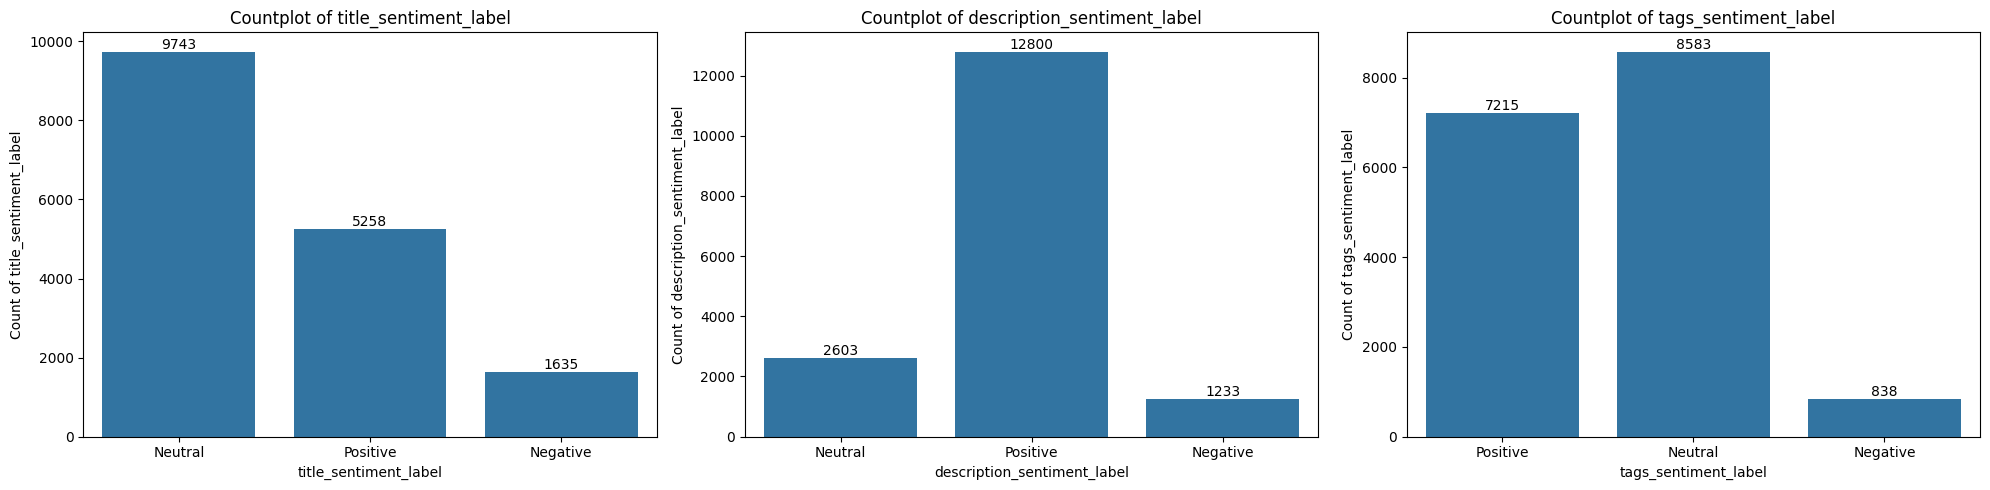

In [25]:
# Display the polarity score with the label
sentiment_df = feature_engineered_df[['title_sentiment', 'description_sentiment', 'tags_sentiment', 'title_sentiment_label', 'description_sentiment_label', 'tags_sentiment_label']].head()
display(sentiment_df)

# Plot sentiment distribution
sentiment_cols = ['title_sentiment_label', 'description_sentiment_label', 'tags_sentiment_label']
plot_dynamic_countplot(df=feature_engineered_df, col_series=sentiment_cols, ncols=3, figsize=(20, 5))

#### Additional Categorical Features

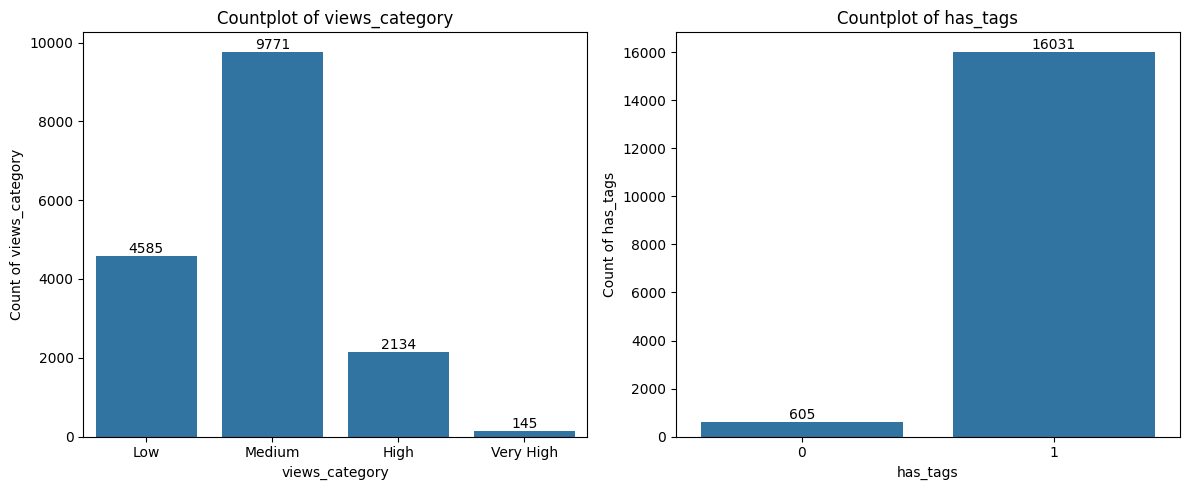

In [ ]:
# Categorized the views column into 4 categories
feature_engineered_df['views_category'] = pd.cut(feature_engineered_df['views'], bins=[-1, 1e5, 1e6, 1e7, 1e8], labels=['Low', 'Medium', 'High', 'Very High'])  
# feature_engineered_df['views_category'] = pd.qcut(feature_engineered_df['views'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])

# has_tags (checks for empty tags or 'none' tags)
feature_engineered_df['has_tags'] = feature_engineered_df['tags'].apply(lambda x: 0 if pd.isna(x) or str(x).lower() == 'none' else 1)

# Plot the distribution of the new columns
new_columns = ['views_category', 'has_tags']
plot_dynamic_countplot(df=feature_engineered_df, col_series=new_columns, ncols=2, figsize=(12, 5))

In [33]:
# Re-arrange column (target 'views' at the end --> personal preference)
feature_engineered_df = feature_engineered_df[[col for col in feature_engineered_df.columns if col != 'views'] + ['views']]

## Feature Encoding

In [1]:
# Import initial necessary libraries
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import tensorflow as tf
from tensorflow import keras

import os
import sklearn
import joblib
import math
import scipy.stats as stats
from scipy.stats import skew, kurtosis, chi2_contingency

# For translation of several text columns that are in Indian language
from openai import OpenAI
import time
from tqdm import tqdm  # for progress bar
from dotenv import load_dotenv
load_dotenv()

# Settings of dataframe display
pd.options.display.max_columns = 100
## Funtion to change the display width of the columns (needed for text analysis)
def change_colwidth(option="set"):
    if option == "set":
        pd.set_option('max_colwidth', None)

    elif option == "reset":
        pd.reset_option('max_colwidth')    

# Set random seed for all numpy random generation methods
np.random.seed(42)

# Version requirements
print('numpy version : ',np.__version__)
print('pandas version : ',pd.__version__)
print('seaborn version : ',sns.__version__)
print("scikit-learn version:", sklearn.__version__)
print("joblib version:", joblib.__version__)

numpy version :  1.26.4
pandas version :  2.2.1
seaborn version :  0.13.2
scikit-learn version: 1.4.0
joblib version: 1.3.2


In [39]:
# Re-grouping columns based on their types
nums_cols = ['likes', 'dislikes', 'comment_count', 'No_tags', 'desc_len', 'len_title', 'views']
cats_cols = ['title', 'channel_title', 'tags','description', 'category_id', 'comments_disabled', 'ratings_disabled', 'video_error_or_removed']
dates_cols = ['trending_date', 'publish_time_fixed']

In [40]:
# Import the saved feature engineered dataset
parent_dir = os.path.abspath(os.getcwd())
feature_engineered_df_path = os.path.join(parent_dir, 'data', 'feature_engineered_dataset.csv')

# Define data type mappings
dtype_mapping = {
    'category_id': str,
    'comments_disabled': str,
    'ratings_disabled': str,
    'video_error_or_removed': str,
    'is_weekend_publish_day': str,
    'is_same_day_trending_publish': str,
    'has_tags': str,
}

# Read the translated dataset with specified data types (This is done because CSV files don't preserve data type information)
feature_encoded_df = pd.read_csv(feature_engineered_df_path, dtype=dtype_mapping, parse_dates=['trending_date', 'publish_time_fixed'])

### Encoding For Non-Long Text Features

In [41]:
# Check all categorical columns that need to be encoded, excluding text columns
encoded_columns = (feature_encoded_df.select_dtypes(include='object')
                                     .drop(['title', 'channel_title', 'tags', 'description'], axis=1)
                                     .columns)
check_data_information(feature_encoded_df, cols=encoded_columns)

Feature  Data Type   Null Values   Null Percentage  \
0                    category_id     object             0              0.00   
1              comments_disabled     object             0              0.00   
2               ratings_disabled     object             0              0.00   
3         video_error_or_removed     object             0              0.00   
4                    publish_day     object             0              0.00   
5         is_weekend_publish_day     object             0              0.00   
6          publish_hour_category     object             0              0.00   
7                  publish_month     object             0              0.00   
8                 publish_season     object             0              0.00   
9                   trending_day     object             0              0.00   
10  is_same_day_trending_publish     object             0              0.00   
11         title_sentiment_label     object             0              0.00   
12   description_sentiment_label     object             0              0.00   
13          tags_sentiment_label     object             0              0.00   
14                views_category     object             1              0.01   
15                      has_tags     object             0              0.00   

     Duplicated Values   Unique Values  \
0                    2              17   
1                    2               2   
2                    2               2   
3                    2               2   
4                    2               7   
5                    2               2   
6                    2               4   
7                    2               8   
8                    2               4   
9                    2               7   
10                   2               2   
11                   2               3   
12                   2               3   
13                   2               3   
14                   2               4   
15                   2               2   

                                       Unique Sample  
0                                [24, 22, 26, 25, 1]  
1                                      [False, True]  
2                                      [False, True]  
3                                      [False, True]  
4    [Monday, Sunday, Saturday, Thursday, Wednesday]  
5                                             [0, 1]  
6               [Morning, Afternoon, Night, Evening]  
7     [November, December, January, February, March]  
8                     [Fall, Winter, Spring, Summer]  
9   [Tuesday, Wednesday, Thursday, Friday, Saturday]  
10                                            [0, 1]  
11                     [Neutral, Positive, Negative]  
12                     [Neutral, Positive, Negative]  
13                     [Positive, Neutral, Negative]  
14               [Low, Medium, High, Very High, nan]  
15                                            [1, 0]

From this information we can know the encoding methods that we need to apply for categorical columns, which are:

- Label Encoding (all of them are binary values)
    - `comments_disabled`, `ratings_disabled`, `video_error_or_removed`
    - `is_weekend_publish_day`
    - `is_same_day_trending_publish`
    - `has_tags`

- One-hot Encoding
    - `category_id`
    - `publish_day`, `publish_hour_category`, `publish_month`, `publish_season`, ,
    - `trending_day`,
    - `title_sentiment_label`, `description_sentiment_label`, `tags_sentiment_label`

In [42]:
# Initialize columns for label encoding and one-hot encoding
label_encoding_cols = ['comments_disabled', 'ratings_disabled', 'video_error_or_removed', 'is_weekend_publish_day', 'is_same_day_trending_publish', 'has_tags']
onehot_encoding_cols = [col for col in encoded_columns if col not in label_encoding_cols]

In [43]:
# Apply label encoding using map function
for col in label_encoding_cols:
    # Handling for values of False and True
    if 'False' in feature_encoded_df[col].unique() and 'True' in feature_encoded_df[col].unique():
        feature_encoded_df[col] = feature_encoded_df[col].map({'False': 0, 'True': 1})

    # Handling for values of 0 and 1
    else:
        feature_encoded_df[col] = feature_encoded_df[col].map({val: idx for idx, val in enumerate(feature_encoded_df[col].unique())})

# Check the label encoded columns
check_data_information(feature_encoded_df, cols=label_encoding_cols)

Feature  Data Type   Null Values   Null Percentage  \
0             comments_disabled      int64             0               0.0   
1              ratings_disabled      int64             0               0.0   
2        video_error_or_removed      int64             0               0.0   
3        is_weekend_publish_day      int64             0               0.0   
4  is_same_day_trending_publish      int64             0               0.0   
5                      has_tags      int64             0               0.0   

    Duplicated Values   Unique Values  Unique Sample  
0                   2               2         [0, 1]  
1                   2               2         [0, 1]  
2                   2               2         [0, 1]  
3                   2               2         [0, 1]  
4                   2               2         [0, 1]  
5                   2               2         [0, 1]

In [44]:
# Apply one-hot encoding using pandas get_dummies
for col in onehot_encoding_cols:
    # Create one-hot encoded columns with prefix
    onehots = pd.get_dummies(feature_encoded_df[col], prefix=col, drop_first=True) * 1
    
    # Concat the one-hot encoded columns to the original DataFrame
    feature_encoded_df = pd.concat([feature_encoded_df, onehots], axis=1)
    
    # Drop the original column after encoding
    feature_encoded_df.drop(columns=[col], inplace=True)

In [46]:
# Check the one-hot encoded columns
feature_encoded_df.head(2)

trending_date                                              title  \
0    2017-11-14                            pearly bent soub second   
1    2017-11-14  lottery held zodiac sign th november rain lot ...   

  channel_title                                               tags  likes  \
0       Asianet  pearly beat soub second best comedybest comedy...    247   
1   AstroMitram  tiger zinda hai trailertiger zinda hai officia...    838   

   dislikes  comment_count  comments_disabled  ratings_disabled  \
0        20             10                  0                 0   
1       189             49                  0                 0   

   video_error_or_removed                                        description  \
0                       0                       pearly beat soub second show   
1                       0  lottery held zodiac sign november lot money lo...   

   No_tags  desc_len  len_title  publish_time_fixed  trending_duration  \
0       28       110         58 2017-11-13 11:45:39          12.239167   
1       24       595         89 2017-11-12 10:46:55          13.218056   

   is_weekend_publish_day  publish_hour  is_same_day_trending_publish  \
0                       0            11                             0   
1                       1            10                             0   

   like_to_view_ratio  dislike_to_view_ratio  comment_to_view_ratio  \
0            0.004502               0.000365               0.000182   
1            0.008593               0.001938               0.000502   

   like_dislike_ratio  title_sentiment  description_sentiment  tags_sentiment  \
0           12.350000          0.00000                    0.0            0.45   
1            4.433862          0.28125                    0.5            0.30   

   has_tags  views  category_id_10  category_id_15  category_id_17  \
0         0  54861               0               0               0   
1         0  97522               0               0               0   

   category_id_19  category_id_2  category_id_20  category_id_22  \
0               0              0               0               0   
1               0              0               0               1   

   category_id_23  category_id_24  category_id_25  category_id_26  \
0               0               1               0               0   
1               0               0               0               0   

   category_id_27  category_id_28  category_id_29  category_id_30  \
0               0               0               0               0   
1               0               0               0               0   

   category_id_43  publish_day_Monday  publish_day_Saturday  \
0               0                   1                     0   
1               0                   0                     0   

   publish_day_Sunday  publish_day_Thursday  publish_day_Tuesday  \
0                   0                     0                    0   
1                   1                     0                    0   

   publish_day_Wednesday  publish_hour_category_Evening  \
0                      0                              0   
1                      0                              0   

   publish_hour_category_Morning  publish_hour_category_Night  \
0                              1                            0   
1                              1                            0   

   publish_month_December  publish_month_February  publish_month_January  \
0                       0                       0                      0   
1                       0                       0                      0   

   publish_month_June  publish_month_March  publish_month_May  \
0                   0                    0                  0   
1                   0                    0                  0   

   publish_month_November  publish_season_Spring  publish_season_Summer  \
0                       1                      0                      0   
1                       1              

### Encoding For Long Text Features

Recommendation :

I see you're working with YouTube video data and need to convert text features (description, title, and tags) into numerical representations for your regression model. Here are some effective approaches you could use:

1. TF-IDF (Term Frequency-Inverse Document Frequency):
- Best for capturing the importance of words in your texts
- Works well when the word frequency matters
- Good for longer texts like descriptions
- Handles out-of-vocabulary words during prediction

```python
from sklearn.feature_extraction.text import TfidfVectorizer

# For descriptions
tfidf_desc = TfidfVectorizer(max_features=1000)  # Limit features to prevent dimensionality issues
desc_features = tfidf_desc.fit_transform(df['description'])

# For titles
tfidf_title = TfidfVectorizer(max_features=500)
title_features = tfidf_title.fit_transform(df['title'])

# For tags (joining them into a single string first if they're in a list)
df['tags_text'] = df['tags'].apply(lambda x: ' '.join(str(x).split('|')))
tfidf_tags = TfidfVectorizer(max_features=500)
tags_features = tfidf_tags.fit_transform(df['tags_text'])
```

2. Word Embeddings:
- Pre-trained models like Word2Vec, GloVe, or FastText
- Good for capturing semantic relationships
- Usually better than TF-IDF for titles since they're shorter
- Can average word vectors for each text

```python
import gensim.downloader as api

# Load pre-trained Word2Vec
word2vec_model = api.load('word2vec-google-news-300')

def text_to_vec(text, model):
    words = str(text).lower().split()
    word_vecs = [model[word] for word in words if word in model]
    if not word_vecs:
        return np.zeros(model.vector_size)
    return np.mean(word_vecs, axis=0)

# Apply to each text column
df['title_vectors'] = df['title'].apply(lambda x: text_to_vec(x, word2vec_model))
```

3. For tags specifically:
Since tags are often structured differently than regular text, you might want to:
- Count the number of tags
- Use binary encoding for common tags
- Create tag embeddings based on co-occurrence

```python
# Count tags
df['tag_count'] = df['tags'].str.count('\|') + 1

# Binary encoding for most common tags
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
tags_encoded = mlb.fit_transform(df['tags'].str.split('|'))
```

Recommendation:
Given your data, I would suggest:
1. Use TF-IDF for descriptions (since they're longer)
2. Use Word2Vec embeddings for titles (to capture semantic meaning)
3. Use a combination of tag count and binary encoding for most common tags

Important considerations:
- Keep dimensionality in check (use `max_features` in TfidfVectorizer)
- Consider feature importance after encoding to remove less useful features
- Use cross-validation to compare different approaches
- Consider using dimensionality reduction (PCA, t-SNE) if the feature space becomes too large

In [ ]:
# Encoding for 


## Feature Selection

In [ ]:
# # Heatmap for every date features to target (views)
# plt.figure(figsize=(10, 8))
# mask = np.triu(np.ones_like(feature_engineered_df.corr(numeric_only=True), dtype=bool))
# sns.heatmap(data = feature_engineered_df.corr(numeric_only=True, method='spearman'), mask=mask, cmap='coolwarm', annot=True, fmt='.3f', vmin=-1, vmax=1)

In [47]:
# Re-arrange the columns (views in last)
df_1 = df_encoding.drop(columns='views')
df_2 = df_encoding['views']
df_encoding = pd.concat([df_1, df_2], axis='columns')

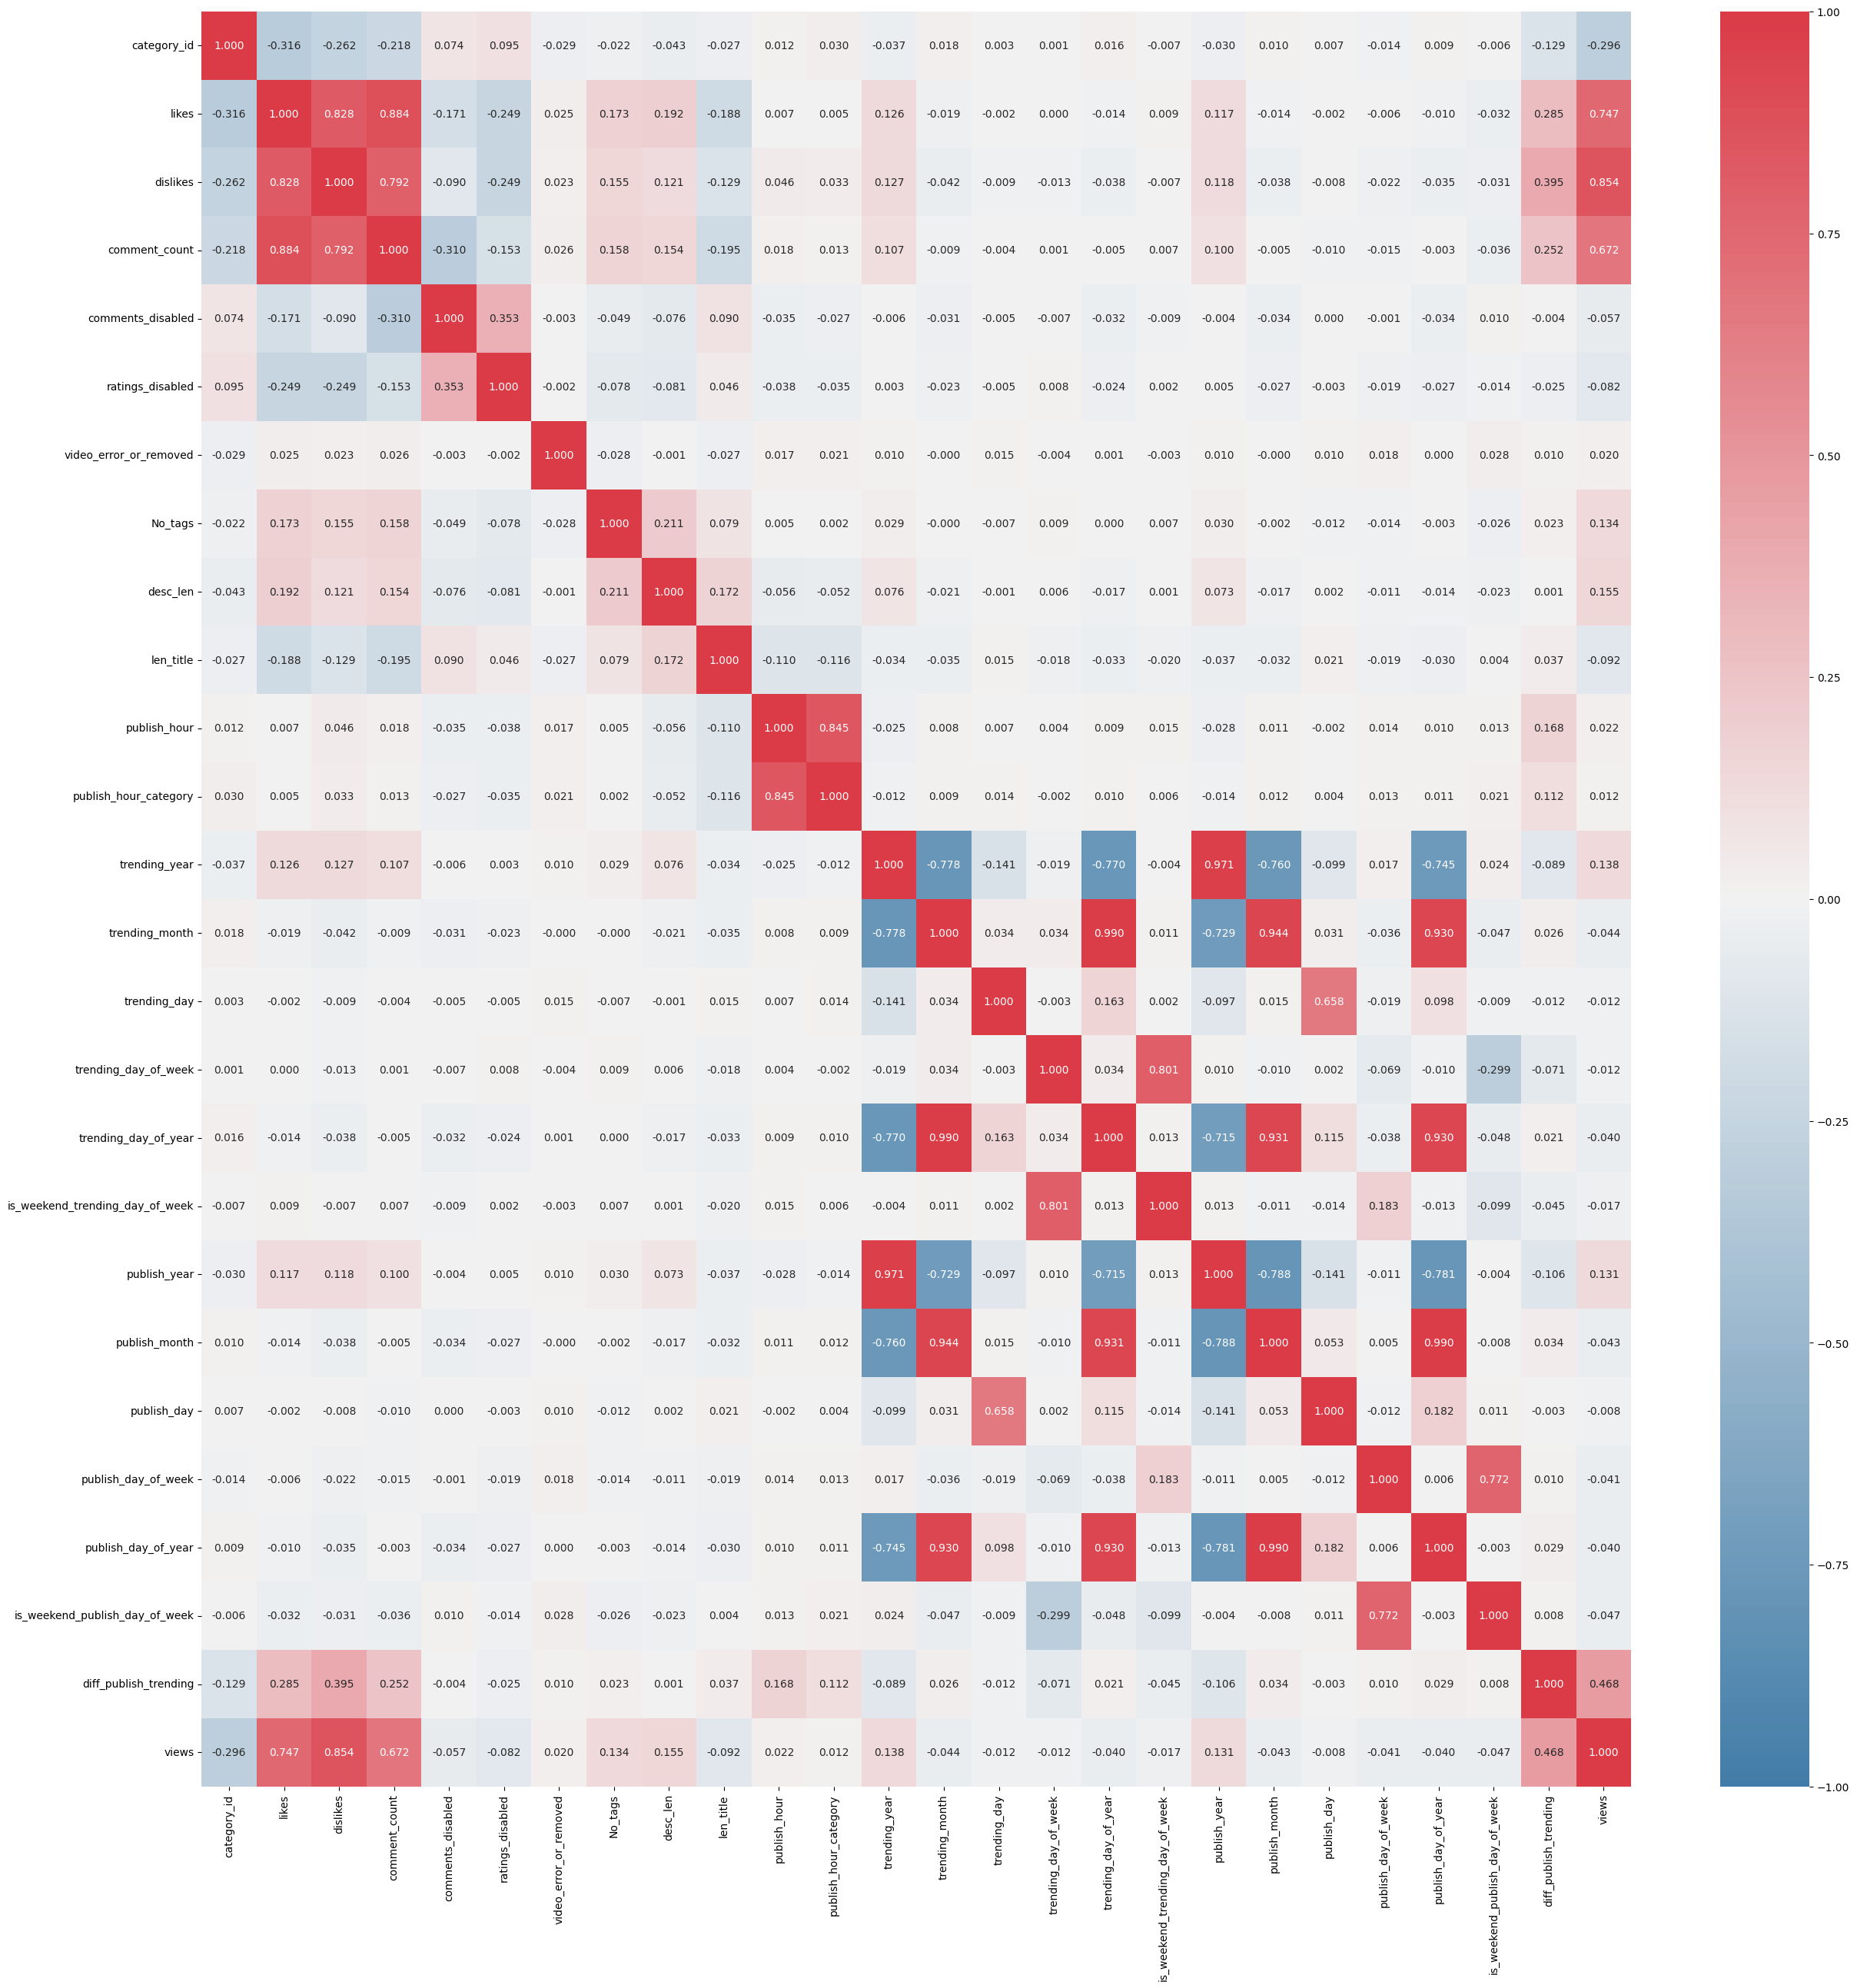

In [48]:
# Heatmap (corr spearman)
plt.figure(figsize=(30,30))
cmap_custom = sns.diverging_palette(240, 10, as_cmap=True)
sns.heatmap(data = df_encoding.corr(numeric_only=True, method='spearman'), cmap=cmap_custom, annot=True, fmt='.3f', vmin=-1, vmax=1)
plt.show()

In this heatmap correlation analysis, the features to be used include: 'category_id', 'likes', 'dislikes', 'No_tags', 'desc_len', 'diff_days', and features resulting from encoding process based on considerations of the problem context, feature-target correlation, feature-feature correlation. Additionally, redundant features (with high correlation) will be discarded, keeping only one with the highest to target.

In [58]:
# Create temporary dataframe for testing SelectKBest
df_feature_target_relation = df_encoding.copy()

selected_columns = df_feature_target_relation.columns.difference(['trending_date', 'publish_date', 'publish_time', 'title', 'channel_title', 'tags', 'description'])
df_feature_target_relation = df_feature_target_relation[selected_columns]

# df_feature_target_relation = df_feature_target_relation.loc[:, ~df_feature_target_relation.columns.isin(['trending_date', 'publish_date', 'publish_time', 'title', 'channel_title', 'tags', 'description'])]
# df_feature_target_relation.head()

In [59]:
#Calculation of feature importance score to target (numerical/categorical feature - numerical target)

from sklearn.feature_selection import SelectKBest, mutual_info_regression

# Separate features and target variable
x_features_test = df_feature_target_relation.drop(columns=['views'])  # Features
y_target_test = df_feature_target_relation['views']  # Target variable

# Instantiate SelectKBest
k_best = SelectKBest(score_func=mutual_info_regression, k='all')  # Use 'all' to see scores for all features

# Fit and transform the data
x_selected_features = k_best.fit_transform(x_features_test, y_target_test)

# Get scores, p-values, and feature names
feature_scores = k_best.scores_
p_values = k_best.pvalues_
feature_names = x_features_test.columns

# Create a DataFrame to display feature scores and p-values
feature_scores_df = pd.DataFrame({'Feature': feature_names, 'Score': feature_scores, 'P-value': p_values})
feature_scores_df = feature_scores_df.sort_values(by='Score', ascending=False)

# Display the feature scores and p-values
print(feature_scores_df)

                            Feature     Score P-value
6                          dislikes  0.751994    None
10                            likes  0.572688    None
2                     comment_count  0.425837    None
5             diff_publish_trending  0.166835    None
4                          desc_len  0.118112    None
1                       category_id  0.118016    None
0                           No_tags  0.060124    None
9                         len_title  0.047520    None
13              publish_day_of_year  0.037192    None
21             trending_day_of_year  0.036821    None
14                     publish_hour  0.032550    None
16                    publish_month  0.026560    None
22                   trending_month  0.026198    None
19                     trending_day  0.019592    None
12              publish_day_of_week  0.014492    None
11                      publish_day  0.011524    None
20             trending_day_of_week  0.009303    None
15            publish_hour_c

In [60]:
#Calculation of feature importance score to target (numerical/categorical feature - numerical target)

from sklearn.feature_selection import SelectKBest, chi2

# Separate features and target variable
x_features_test = df_feature_target_relation.drop(columns=['views'])  # Features
y_target_test = df_feature_target_relation['views']  # Target variable

# Instantiate SelectKBest
k_best = SelectKBest(score_func=chi2, k='all')  # Use 'all' to see scores for all features

# Fit and transform the data
x_selected_features = k_best.fit_transform(x_features_test, y_target_test)

# Get scores, p-values, and feature names
feature_scores = k_best.scores_
p_values = k_best.pvalues_
feature_names = x_features_test.columns

# Create a DataFrame to display feature scores and p-values
feature_scores_df = pd.DataFrame({'Feature': feature_names, 'Score': feature_scores, 'P-value': p_values})
feature_scores_df = feature_scores_df.sort_values(by='Score', ascending=False)

# Display the feature scores and p-values
print(feature_scores_df)

                            Feature         Score        P-value
10                            likes  1.185153e+10   0.000000e+00
6                          dislikes  5.914666e+09   0.000000e+00
2                     comment_count  2.815873e+09   0.000000e+00
4                          desc_len  2.286258e+07   0.000000e+00
13              publish_day_of_year  3.318660e+06   0.000000e+00
21             trending_day_of_year  3.308621e+06   0.000000e+00
9                         len_title  2.238157e+05   0.000000e+00
0                           No_tags  1.647303e+05   0.000000e+00
19                     trending_day  1.531669e+05   0.000000e+00
11                      publish_day  1.528876e+05   0.000000e+00
16                    publish_month  9.728568e+04   0.000000e+00
22                   trending_month  9.710486e+04   0.000000e+00
14                     publish_hour  8.230285e+04   0.000000e+00
5             diff_publish_trending  7.219906e+04   0.000000e+00
1                       c

**Reminder About P-Values**

In statistical hypothesis testing, the p-value is a measure that helps you assess the evidence against a null hypothesis. In the context of evaluating selected features for model training, p-values are often associated with statistical tests, such as t-tests or ANOVA, to determine whether there is a significant difference between groups.

Here's a general guideline:

1. **Null Hypothesis (\(H_0\)):** The null hypothesis typically assumes that there is no significant relationship or difference between groups.
   
2. **Alternative Hypothesis (\(H_1\) or \(H_a\)):** The alternative hypothesis suggests that there is a significant relationship or difference.

3. **P-value Interpretation:**
   - If the p-value is less than or equal to your chosen significance level (often 0.05), you reject the null hypothesis. This suggests that there is enough evidence to conclude that there is a significant relationship or difference.
   - If the p-value is greater than your chosen significance level, you fail to reject the null hypothesis. This implies that there is not enough evidence to conclude a significant relationship or difference.

However, it's crucial to note a few considerations:

- **Multiple Comparisons:** When you're evaluating multiple features simultaneously, there is a risk of inflated Type I error (false positives) due to multiple comparisons. In such cases, you might want to apply a correction method (like Bonferroni correction) to adjust the significance level.

- **Effect Size:** Even if a result is statistically significant, it might not be practically significant. Therefore, it's important to consider the effect size along with p-values.

- **Domain Knowledge:** Statistical significance does not guarantee practical importance. Consider the context and domain-specific knowledge when interpreting results.

- **Model Performance:** P-values alone might not be sufficient for feature selection. It's crucial to also consider how well the selected features contribute to the overall performance of your predictive model.

In summary, while a commonly used threshold is a p-value less than 0.05, the interpretation should be made in the context of your study, and it's essential to consider additional factors like effect size, domain knowledge, and overall model performance.

In [95]:
#Checking the columns
df_encoding.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32562 entries, 0 to 36769
Data columns (total 33 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   trending_date                    32562 non-null  datetime64[ns]
 1   title                            32562 non-null  object        
 2   channel_title                    32562 non-null  object        
 3   category_id                      32562 non-null  int64         
 4   publish_time                     32562 non-null  object        
 5   tags                             32562 non-null  object        
 6   likes                            32562 non-null  int64         
 7   dislikes                         32562 non-null  int64         
 8   comment_count                    32562 non-null  int64         
 9   comments_disabled                32562 non-null  int32         
 10  ratings_disabled                 32562 non-null  int32         

In [96]:
# Select only relevant features

df_model = df_encoding.copy()

#Using all features
selected_features = df_encoding.select_dtypes(['float64', 'int8', 'int32', 'int64', 'boolean']).columns

# #Using label or freq encoding
# selected_features = ['category_id', 'dislikes', 'No_tags', 'desc_len',
#                      'diff_publish_trending', 'views']

# #Using OHE
# selected_features = ['category_id', 'likes', 'dislikes', 'No_tags', 'desc_len', 'diff_publish_trending',
#                      'comments_disabled_False','comments_disabled_True', 'ratings_disabled_False',
#                      'ratings_disabled_True', 'video_error_or_removed_False', 'video_error_or_removed_True', 'views']

df_model = df_model[selected_features]
df_model.sample(5)

category_id  likes  dislikes  comment_count  comments_disabled  \
9854            22    781       135             49                  0   
29483            1   3290       342            168                  0   
6960            24   7187       425            878                  0   
20547           23  33138      2344           1674                  0   
3995            27    764        40             77                  0   

       ratings_disabled  video_error_or_removed  No_tags  desc_len  len_title  \
9854                  0                       0        6       615         97   
29483                 0                       0       20       352         22   
6960                  0                       0        8       198         87   
20547                 0                       0       27       273         31   
3995                  0                       0       33       859         98   

       publish_hour  publish_hour_category  trending_year  trending_month  \
9854             12                      0           2018               1   
29483            14                      1           2018               5   
6960             14                      1           2017              12   
20547            13                      1           2018               3   
3995              7                      0           2017              12   

       trending_day  trending_day_of_week  trending_day_of_year  \
9854              6                     5                     6   
29483             5                     5                   125   
6960             21                     3                   355   
20547            10                     5                    69   
3995              5                     1                   339   

       is_weekend_trending_day_of_week  publish_year  publish_month  \
9854                                 1          2018              1   
29483                                1          2018              5   
6960                                 0          2017             12   
20547                                1          2018              3   
3995                                 0          2017             12   

       publish_day  publish_day_of_week  publish_day_of_year  \
9854             4                    3                    4   
29483            3                    3                  123   
6960            19                    1                  353   
20547            6                    1                   65   
3995             4                    0                  338   

       is_weekend_publish_day_of_week  diff_publish_trending   views  
9854                                0                    2.0   94094  
29483                               0                    2.0  167862  
6960                                0                    2.0  230503  
20547                               0                    4.0  697011  
3995                                0                    1.0   28111

## Train-Test Split

In [97]:
# Spliting data into train-test
x = df_model.drop(columns=['views'])
y = df_model[['views']]

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

## Handling Outliers

It is generally recommended to handle outliers based on the training data only. The reason for this is to simulate real-world conditions during the testing phase. Handling outliers in the test set could potentially distort the evaluation of the model's performance on unseen data.

Here's the typical process:

1. **Handling outliers in the training data:** Identify and handle outliers using methods like IQR (Interquartile Range) or Z-score on the training dataset. This helps the model learn from a cleaner dataset and improves its generalization.

2. **Applying the same transformation to the test data:** Use the same parameters (like median and standard deviation for Z-score) obtained from the training data to handle outliers in the test data. This ensures consistency and reflects the real-world scenario where the model encounters new, unseen data with potential outliers.

By following this approach, you are testing the model on data that resembles what it might encounter in the real world, including outliers. This provides a more accurate assessment of how well the model generalizes to new, unseen data.

In [98]:
#Make temporary dataframe of features and target for train set
df_train_handling_outliers = pd.concat([x_train, y_train], axis='columns')

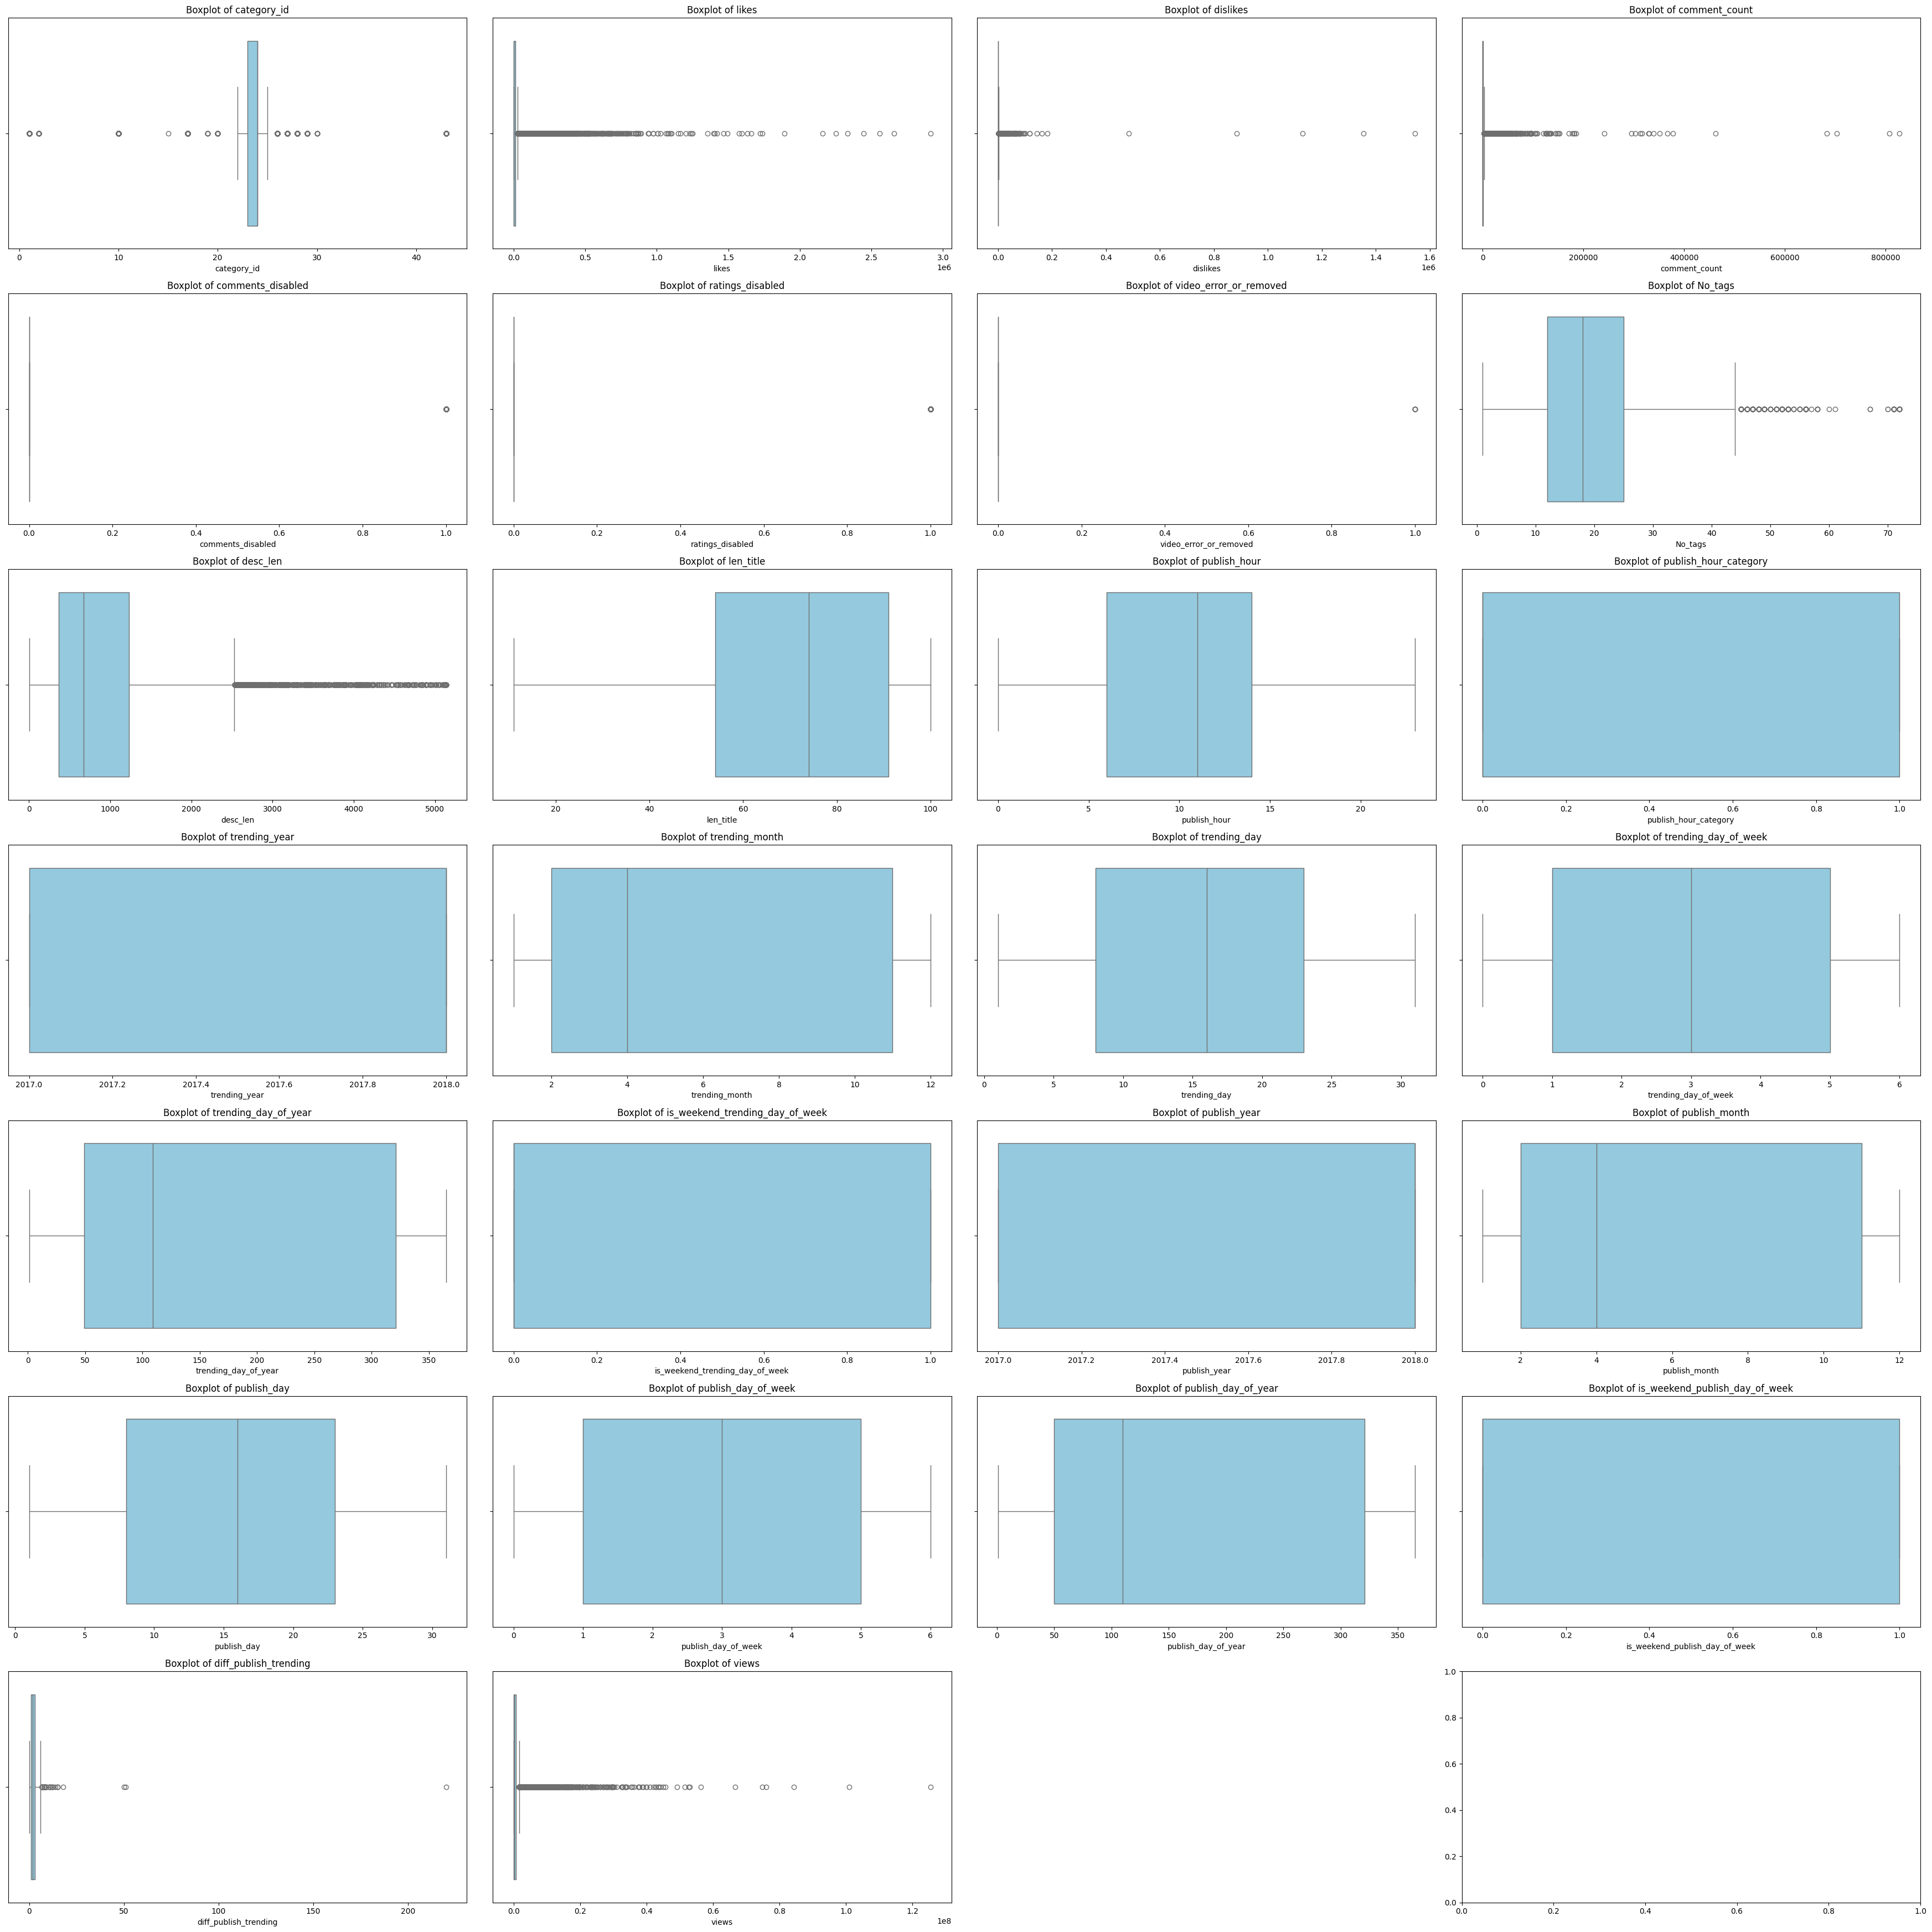

In [102]:
# Boxplot to check outliers
fig, axes = plt.subplots(nrows=7, ncols=4, figsize=(35, 35))
axes = axes.flatten()

for i in range(len(df_train_handling_outliers.columns)) :
  sns.boxplot(data = df_train_handling_outliers, ax=axes[i], x=df_train_handling_outliers.columns[i], orient='h', color='skyblue')
  axes[i].set_title(f'Boxplot of {df_train_handling_outliers.columns[i]}')

# Remove the last subplot if there are fewer features than subplots
if len(df_train_handling_outliers.columns) < len(axes) :
    axes[len(df_train_handling_outliers.columns)].remove()

plt.tight_layout()

In [103]:
columns_to_handle_outliers = ['category_id', 'likes', 'dislikes', 'comment_count', 'No_tags', 'desc_len', 'diff_publish_trending']

In [104]:
# Remove outliers with IQR method

print(f'The number of rows before filtering out outliers : {len(df_train_handling_outliers)}')

filtered_entries = np.array([True] * len(df_train_handling_outliers))

# Select features with outliers
for col in columns_to_handle_outliers:

    Q1 = df_train_handling_outliers[col].quantile(0.25)
    Q3 = df_train_handling_outliers[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - (IQR * 1.5)
    upper_bound = Q3 + (IQR * 1.5)

    filtered_entries = ((df_train_handling_outliers[col] >= lower_bound) & (df_train_handling_outliers[col] <= upper_bound)) & filtered_entries

df_train_handling_outliers = df_train_handling_outliers[filtered_entries]

print(f'The number of rows after filtering out outliers: {len(df_train_handling_outliers)}')

The number of rows before filtering out outliers : 22793
The number of rows after filtering out outliers: 13937


In [105]:
# # Remove outliers with z-score method

# from scipy import stats

# print(f'The number of rows before filtering out outliers : {len(df_train_handling_outliers)}')

# filtered_entries = np.array([True] * len(df_train_handling_outliers))

# # Select features with outliers
# for col in columns_to_handle_outliers:
#     zscore = abs(stats.zscore(df_train_handling_outliers[col])) # calculate the absolute z-score
#     filtered_entries = (zscore < 3) & filtered_entries # keep z-score values less than absolute 3
    
# df_train_handling_outliers = df_train_handling_outliers[filtered_entries]

# print(f'The number of rows after filtering out outliers: {len(df_train_handling_outliers)}')

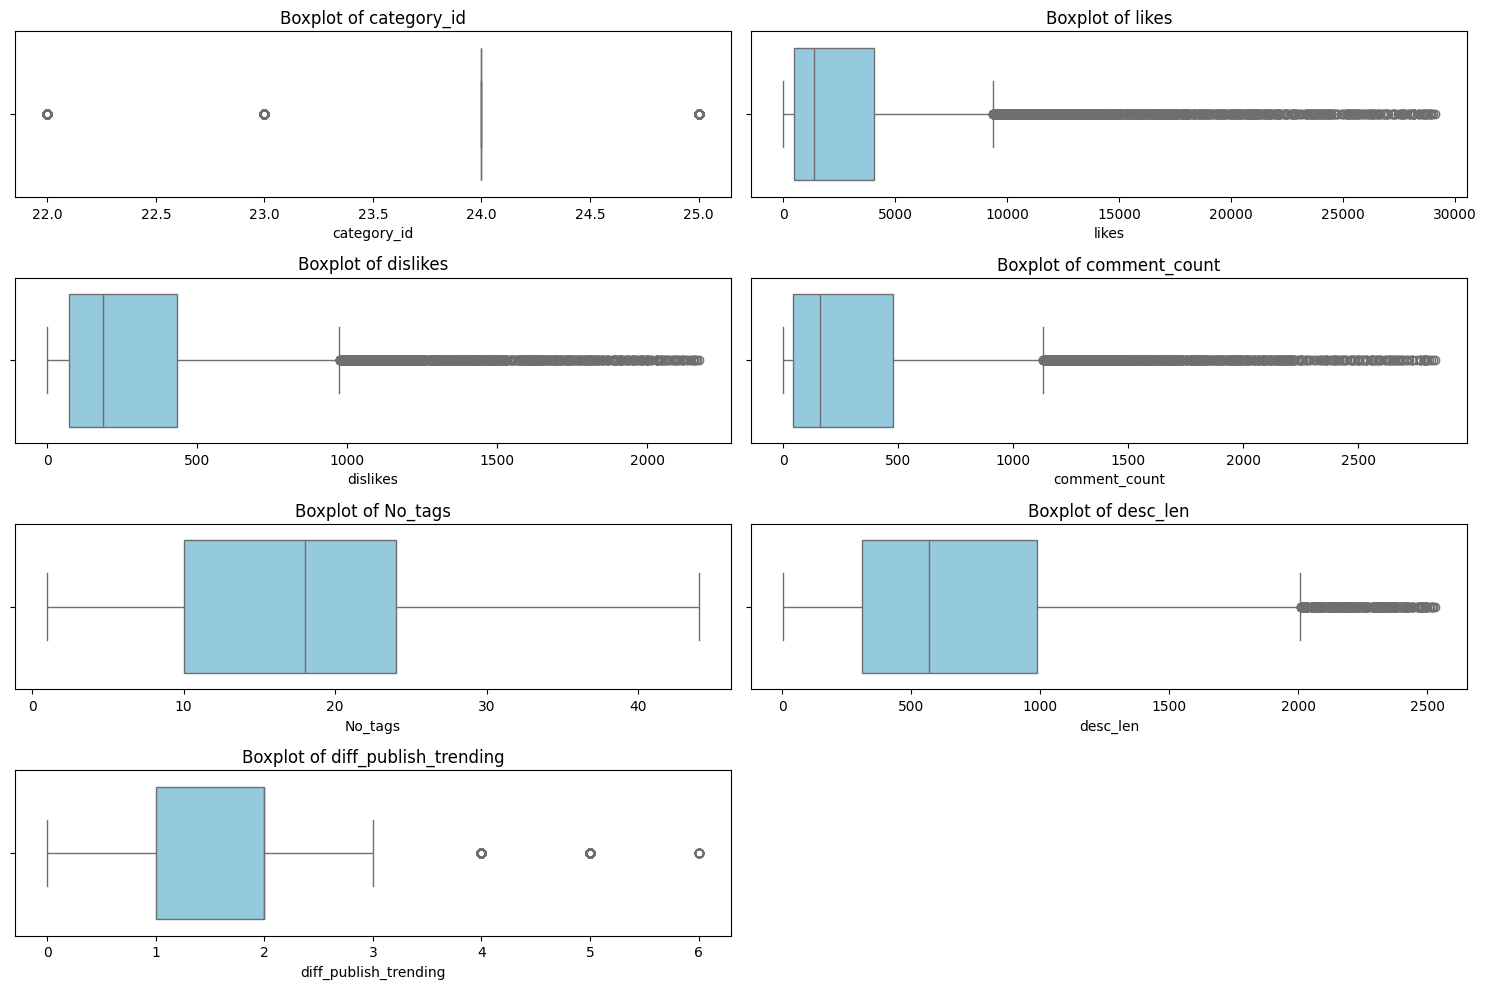

In [107]:
# Boxplot after handling outliers
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 10))
axes = axes.flatten()

for i in range(len(columns_to_handle_outliers)) :
  sns.boxplot(data = df_train_handling_outliers, ax=axes[i], x=columns_to_handle_outliers[i], orient='h', color='skyblue')
  axes[i].set_title(f'Boxplot of {columns_to_handle_outliers[i]}')


# Remove the last subplot if there are fewer features than subplots
if len(columns_to_handle_outliers) < len(axes):
    axes[len(columns_to_handle_outliers)].remove()

plt.tight_layout()

In [108]:
#Split the features and target for train set again
x_train = df_train_handling_outliers.drop(columns='views')
y_train = df_train_handling_outliers['views']

## Feature Scaling

Scaling will be done to train and test data

In [109]:
x_train

category_id  likes  dislikes  comment_count  comments_disabled  \
20257           24    422        55             23                  0   
1216            24   1186       129            360                  0   
36295           24   5264      1053            525                  0   
10227           23  12736       349           1537                  0   
12728           23   9842       574            488                  0   
...            ...    ...       ...            ...                ...   
6312            24   3781       148            267                  0   
22272           22   3348       357            214                  0   
5437            24     50        21              8                  0   
860             24    135       160             17                  0   
24692           24  11174       162            809                  0   

       ratings_disabled  video_error_or_removed  No_tags  desc_len  len_title  \
20257                 0                       0       27       465         54   
1216                  0                       0       12       373         72   
36295                 0                       0        7      2232         43   
10227                 0                       0       31       363         49   
12728                 0                       0        1       181         57   
...                 ...                     ...      ...       ...        ...   
6312                  0                       0       13        86         65   
22272                 0                       0       12        84         84   
5437                  0                       0       35       211         98   
860                   0                       0       21      1149         98   
24692                 0                       0       11       947         48   

       publish_hour  publish_hour_category  trending_year  trending_month  \
20257             4                      0           2018               3   
1216              8                      0           2017              11   
36295             2                      0           2018               6   
10227            12                      0           2018               1   
12728             6                      0           2018               1   
...             ...                    ...            ...             ...   
6312             14                      1           2017              12   
22272             6                      0           2018               3   
5437             12                      0           2017              12   
860              13                      1           2017              11   
24692            10                      0           2018               4   

       trending_day  trending_day_of_week  trending_day_of_year  \
20257             8                     3                    67   
1216             20                     0                   324   
36295            12                     1                   163   
10227             8                     0                     8   
12728            23                     1                    23   
...             ...                   ...                   ...   
6312             17                     6                   351   
22272            20                     1                    79   
5437             13                     2                   347   
860              18                     5                   322   
24692             3                     1                    93   

       is_weekend_trending_day_of_week  publish_year  publish_month  \
20257                                0          2018              3   
1216                                 0          2017             11   
36295                                0          2018              6   
10227                                0          2018              1   
12728                                0          2018              1   
.

In [110]:
x_test

category_id  likes  dislikes  comment_count  comments_disabled  \
14253           25   1863       472            444                  0   
23082           27   3058       662            280                  0   
31715           23   1209        83             62                  0   
5714            27   2570        86            170                  0   
7874            24   3634       349            550                  0   
...            ...    ...       ...            ...                ...   
36659           24  21543      2579           1250                  0   
21663           27   5096       437           1339                  0   
32521           25   1118       443            259                  0   
27131           24   2329       236            201                  0   
27537           24   3020       168            132                  0   

       ratings_disabled  video_error_or_removed  No_tags  desc_len  len_title  \
14253                 0                       0       21       751         48   
23082                 0                       0       29       612        100   
31715                 0                       0       33       217         65   
5714                  0                       0       26       788         96   
7874                  0                       0        8       198         86   
...                 ...                     ...      ...       ...        ...   
36659                 0                       0       33      1564         27   
21663                 0                       0       29       300         41   
32521                 0                       0       11       357         59   
27131                 0                       0        2       421         67   
27537                 0                       0       17       663         82   

       publish_hour  publish_hour_category  trending_year  trending_month  \
14253             5                      0           2018               2   
23082             7                      0           2018               3   
31715            17                      1           2018               5   
5714             18                      1           2017              12   
7874              9                      0           2017              12   
...             ...                    ...            ...             ...   
36659            15                      1           2018               6   
21663            14                      1           2018               3   
32521            20                      1           2018               5   
27131             6                      0           2018               4   
27537            14                      1           2018               4   

       trending_day  trending_day_of_week  trending_day_of_year  \
14253             1                     3                    32   
23082            25                     6                    84   
31715            17                     3                   137   
5714             14                     3                   348   
7874             26                     1                   360   
...             ...                   ...                   ...   
36659            14                     3                   165   
21663            17                     5                    76   
32521            22                     1                   142   
27131            22                     6                   112   
27537            24                     1                   114   

       is_weekend_trending_day_of_week  publish_year  publish_month  \
14253                                0          2018              1   
23082                                1          2018              3   
31715                                0          2018              5   
5714                                 0          2017             12   
7874                                 0          2017             12   
.

**Additional Reminder About Feature Scalling**

When the original distribution is right-skewed, meaning that the majority of the data is concentrated on the left side with a long tail to the right, it's often more appropriate to use transformations that are less sensitive to extreme values. In this case, Min-Max scaling may be a better choice than Z-score normalization.

Here's a brief explanation:

1. **Min-Max Scaling:**
   - Scales the data to a specific range (e.g., between 0 and 1).
   - Less affected by outliers compared to Z-score normalization.
   - Suitable when the distribution is not normal and skewed.

2. **Z-score Normalization (Standardization):**
   - Centers the data around the mean and scales it by the standard deviation.
   - Can be sensitive to outliers, and right-skewed distributions may have extreme values that influence the scaling.
   - More appropriate when the data is approximately normally distributed.

Given a right-skewed distribution, Min-Max scaling is often a better choice as it allows the preservation of the skewed shape of the distribution and avoids amplifying the impact of outliers. However, the choice may also depend on the specific characteristics of your data and the requirements of your modeling task. If your data has extreme outliers, you might also consider other robust scaling methods.

In [111]:
len(x_train.columns)

25

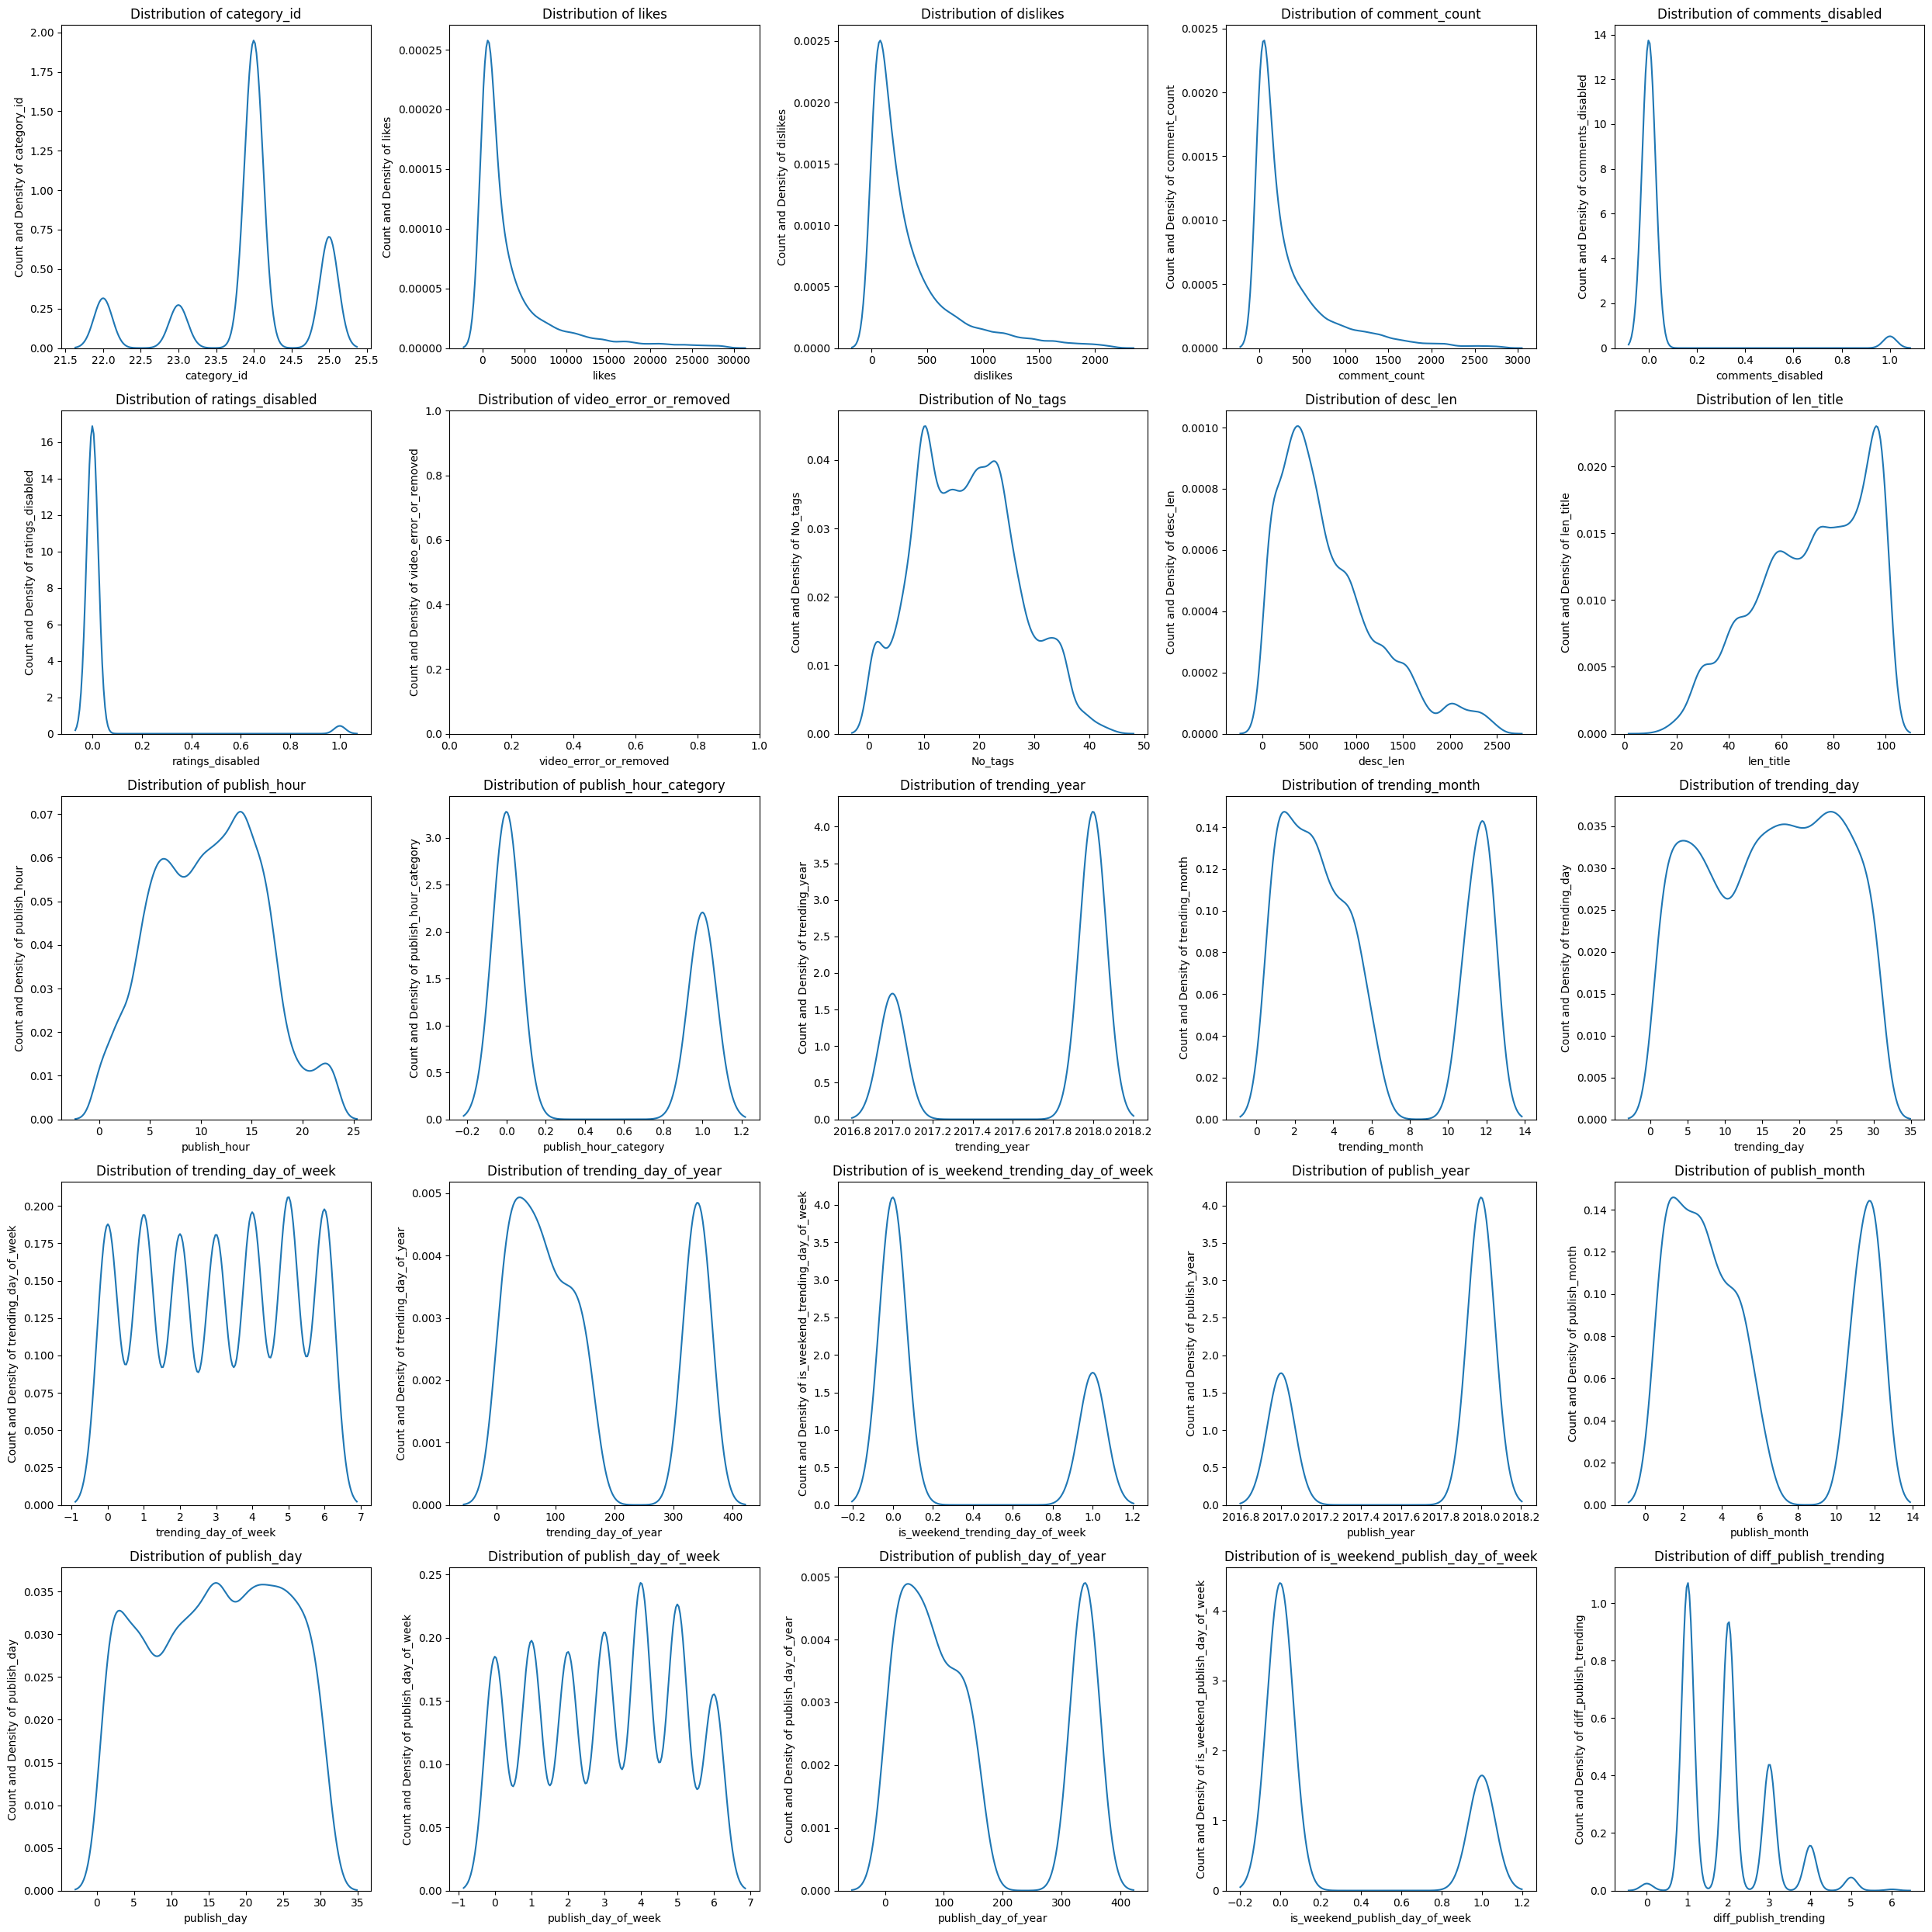

In [112]:
# Checking distribution before scaling
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(25,25))
axes = axes.flatten()

for i in range(len(x_train.columns)) :
    sns.kdeplot(data=x_train, ax=axes[i], x=x_train.columns[i])
    axes[i].set_title(f'Distribution of {x_train.columns[i]}')
    axes[i].set_ylabel(f'Count and Density of {x_train.columns[i]}')
    axes[i].set_xlabel(f'{x_train.columns[i]}')

# Remove the last subplot if there are fewer features than subplots
if len(x_train.columns) < len(axes) :
    axes[len(x_train.columns)].remove()

plt.tight_layout()

Scaling will not be done to all features, but only to features with have large numbers such as likes, dislikes, and desc_len, also the frequency encoded binary columns if we use them

In [113]:
#Normalization (MinMaxScaller)
from sklearn.preprocessing import MinMaxScaler
ms = MinMaxScaler()

columns_to_scale = x_train.columns

x_train[columns_to_scale] = ms.fit_transform(x_train[columns_to_scale])
x_test[columns_to_scale] = ms.transform(x_test[columns_to_scale])

In [114]:
#Robust Scaling
from sklearn.preprocessing import RobustScaler
rs = RobustScaler()

columns_to_scale = ['category_id', 'likes', 'dislikes', 'comment_count', 'No_tags', 'desc_len', 'diff_publish_trending']

x_train[columns_to_scale] = rs.fit_transform(x_train[columns_to_scale])
x_test[columns_to_scale] = rs.transform(x_test[columns_to_scale])

In [75]:
# #Standardization (Z-score normalization)
# from sklearn.preprocessing import StandardScaler

# ss = StandardScaler()

# columns_to_scale = ['likes', 'dislikes', 'No_tags', 'desc_len']

# x_train[columns_to_scale] = ss.fit_transform(x_train[columns_to_scale])
# x_test[columns_to_scale] = ss.transform(x_test[columns_to_scale])

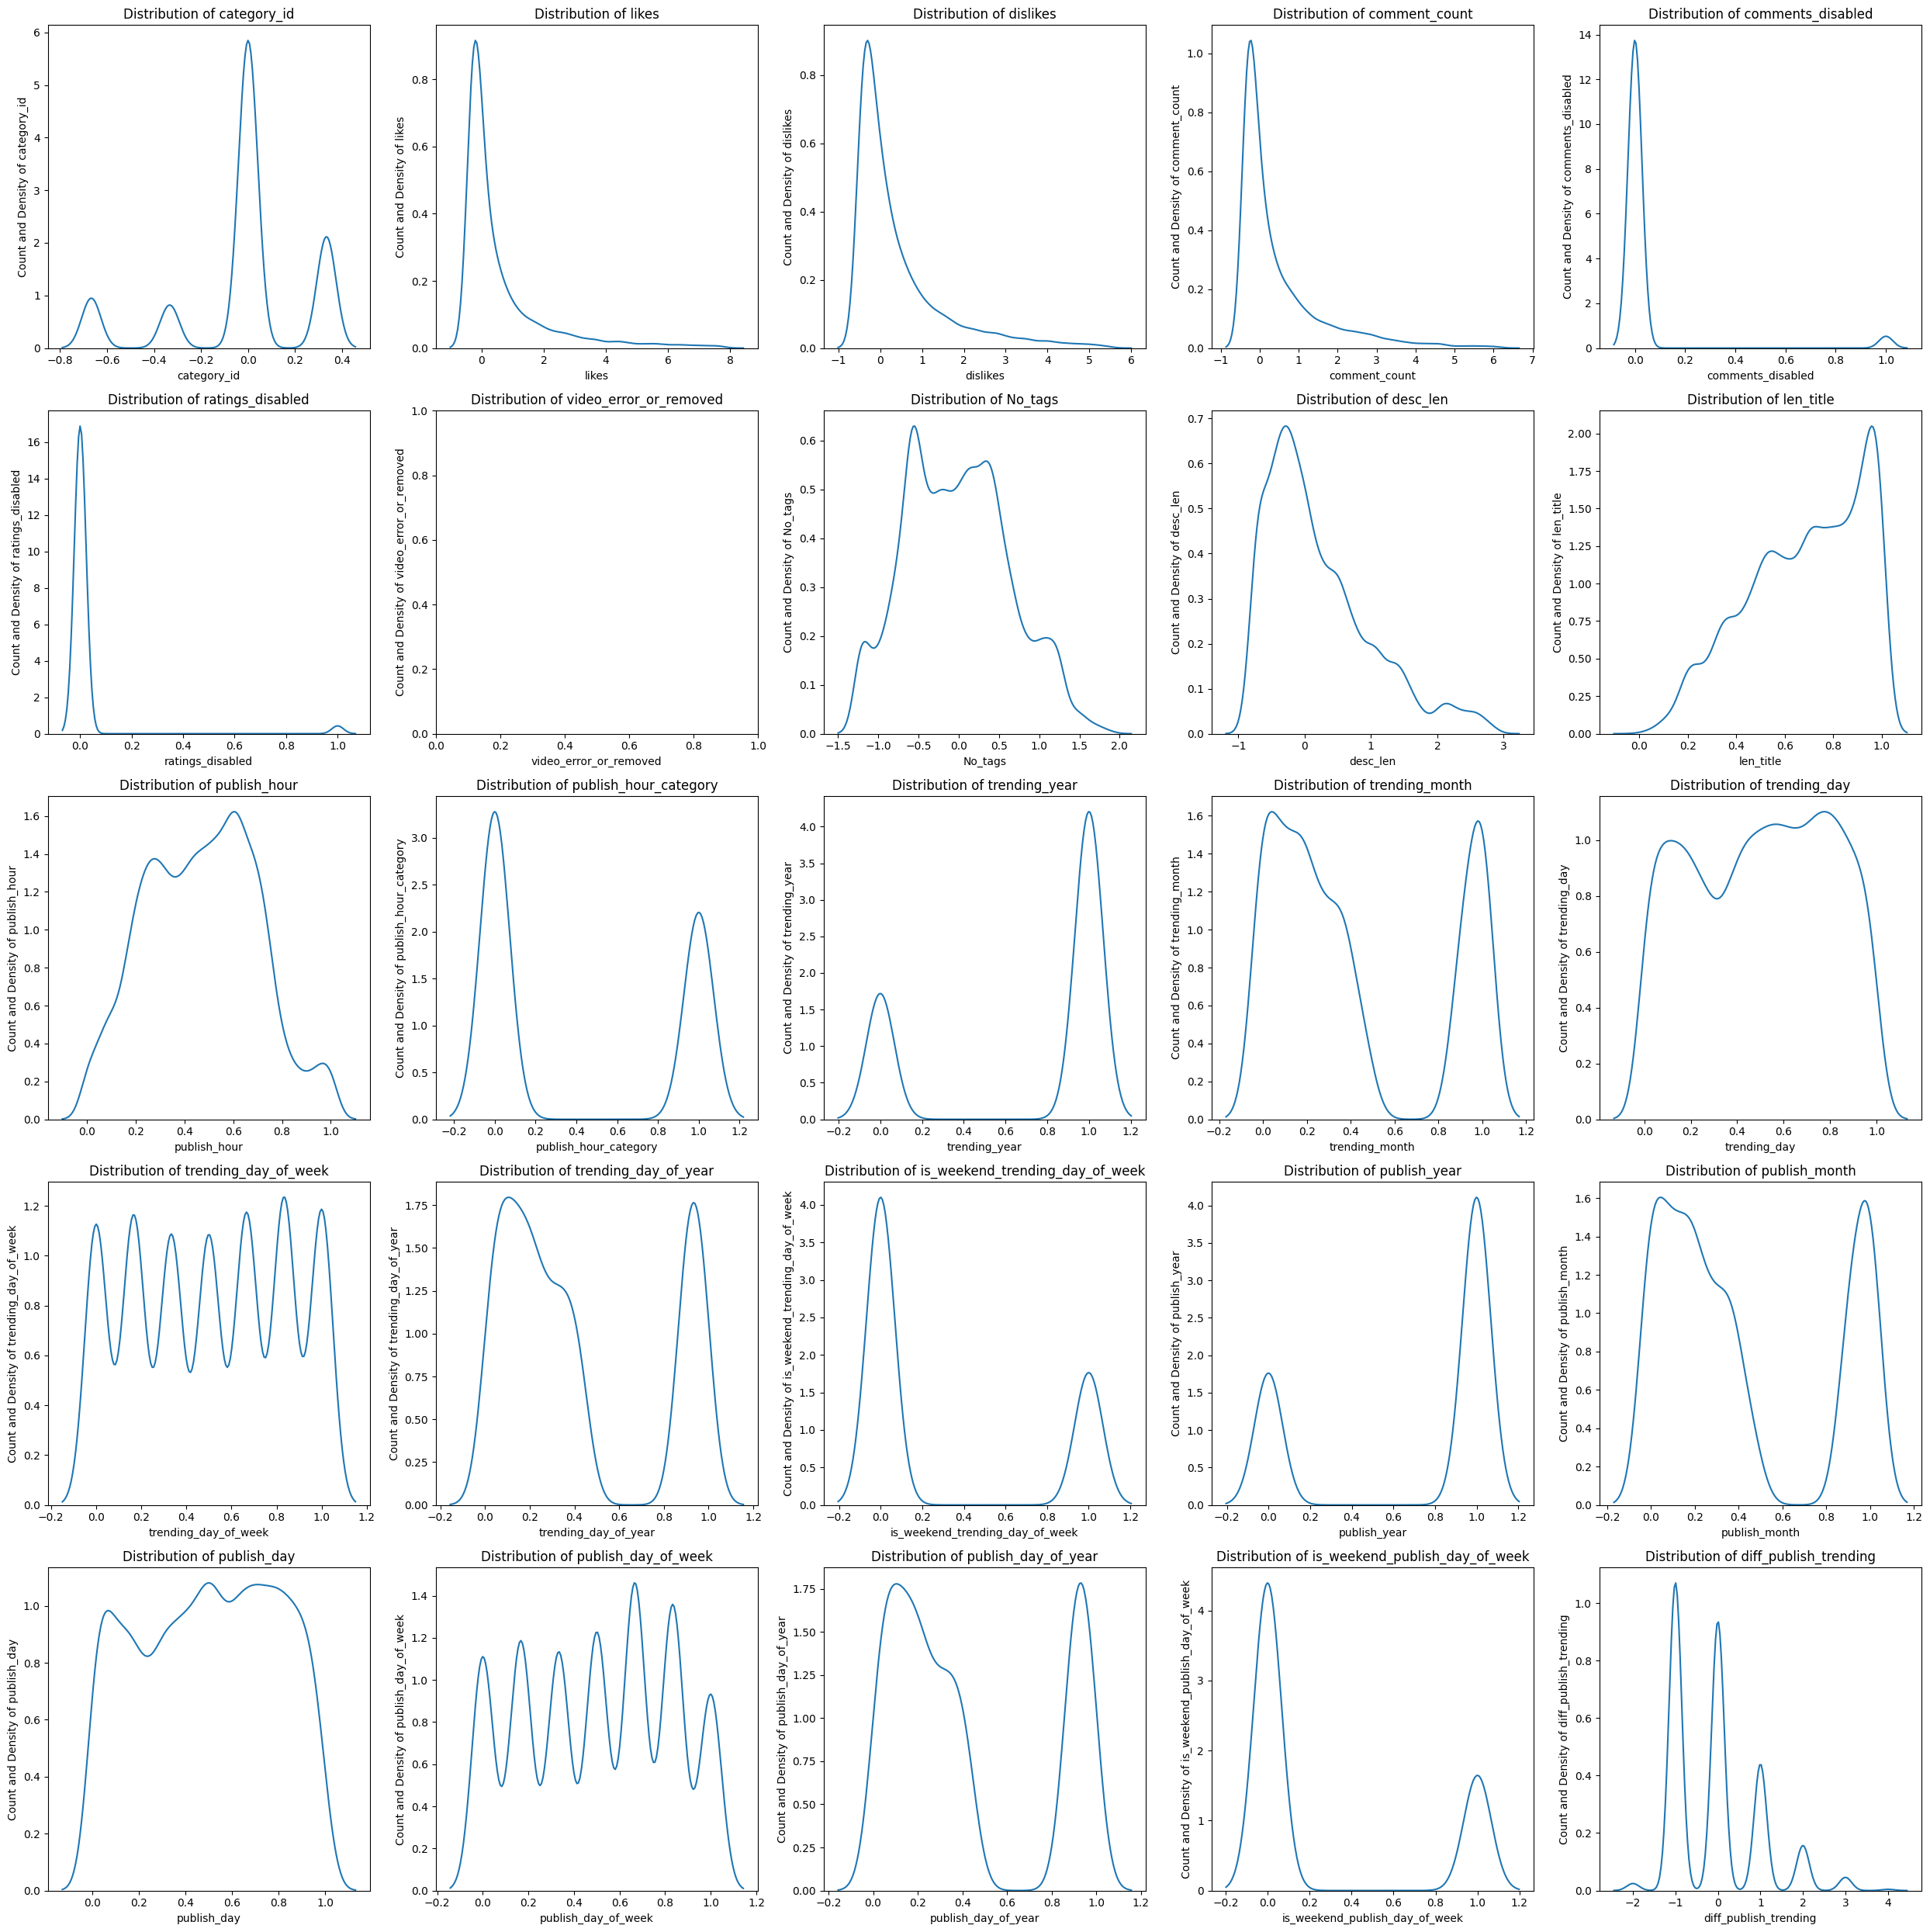

In [115]:
def plot_distribution(data, plot_type='kde'):
    """
    Function to plot the distribution of features in the dataset.
    
    Parameters:
    data (DataFrame): The dataset containing the features to plot.
    plot_type (str): The type of plot to use ('kde' or 'hist').
    """
    fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(25,25))
    axes = axes.flatten()

    for i in range(len(data.columns)):
        if plot_type == 'kde':
            sns.kdeplot(data=data, ax=axes[i], x=data.columns[i])
        elif plot_type == 'hist':
            sns.histplot(data=data, ax=axes[i], x=data.columns[i], kde=True)
        axes[i].set_title(f'Distribution of {data.columns[i]}')
        axes[i].set_ylabel(f'Count and Density of {data.columns[i]}')
        axes[i].set_xlabel(f'{data.columns[i]}')

    # Remove the last subplot if there are fewer features than subplots
    if len(data.columns) < len(axes):
        for j in range(len(data.columns), len(axes)):
            fig.delaxes(axes[j])

    plt.tight_layout()

# Example usage:
plot_distribution(x_train, plot_type='kde')

# **STAGE 3 : MODELLING AND EVALUATION**

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_predict, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

def evaluate_model(X, y, model, cv=5):
    """
    Evaluate the regression model using cross-validation.
    
    Args:
        X (np.ndarray): Features for prediction.
        y (np.ndarray): Target variable.
        model: Regression model instance.
        cv (int): Number of cross-validation folds.

    Returns:
        dict: Dictionary of evaluation metrics (MAE, RMSE, MAPE, R2).
    """
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    predictions = cross_val_predict(model, X, y, cv=kf)
    
    # Metrics
    mae = mean_absolute_error(y, predictions)
    rmse = np.sqrt(mean_squared_error(y, predictions))
    mape = np.mean(np.abs((y - predictions) / y)) * 100
    r2 = r2_score(y, predictions)
    
    return {"MAE": mae, "RMSE": rmse, "MAPE": mape, "R2": r2}

def train_and_evaluate_tfidf(X, y, model=None, test_size=0.2, cv=5):
    """
    Train and evaluate a regression model using TF-IDF features.

    Args:
        X (np.ndarray): TF-IDF feature matrix.
        y (np.ndarray): Target variable.
        model: Regression model instance. Defaults to RandomForestRegressor.
        test_size (float): Proportion of test data. Defaults to 0.2.
        cv (int): Number of cross-validation folds. Defaults to 5.

    Returns:
        dict: Evaluation metrics on the test set.
    """
    if model is None:
        model = RandomForestRegressor(random_state=42)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Cross-validation evaluation
    metrics = evaluate_model(X, y, model, cv=cv)
    print("Cross-Validation Metrics:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")
    
    # Evaluate on test set
    y_pred = model.predict(X_test)
    test_metrics = {
        "MAE": mean_absolute_error(y_test, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        "MAPE": np.mean(np.abs((y_test - y_pred) / y_test)) * 100,
        "R2": r2_score(y_test, y_pred),
    }
    
    print("\nTest Set Metrics:")
    for metric, value in test_metrics.items():
        print(f"{metric}: {value:.4f}")
    
    return model, test_metrics

# Example Usage
# Assuming tfidf_features is the feature matrix from TF-IDF and processed_df is the original DataFrame
target_column = 'views'  # Replace with your target column name
y = processed_df[target_column].values  # Target variable
X = tfidf_features  # TF-IDF feature matrix

# Train and evaluate the model
final_model, test_metrics = train_and_evaluate_tfidf(
    X=X,
    y=y,
    model=RandomForestRegressor(random_state=42),
    test_size=0.2,
    cv=5
)

## Train Regression Models

In [116]:
#Check the amount of training and test data
print(f'Rows of training data : {len(x_train)}')
print(f'Rows of test data : {len(x_test)}')

Rows of training data : 13937
Rows of test data : 9769


In [117]:
# Linear Regression
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(x_train, y_train)

LinearRegression()

In [118]:
# Ridge Regression
from sklearn.linear_model import Ridge
ridge = Ridge()
ridge.fit(x_train, y_train)

Ridge()

In [119]:
# Lasso Regression
from sklearn.linear_model import Lasso
lasso = Lasso()
lasso.fit(x_train, y_train)

Lasso()

In [120]:
# Elastic Net Regression
from sklearn.linear_model import ElasticNet
elasticnet = ElasticNet()
elasticnet.fit(x_train, y_train)

ElasticNet()

In [121]:
# Decision Tree
from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor()
dt.fit(x_train, y_train)

DecisionTreeRegressor()

In [122]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf.fit(x_train, y_train)

RandomForestRegressor()

In [123]:
# Support Vector Regression
from sklearn.svm import SVR
svr = SVR()
svr.fit(x_train, y_train)

SVR()

In [124]:
# Boosting : AdaBoost Regression
from sklearn.ensemble import AdaBoostRegressor
ab = AdaBoostRegressor()
ab.fit(x_train, y_train)

AdaBoostRegressor()

In [125]:
# Boosting : XGBoost Regression
from xgboost import XGBRegressor
xg = XGBRegressor()
xg.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [126]:
# Neural Network
from sklearn.neural_network import MLPRegressor
nn = MLPRegressor()
nn.fit(x_train, y_train)

MLPRegressor()

## Model Evaluation

In [127]:
#Import metrics score that will be evalueated
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import cross_validate

#Function for model evaluation metrics score
def eval_regression(model):
  y_pred = model.predict(x_test)
  y_pred_train = model.predict(x_train)

  # print('MAE (train): ' + str(mean_absolute_error(y_test, y_pred_train)))
  print('MAE (test): ' + str(mean_absolute_error(y_test, y_pred)))

  # print('RMSE (train): ' + str(mean_squared_error(y_train, y_pred_train, squared=False)))
  print('RMSE (test): ' + str(mean_squared_error(y_test, y_pred, squared=False)))

  # print('MAPE (train): ' + str(mean_absolute_percentage_error(y_train, y_pred_train)))
  print('MAPE (test): ' + str(mean_absolute_percentage_error(y_test, y_pred)))

  # print('R2 (train): ' + str(r2_score(y_train, y_pred_train)))
  print('R2 (test): ' + str(r2_score(y_test, y_pred)))

  #Cross Validation
  score = cross_validate(model, x_train, y_train, cv=5, scoring='r2', return_train_score=True) #scoring change based on what metrics we want to validate (usually choose the main performance metric)
  print('R2 Score (crossval train): '+ str(score['train_score'].mean()))
  print('R2 Score (crossval test): '+ str(score['test_score'].mean()))


In [128]:
#Printing metrics score for all models to compare

#Linear Regression
print('\nEvaluate LinearRegression')
eval_regression(lr)

#Ridge Regressor
print('\nEvaluate RidgeRegression')
eval_regression(ridge)

#Lasso Regressor
print('\nEvaluate LassoRegression')
eval_regression(lasso)

#Elastic Net Regressor
print('\nEvaluate ElasticNetRegression')
eval_regression(elasticnet)

#Decision Tree Regressor
print('\nEvaluate DecisionTreeRegressor')
eval_regression(dt)

#Random Forest Regressor
print('\nEvaluate RandomForestRegressor')
eval_regression(rf)

#Support Vector Regressor
print('\nEvaluate SVR')
eval_regression(svr)

#AdaBoost Regressor
print('\nEvaluate AdaBoostRegressor')
eval_regression(ab)

#XGBoost Regressor
print('\nEvaluate XGBRegressor')
eval_regression(xg)

#MLP Regression
print('\nEvaluate MLPRegressor')
eval_regression(nn)


Evaluate LinearRegression
MAE (test): 242389602910.41248
RMSE (test): 13831753681896.908
MAPE (test): 113116.94551269794
R2 (test): -16981065825758.291
R2 Score (crossval train): 0.5356381561583997
R2 Score (crossval test): 0.533728293616891

Evaluate RidgeRegression
MAE (test): 654077.0066645213
RMSE (test): 6992424.720902723
MAPE (test): 0.9667473145453032
R2 (test): -3.339763390576035
R2 Score (crossval train): 0.5344551743024104
R2 Score (crossval test): 0.5328318198153765

Evaluate LassoRegression
MAE (test): 654133.00998328
RMSE (test): 6993427.5364945745
MAPE (test): 0.9669702480558776
R2 (test): -3.341008250445273
R2 Score (crossval train): 0.5344592354032187
R2 Score (crossval test): 0.5328315247229936

Evaluate ElasticNetRegression
MAE (test): 596666.9483959482
RMSE (test): 4753518.031818222
MAPE (test): 1.041772949379225
R2 (test): -1.0055834822438707
R2 Score (crossval train): 0.48553546806584313
R2 Score (crossval test): 0.48547502272889564

Evaluate DecisionTreeRegressor

### Feature Importance in Linear Models

In [129]:
# Flatten the coefficient arrays
lr_coef = pd.Series(lr.coef_.flatten())
ridge_coef = pd.Series(ridge.coef_.flatten())
lasso_coef = pd.Series(lasso.coef_.flatten())
elasticnet_coef = pd.Series(elasticnet.coef_.flatten())

# Creating a DataFrame with coefficients
linear_model_coef = pd.DataFrame({'lr_coef': lr_coef,
                                  'ridge_coef': ridge_coef,
                                  'lasso_coef': lasso_coef,
                                  'elasticnet_coef': elasticnet_coef})

# Add feature names to the DataFrame
linear_model_coef['Feature'] = x_train.columns

# Set 'Feature' as the index
linear_model_coef.set_index('Feature', inplace=True)

# Display coef DataFrame
display(linear_model_coef)

lr_coef     ridge_coef     lasso_coef  \
Feature                                                                       
category_id                     -2.421087e+04  -24248.193941  -24279.024676   
likes                            5.509443e+04   54722.615089   54729.542693   
dislikes                         1.955945e+05  196503.187083  196537.704625   
comment_count                   -4.180052e+04  -41975.618039  -42004.770122   
comments_disabled               -4.362259e+04  -43623.324956  -43864.095721   
ratings_disabled                 2.431372e+05  244149.188646  244936.128016   
video_error_or_removed          -7.892992e+14       0.000000       0.000000   
No_tags                          1.789552e+04   17520.904646   17527.991151   
desc_len                         1.976427e+04   19595.118132   19592.254340   
len_title                        6.952874e+04   69173.138665   69262.305350   
publish_hour                    -4.795245e+04  -49103.640517  -49237.015538   
publish_hour_category           -4.869949e+03   -4567.360251   -4511.036486   
trending_year                    6.370809e+17  113848.631669  109572.802242   
trending_month                   2.074844e+07  100158.412296  131520.678879   
trending_day                     1.876567e+06   10457.181363   13306.762716   
trending_day_of_week             2.074913e+04   22636.667902   22650.814979   
trending_day_of_year             6.353355e+17   -1820.798347  -40379.233731   
is_weekend_trending_day_of_week -1.404717e+04  -15936.100214  -15944.265383   
publish_year                    -6.370809e+17   72222.941880   76113.621766   
publish_month                   -1.963800e+07   27671.338288   59136.270340   
publish_day                     -1.774701e+06    2175.447674    4970.995802   
publish_day_of_week              1.349080e+04   12834.103689   12841.484408   
publish_day_of_year             -6.353355e+17   39711.849074    9453.458480   
is_weekend_publish_day_of_week  -2.821839e+04  -28410.372150  -28403.704370   
diff_publish_trending           -1.745427e+15   75493.111515   75504.048342   

                                 elasticnet_coef  
Feature                                           
category_id                         -3935.085420  
likes                               48670.189595  
dislikes                           124050.058657  
comment_count                        3005.492612  
comments_disabled                    3161.511460  
ratings_disabled                     8275.814591  
video_error_or_removed                  0.000000  
No_tags                             10669.778807  
desc_len                            13652.846619  
len_title                            8666.180787  
publish_hour                        -3480.100666  
publish_hour_category               -6642.264533  
trending_year                       11473.306388  
trending_month                      -4375.654186  
trending_day                         -599.596396  
trending_day_of_week                 1466.573684  
trending_day_of_year                -4157.151805  
is_weekend_trending_day_of_week     -1165.249678  
publish_year                        11488.732224  
publish_month                       -4662.858043  
publish_day                            74.584889  
publish_day_of_week                 -3155.874670  
publish_day_of_year                 -4344.766155  
is_weekend_publish_day_of_week      -7634.151106  
diff_publish_trending               62659.802135

# Summary of Models Generated by Various Machine Learning Algorithms

Experiment was conducted on the models below :

1. Linear Regression (with regularization : Ridge, Lasso, and Elastic Net)
2. Decision Tree Regression
3. Random Forest Regression
4. Support Vector Regression
5. Gradient Boosting Regression (AdaBoost and XGBoost)
6. Multi-Layer Perceptron (MLP) Regression

From all of the models, the best results were obtained by:

- **Random Forest Regression**
- **XGBoost Regression**

Therefore, hyperparameter tuning can be applied to these two models to slightly improve their results (for other models that also have decent performance, experiments will be conducted if there is time and additional resources available).

## Feature Importances from Regression Models

In [130]:
#Function for model feature importance score
def show_feature_importance(model):
    feat_importances = pd.Series(model.feature_importances_, index=x.columns)
    ax = feat_importances.nlargest(25).plot(kind='barh', figsize=(10, 8))
    ax.invert_yaxis()

    plt.xlabel('Score')
    plt.ylabel('Feature')
    plt.title('Feature importance score')

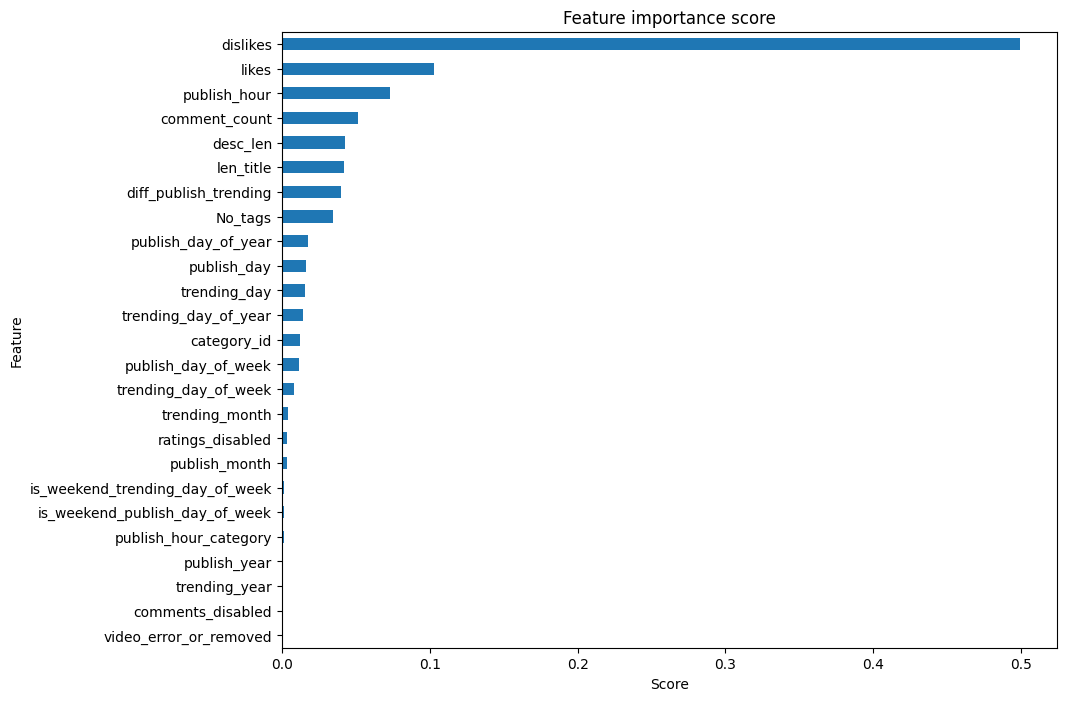

In [131]:
# Feature importance in random forest
show_feature_importance(rf)

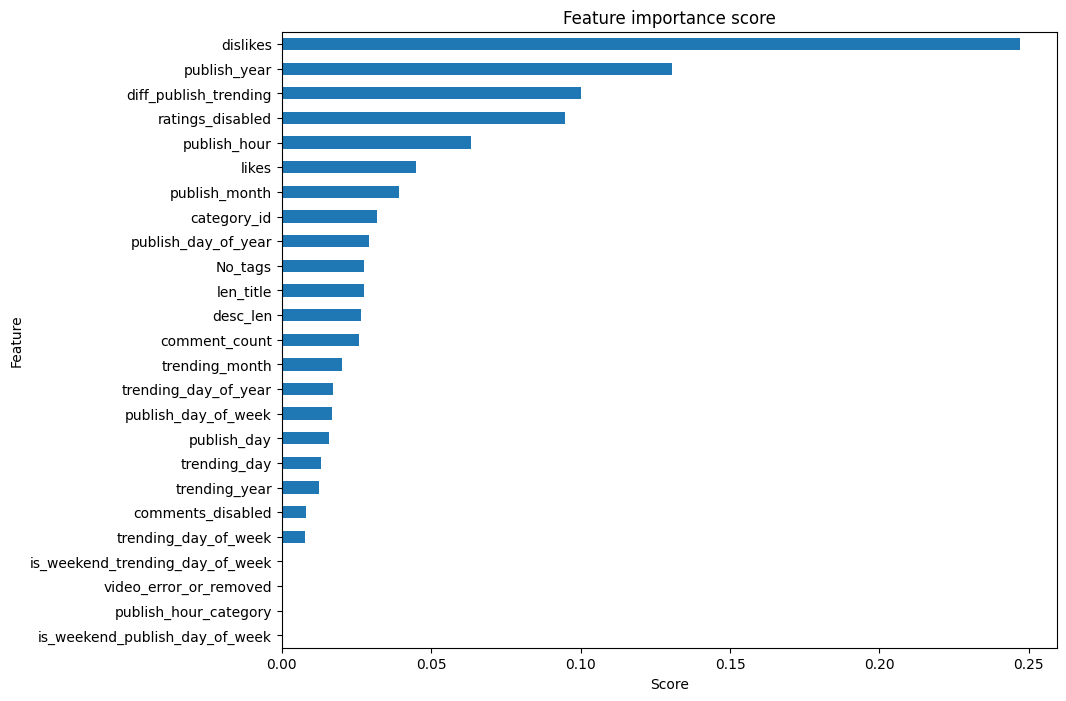

In [132]:
# Feature importance in XGB
show_feature_importance(xg)

## Hyperparameter Tuning

In [135]:
#Function for best hyperparameters found during the tuning process
def show_best_hyperparameter(model):
    print(model.best_estimator_.get_params())

### Hyperparameter Tuning For Random Forest Regression

<b>Commonly tuned hyperparameters in Random Forest:</b> (<a href='https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html'>Sklearn Random Forest Documentation</a>)

- n_estimators: the number of trees to be built in the forest.
- max_samples: the maximum number of samples to be drawn from the total training set for building each tree (after the bootstrap process).

The remaining hyperparameters are the same as in Decision Trees:

- criterion: the method used to measure impurity in features (gini, entropy). This is for classification; for regression, it's different. It determines which feature becomes the root/node (squared_error, poisson).
- max_depth: the maximum depth of each tree to prevent overfitting.
- min_sample_split: the minimum number of samples required at a node to create a new leaf (to avoid having too few samples, which can lead to overfitting).
- min_sample_leaf: the minimum number of samples required in a leaf for the leaf to be formed (to avoid having too few samples, which can lead to overfitting).
- ccp_alpha: if the cost/error of a leaf/subtree is greater than ccp_alpha, that subtree will be pruned, minimizing the error/variance of the model.

In [133]:
# Hyperparameter Tuning for random forest
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

#Initiate hyperparameters used and their values
n_estimators = [int(x) for x in np.linspace(50, 180, 5)]
criterion = ['squared_error', 'poisson']
max_depth = [int(x) for x in np.linspace(50, 180, 5)]
min_samples_split = [int(x) for x in np.linspace(2, 10, 2)]
min_samples_leaf = [int(x) for x in np.linspace(2, 10, 2)]

#Collecting all hyperparameters into a single dictionary
hyperparameters = dict(n_estimators=n_estimators, 
                       criterion=criterion, 
                       max_depth=max_depth,
                       min_samples_split=min_samples_split,
                       min_samples_leaf=min_samples_leaf)

#Initiate tuned model
rf = RandomForestRegressor()
# rf_tuned = GridSearchCV(dt, hyperparameters, cv=5, scoring='r2')
rf_tuned = RandomizedSearchCV(rf, hyperparameters, scoring='r2', cv=5, error_score='raise')
rf_tuned.fit(x_train, y_train)

#Tuned model evaluation
eval_regression(rf_tuned)

MAE (test): 670593.8343174031
RMSE (test): 3197034.1717275316
MAPE (test): 0.5930682597912154
R2 (test): 0.09279588941552341
R2 Score (crossval train): 0.924999059161212
R2 Score (crossval test): 0.7119895851724807


In [136]:
# Best hyperparameter in random forest
show_best_hyperparameter(rf_tuned)

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'poisson', 'max_depth': 50, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 180, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [137]:
# Retrieving the best hyperparameters for random forest (similar to show_best_hyperparameter code before, but only shows the ones that we used)
best_params = rf_tuned.best_params_
best_params

{'n_estimators': 180,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_depth': 50,
 'criterion': 'poisson'}

In [159]:
# #Learning curve for hyperparameters

# # Hyperparameter that will be tested and their values (can be found in best hyperparameter before or experiment with others)
# # param_values = [int(x) for x in np.linspace(50, 180, 5)] # n_estimators
# # param_values = [int(x) for x in np.linspace(50, 180, 5)] # max_depth
# # param_values = [int(x) for x in np.linspace(2, 10, 2)] # min_samples_split
# param_values = [int(x) for x in np.linspace(2, 10, 2)] # min_samples_leaf

# train_scores = []
# test_scores = []

# for i in param_values:
#     model = RandomForestRegressor(min_samples_leaf=i) # Change based on what hyperparameter that we used
#     model.fit(x_train, y_train)

#     # eval on train
#     y_pred_train_proba = model.predict_proba(x_train)
#     train_r2 = r2_score(y_train, y_pred_train_proba[:,1])
#     train_scores.append(train_r2)

#     # eval on test
#     y_pred_proba = model.predict_proba(x_test)
#     test_r2 = r2_score(y_test, y_pred_proba[:,1])
#     test_scores.append(test_r2)

#     print('Param value: ' + str(i) + '; train: ' + str(train_r2) + '; test: '+ str(test_r2))

# plt.title('Learning Curve | Hyperparameter : min_sample_leaf | Random Forest') # Change based on what hyperparameter that we used
# plt.ylabel('R2 Score')
# plt.xlabel('min_sample_leaf') # Change based on what hyperparameter that we used
# plt.plot(param_values, train_scores, label='Train')
# plt.plot(param_values, test_scores, label='Test')
# plt.legend()
# plt.show()

### Hyperparameter Tuning For XGBoost Regression

<b>Commonly tuned hyperparameters in XGBoost:</b>  (<a href='https://xgboost.readthedocs.io/en/latest/parameter.html'>XGBoost Documentation</a>)

- <b>Tree architecture-related:</b>
    - max_depth: the maximum depth of the tree to prevent overfitting.
    - min_child_weight: the minimum weight (or the number of samples if the total weight equals 1) a node should have to create a new leaf (to avoid having too few, causing overfitting).
    - gamma: the minimum loss/error reduction required to make a new leaf.
    - tree_method: the method XGBoost uses to build a tree. The algorithm we are learning is tree_method = exact. Other references can be found <a href='https://xgboost.readthedocs.io/en/latest/treemethod.html'>here</a>.

- <b>Boosting process subsampling:</b> Instead of using the entire training data in each iteration, we can use a sample in each iteration.
    - subsample: how much of the row samples to be used for sampling at each step. 1 for all rows.
    - colsample_bytree: how many features to be used. 1 for all features.

- <b>Control learning rate:</b>
    - eta: the step size for updating the feature weight in XGBoost, value range: 0-1. Smaller eta provides more fine-grained corrections but requires more boosting iterations.
        - In sklearn, the hyperparameter name is learning_rate.

- <b>Regularization in XGBoost:</b>
    - lambda: the regularization term on L2 norm.
    - alpha: the regularization term on L1 norm.

- <b>Learning task in XGBoost:</b>
    - objective: the objective function used, such as calculating error in regression.
    - eval_metric: evaluation metrics used on the validation data (e.g., rmse, mae, auc).
    - seed: random state.

- <b>Others:</b>
    - scale_pos_weight: if the data is imbalanced, this parameter is used to adjust the weight of each label.
    
- <b>Other parameters for model checking and debugging:</b>
    - verbose: to display detailed log information during the model training. 0: no messages; 1: display warnings only; 2: display info (deprecated examples); 3: debug: detailed training information for the model.

In [138]:
#Hyperparameter tuning for xgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

#Initiate hyperparameters used and their values
max_depth = [int(x) for x in np.linspace(50, 180, 5)]
min_child_weight = [int(x) for x in np.linspace(1, 20, 11)]
gamma = [float(x) for x in np.linspace(0, 3, num = 11)]
tree_method = ['auto', 'exact', 'approx']

colsample_bytree = [float(x) for x in np.linspace(0, 1, 11)]
eta = [float(x) for x in np.linspace(0, 1, num = 100)]

# lambda = [float(x) for x in np.linspace(0, 1, 11)]
alpha = [float(x) for x in np.linspace(0, 1, 11)]

#Collecting all hyperparameters into a single dictionary
hyperparameters = dict(max_depth=max_depth, 
                       min_child_weight=min_child_weight, 
                       gamma=gamma,
                       tree_method=tree_method,
                       colsample_bytree=colsample_bytree,
                       eta=eta,
                       alpha=alpha)

#Initiate tuned model
xg = XGBRegressor()
# xg_tuned = GridSearchCV(xg, hyperparameters, cv=5, scoring='r2')
xg_tuned = RandomizedSearchCV(xg, hyperparameters, scoring='r2', cv=5, error_score='raise')
xg_tuned.fit(x_train,y_train)

# Evaluation
eval_regression(xg_tuned)

MAE (test): 680878.7643495533
RMSE (test): 3215731.649601106
MAPE (test): 0.6477532415489926
R2 (test): 0.08215350697335533
R2 Score (crossval train): 0.9942632554300392
R2 Score (crossval test): 0.7622192522244393


In [139]:
# Best hyperparameter in xgb
show_best_hyperparameter(xg_tuned)

{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.5, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': 2.6999999999999997, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 115, 'max_leaves': None, 'min_child_weight': 18, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': 'exact', 'validate_parameters': None, 'verbosity': None, 'eta': 0.08080808080808081, 'alpha': 0.2}


In [140]:
# Retrieving the best hyperparameters for xgb (similar to show_best_hyperparameter code before, but only shows the ones that we used)
best_params = xg_tuned.best_params_
best_params

{'tree_method': 'exact',
 'min_child_weight': 18,
 'max_depth': 115,
 'gamma': 2.6999999999999997,
 'eta': 0.08080808080808081,
 'colsample_bytree': 0.5,
 'alpha': 0.2}

In [ ]:
# #Learning curve for hyperparameters

# # Hyperparameter that will be tested and their values (can be found in best hyperparameter before or experiment with others)
# # param_values = [int(x) for x in np.linspace(5, 20, 11)] #max_depth
# # param_values = [int(x) for x in np.linspace(1, 20, 11)] #min_child_weight
# # param_values = [float(x) for x in np.linspace(0, 3, num = 11)] #gamma
# # param_values = ['auto', 'exact', 'approx'] #tree_method
# # param_values = [float(x) for x in np.linspace(0, 1, 11)] #colsample_bytree
# # param_values = [float(x) for x in np.linspace(0, 1, 100)] #eta
# # param_values = [float(x) for x in np.linspace(0, 1, 11)] #lambda
# param_values = [float(x) for x in np.linspace(0, 1, 11)] #alpha

# train_scores = []
# test_scores = []

# for i in param_values:
#     model = XGBRegressor(alpha=i) # Change based on what hyperparameter that we used
#     model.fit(x_train, y_train)

#     # eval on train
#     y_pred_train_proba = model.predict_proba(x_train)
#     train_r2 = r2_score(y_train, y_pred_train_proba[:,1])
#     train_scores.append(train_r2)

#     # eval on test
#     y_pred_proba = model.predict_proba(x_test)
#     test_r2 = r2_score(y_test, y_pred_proba[:,1])
#     test_scores.append(test_r2)

#     print('Param value: ' + str(i) + '; train: ' + str(train_r2) + '; test: '+ str(test_r2))

# plt.title('Learning Curve | Hyperparameter : alpha | XGB') # Change based on what hyperparameter that we used
# plt.ylabel('AUC')
# plt.xlabel('alpha') # Change based on what hyperparameter that we used
# plt.plot(param_values, train_scores, label='Train')
# plt.plot(param_values, test_scores, label='Test')
# plt.legend()
# plt.show()

## Comparison of Results Before and After Hyperparameter Tuning

<b>Evaluate RandomForestRegressor</b>

- Before Hyperparameter Tuning
    - MAE (test): 664766.6023503576
    - RMSE (test): 3176146.0151437307
    - MAPE (test): 0.6269118547067823
    - R2 (test): 0.10461178826553719
    - R2 Score (crossval train): 0.958699637383497
    - R2 Score (crossval test): 0.7106541738473096

- After Hyperparameter Tuning
    - MAE (test): 670593.8343174031
    - RMSE (test): 3197034.1717275316
    - MAPE (test): 0.5930682597912154
    - R2 (test): 0.09279588941552341
    - R2 Score (crossval train): 0.924999059161212
    - R2 Score (crossval test): 0.7119895851724807

<b>Evaluate XGBRegressor</b>

- Before Hyperparameter Tuning
    - MAE (test): 674435.1305398261
    - RMSE (test): 3199200.2948880275
    - MAPE (test): 0.6215205310783862
    - R2 (test): 0.09156613617964471
    - R2 Score (crossval train): 0.9672637928829507
    - R2 Score (crossval test): 0.7652375612499716

- After Hyperparameter Tuning
    - MAE (test): 680878.7643495533
    - RMSE (test): 3215731.649601106
    - MAPE (test): 0.6477532415489926
    - R2 (test): 0.08215350697335533
    - R2 Score (crossval train): 0.9942632554300392
    - R2 Score (crossval test): 0.7622192522244393

Further tuning need to be done, and we can also experiment with other combination of features in training